In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',
              rc={'axes.facecolor': (0, 0, 0, 0)})
sns.set_context('talk')

from matplotlib import rcParams, colors, cm
import matplotlib.patches as mpatches
rcParams['font.family'] = 'sans-serif'
rcParams['figure.dpi'] = 150

In [2]:
import os
import warnings
import itertools
import numpy as np
import pandas as pd
from scipy import stats
from pyfish import fish_plot, process_data
# local import
from utils import read_mi, enrichment
from utils import ml_metrics, get_rbd_mutated
from utils import AFFINITY, ESCAPE, MOI

In [3]:
INTERESTING = set(MOI).union(AFFINITY).union(ESCAPE)

In [4]:
print(INTERESTING)

{18, 403, 406, 417, 681, 439, 440, 446, 447, 449, 452, 455, 456, 477, 484, 489, 493, 494, 496, 498, 501, 505, 506}


In [5]:
def plot_mi(s, date):
    c = s[s['name'] == date].pivot_table(index='feature_codon_source',
                                         columns='feature_codon_target',
                                         values='outlier',
                                         aggfunc=max)
    
    c = c.reindex(index=sorted(INTERESTING),
                  columns=sorted(INTERESTING))
    
    cmap = plt.get_cmap('crest_r').copy()
    cmap.set_bad('xkcd:light grey')
    
    colors = []
    for x in c.index:
        if x in AFFINITY:
            colors.append('#ef3b2cff')
        elif x in ESCAPE:
            colors.append('#2171b5ff')
        elif x in MOI:
            colors.append('#fec44fff')
        else:
            colors.append('xkcd:grey')
    
    c.index = c.index.astype(int)
    c.columns = c.columns.astype(int)
    
    cm = sns.clustermap(c, cmap=cmap,
                        row_cluster=False, col_cluster=False,
                        row_colors=colors,
                        col_colors=colors,
                        linewidths=0.005,
                        cbar_pos=None,
                        figsize=(7, 7),
                        vmin=1, vmax=4)
    
    cm.ax_heatmap.set_xlabel('spike codon')
    cm.ax_heatmap.set_ylabel('spike codon')
    
    cm.ax_heatmap.set_xticks([x + 0.5 for x in range(c.shape[1])],
                             c.columns,
                             fontsize=13)
    cm.ax_heatmap.set_yticks([x + 0.5 for x in range(c.shape[0])],
                             c.index,
                             fontsize=13)
    
    cm.ax_heatmap.set_title(date, y=1.04)
    
    plt.savefig(f'time_{date}.png',
                dpi=300,
                bbox_inches='tight',
                transparent=True)
    plt.savefig(f'time_{date}.svg',
                dpi=300,
                bbox_inches='tight',
                transparent=True);

In [6]:
a = read_mi(f'../out/all-notime/mi_annotated.tsv.gz',
            'all', date=False)

In [7]:
no_time = read_mi(f'../out/time-subsets-notime/2023-03/mi_annotated.tsv.gz',
                  '2023-03',
                  date=True)

In [8]:
df = []
d_mutated = {}
all_mutated = set()
for name in sorted(os.listdir('../out/time-filtered-subsets/')):
    try:
        df.append(read_mi(f'../out/time-filtered-subsets/{name}/mi_annotated.tsv.gz',
                          name,
                          date=True))
        mutated = get_rbd_mutated('../out/time-filtered-lineages/',
                                  names=[name,])
        d_mutated[name] = mutated.union(all_mutated)
        all_mutated = mutated.union(all_mutated)
    except FileNotFoundError:
        pass
df = pd.concat(df)

In [9]:
df.groupby(['year', 'month'])['pos_source'].count()

year  month
2020  3        79586
      4        75912
      5        67722
      6        71006
      7        57336
      8        50200
      9        44790
      10       38936
      11       22166
      12       18520
2021  1        18588
      2        11238
      3         8580
      4         8426
      5         9292
      6         7392
      7         5938
      8         5216
      9         4906
      10        8374
      11        6498
      12        3538
2022  1         3004
      2         1654
      3         1204
      4          652
      5          516
      6          516
      7          488
      8          572
      9          622
      10         570
      11         682
      12         558
2023  1          578
      2          594
      3          730
Name: pos_source, dtype: int64

In [10]:
count = df.groupby(['name', 'outlier'])['pos_source'].count().reset_index()

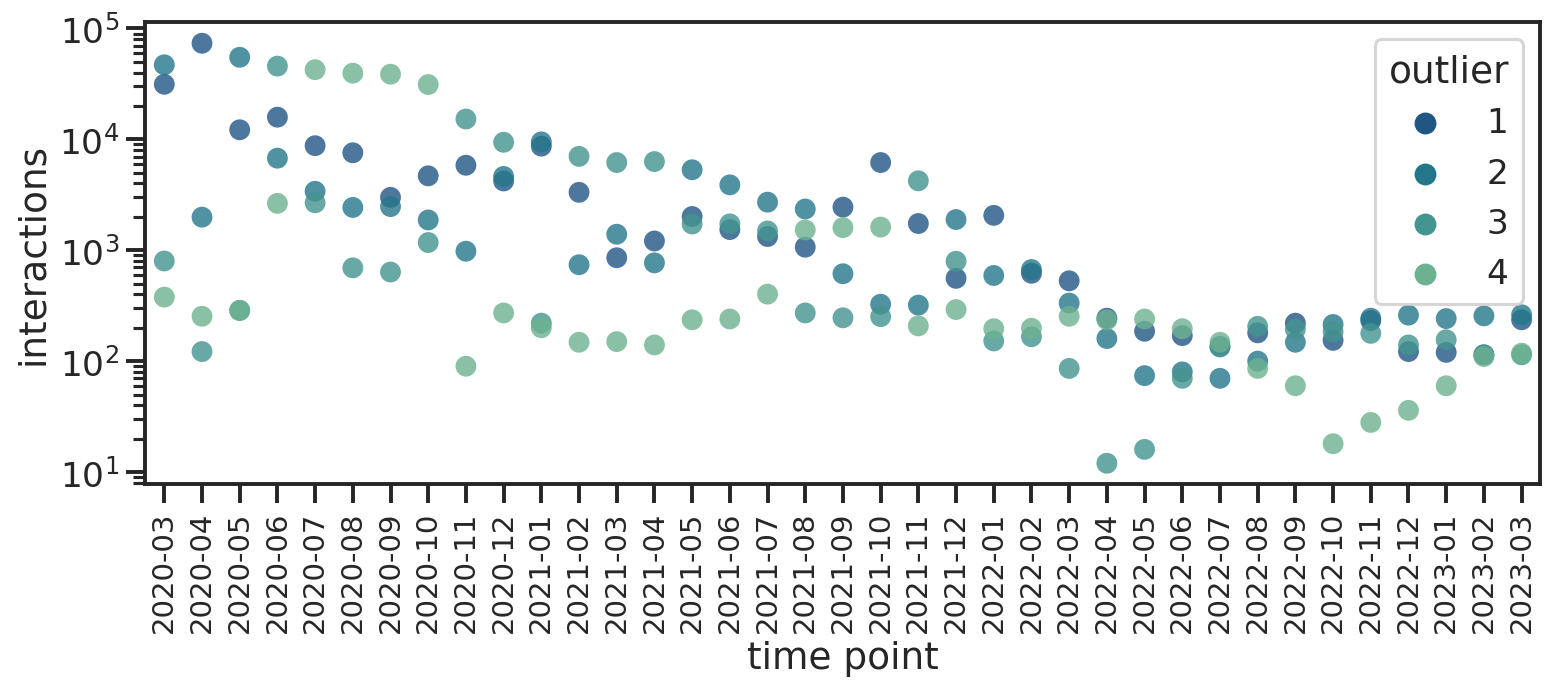

In [11]:
plt.figure(figsize=(12, 4))

sns.stripplot(data=count,
              y='pos_source',
              x='name',
              hue='outlier',
              size=10,
              jitter=0,
              alpha=0.8,
              palette=sns.color_palette('crest_r', 4))

plt.xticks(rotation=90,
           size=14)

plt.legend(facecolor='w',
           title='outlier')

plt.ylabel('interactions')
plt.xlabel('time point')

plt.yscale('log')

plt.savefig('time_1.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_1.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

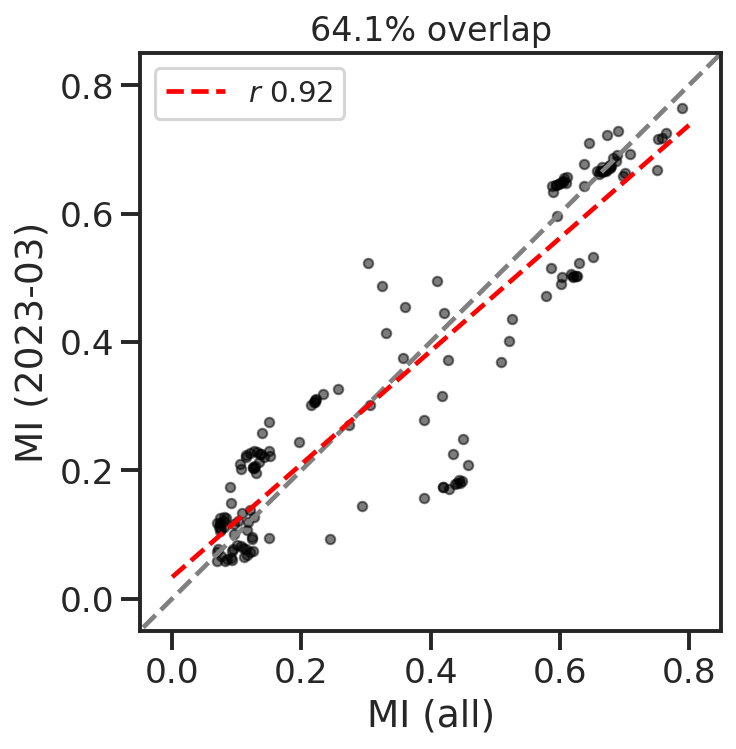

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))

a = a.set_index(['pos_source', 'pos_target'])
no_time = no_time.set_index(['pos_source', 'pos_target'])

idx = a.index.intersection(no_time.index)

av = a.loc[idx]['mi']
sv = no_time.loc[idx]['mi']

ax.plot(av,
        sv,
        'k.',
        alpha=0.3,
        rasterized=True)
ax.plot([-1, 1], [-1, 1],
        '--',
        color='grey')

lr = stats.linregress(av, sv)

ax.plot([0, 0.8],
        [lr.intercept,
         lr.slope * 0.8 + lr.intercept],
        'r--',
        label=f'$r$ {lr.rvalue:.2f}')

ax.legend(facecolor='w', fontsize=14)

ax.set_xlim(-0.05, 0.85)
ax.set_ylim(-0.05, 0.85)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])

ax.set_ylabel('MI (2023-03)')
ax.set_xlabel('MI (all)')

ax.set_title(f'{av.shape[0] * 100 / a.shape[0]:.1f}% overlap',
             fontsize=16)

a = a.reset_index()
no_time = no_time.reset_index()

plt.savefig('time_2.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_2.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [13]:
p = pd.read_csv('../out/spikes/2023-03/2023-03.EC', sep=' ', header=None)
p.columns = ['pos_source', 'base_source',
             'pos_target', 'base_target',
             '_', 'plmc']

In [14]:
m = no_time[(no_time['gene_source'] == 'S') &
            (no_time['gene_target'] == 'S')].sort_values('pos_source').copy()
m['pos_source'] = m['pos_source'] - 21562
m['pos_target'] = m['pos_target'] - 21562

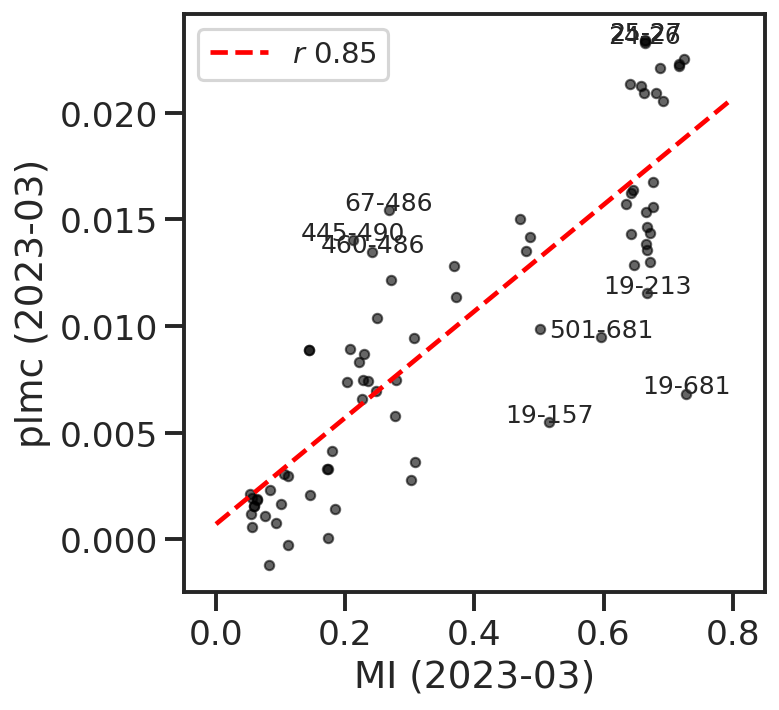

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))

m = m.set_index(['pos_source', 'pos_target'])
p = p.set_index(['pos_source', 'pos_target'])

idx = m.index.intersection(p.index)

av = m.loc[idx]['mi']
sv = p.loc[idx]['plmc']

ax.plot(av,
        sv,
        'k.',
        alpha=0.6,
        rasterized=True)


lr = stats.linregress(av, sv)

ax.plot([0, 0.8],
        [lr.intercept,
         lr.slope * 0.8 + lr.intercept],
        'r--',
        label=f'$r$ {lr.rvalue:.2f}')

res = m.loc[idx].join(p.loc[idx], how='inner')
res['res'] = res['plmc'] - (lr.slope * res['mi'] + lr.intercept)
res['abs(res)'] = abs(res['res'])
res = res.sort_values('abs(res)').tail(10)
for p1, p2, mi, plmc in res[['feature_codon_source',
                             'feature_codon_target',
                             'mi', 'plmc']].values:
    ax.text(mi, plmc,
            f'{int(p1)}-{int(p2)}',
            size=12,
            ha='center')

ax.legend(facecolor='w', fontsize=14)
ax.set_xlim(-0.05, 0.85)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])

ax.set_ylabel('plmc (2023-03)')
ax.set_xlabel('MI (2023-03)')

a = m.reset_index()
m = m.reset_index()
p = p.reset_index()

plt.savefig('time_3.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_3.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [16]:
res = []
for name in sorted(df['name'].unique()):
    year = int(name.split('-')[0])
    month = int(name.split('-')[1])
    
    s = df[df['name'] == name]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        o = enrichment(s, d_mutated[name])
    
    print(name)

    res.append(['actual', year, month, name,
                o[o['type'] == 'original']['odds-ratio'].values[0],
                o[o['type'] == 'original']['low'].values[0],
                o[o['type'] == 'original']['high'].values[0]])

    for odds_ratio in o[o['type'] == 'random']['odds-ratio'].values:
        res.append(['random', year, month, name, odds_ratio + 0.1, np.nan, np.nan])

r = pd.DataFrame(res,
                 columns=['set',
                          'year', 'month',
                          'name', 'odds-ratio',
                          'low', 'high'])
r.groupby(['name', 'year', 'month', 'set']).mean().to_csv('enrichment_time.tsv',
                                                          sep='\t')

2020-03
2020-04
2020-05
2020-06
2020-07
2020-08
2020-09
2020-10
2020-11
2020-12
2021-01
2021-02
2021-03
2021-04
2021-05
2021-06
2021-07
2021-08
2021-09
2021-10
2021-11
2021-12
2022-01
2022-02
2022-03
2022-04
2022-05
2022-06
2022-07
2022-08
2022-09
2022-10
2022-11
2022-12
2023-01
2023-02
2023-03


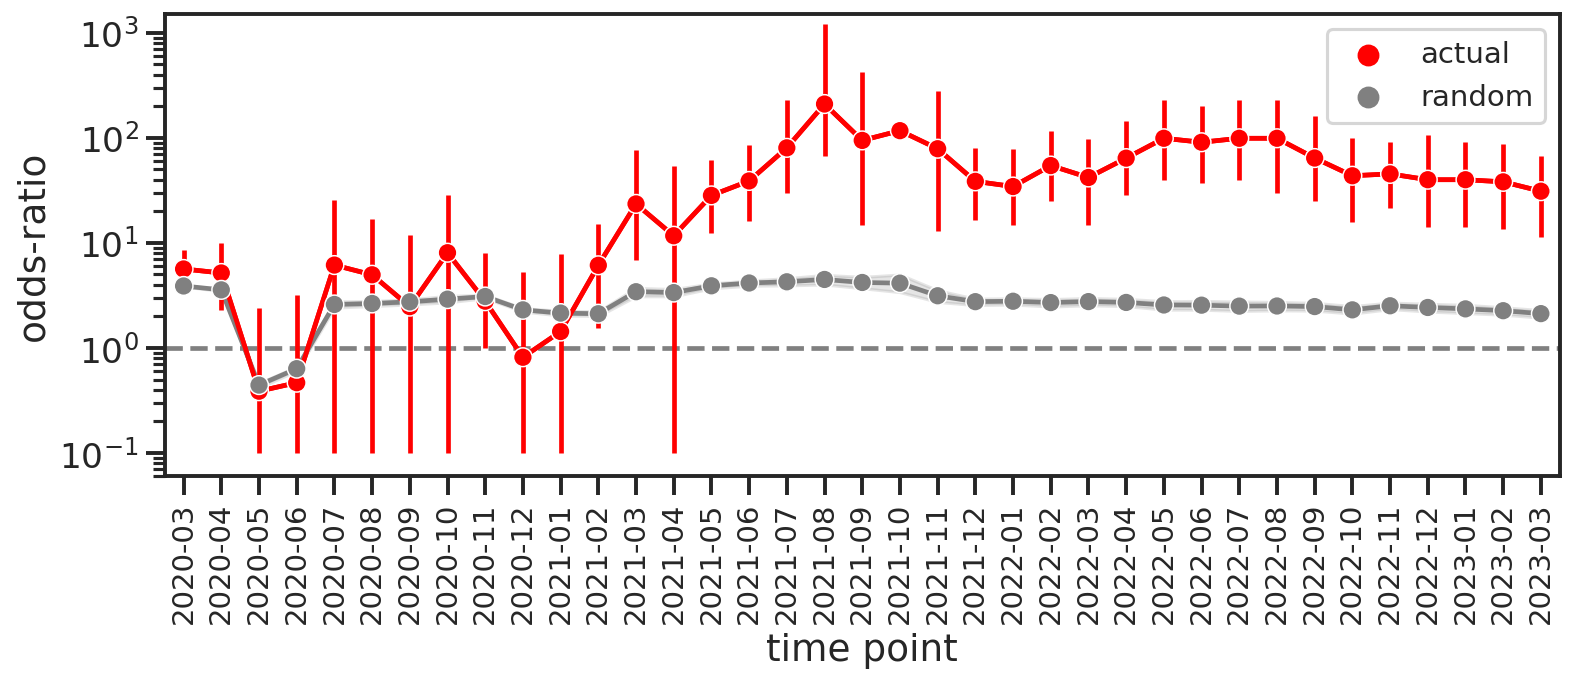

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(data=r,
             x='name',
             y='odds-ratio',
             hue='set',
             errorbar='ci',
             ax=ax,
             legend=False,
             palette=['r', 'grey'])
plt.errorbar(range(r['name'].unique().shape[0]),
             r[r['set'] == 'actual']['odds-ratio'],
             yerr=abs(r[r['set'] == 'actual'][['low', 'high']].T.values -
                      r[r['set'] == 'actual']['odds-ratio'].values + 0.1),
             color='r')
sns.scatterplot(data=r.groupby(['name', 'set'])[['odds-ratio']].mean().reset_index(),
                x='name',
                y='odds-ratio',
                hue='set',
                ax=ax,
                palette=['r', 'grey'],
                zorder=10)

plt.axhline(1,
            color='grey', ls='dashed', zorder=-1)

plt.legend(facecolor='w', fontsize=14)

plt.xticks(rotation=90,
           fontsize=14)
plt.xlabel('time point')

plt.xlim(-0.5, r['name'].unique().shape[0] - 0.5)

plt.ylim(0.06, 1500)

plt.yscale('log')

plt.savefig('time_4.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_4.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [18]:
res = []
for name in sorted(df['name'].unique()):
    print(name)
    year = int(name.split('-')[0])
    month = int(name.split('-')[1])
    
    s = df[df['name'] == name]

    ml = ml_metrics(s,
                    mutated=d_mutated[name],
                    shuffle=False)
    ml['name'] = name
    ml['set'] = 'actual'
    res.append(ml)

    # for i in range(100):
    #     with warnings.catch_warnings():
    #         warnings.simplefilter("ignore")
    #         ml = ml_metrics(s,
    #                         mutated=d_mutated[name],
    #                         shuffle=True)
    #         ml['name'] = name
    #         ml['set'] = 'random'
    #         res.append(ml)

m = pd.concat(res)

2020-03
2020-04
2020-05
2020-06
2020-07
2020-08
2020-09
2020-10
2020-11
2020-12
2021-01
2021-02
2021-03
2021-04
2021-05
2021-06
2021-07
2021-08
2021-09
2021-10
2021-11
2021-12
2022-01
2022-02
2022-03
2022-04
2022-05
2022-06
2022-07
2022-08
2022-09
2022-10
2022-11
2022-12
2023-01
2023-02
2023-03


/home/marco/miniconda3/envs/epistasis/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/marco/miniconda3/envs/epistasis/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


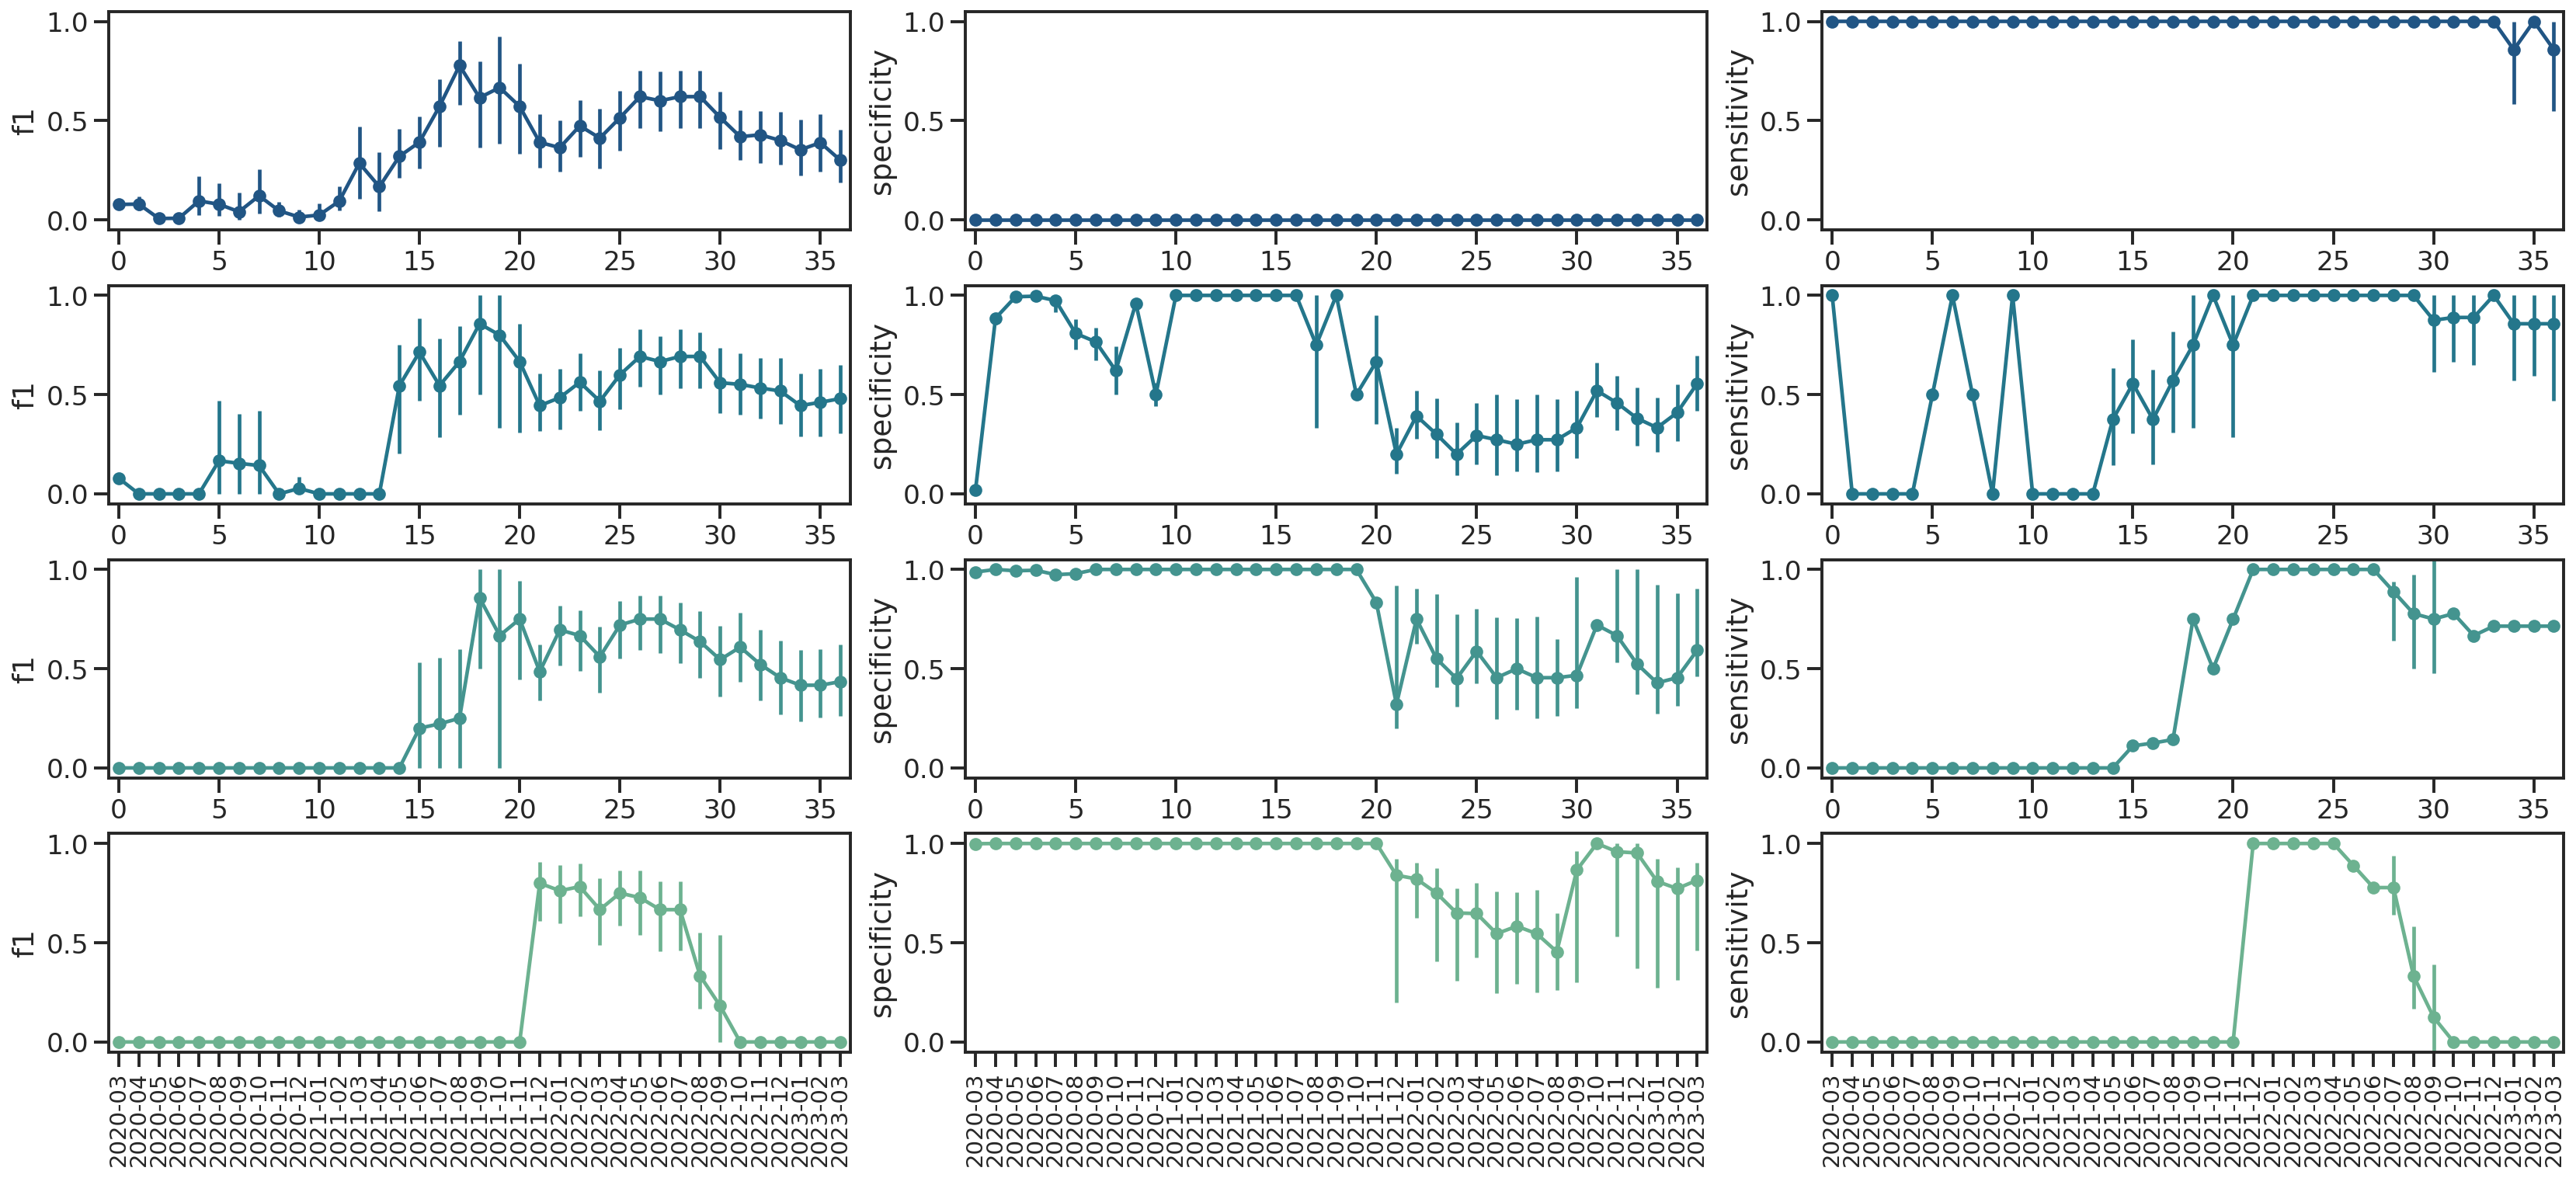

In [19]:
fig, axes = plt.subplots(4, 3, figsize=(22, 10),
                         constrained_layout=True)

for col, metric in zip(range(3),
                       ('f1', 'specificity', 'sensitivity')):
    for row, ol, color in zip(range(4), range(1, 5),
                              sns.color_palette('crest_r', 4)):
        ax = axes[row][col]
        t = m[(m['metric'] == metric) &
              (m['outlier'] == ol)]
        ax.errorbar(range(t['name'].unique().shape[0]),
                    t[t['set'] == 'actual']['value'],
                    yerr=abs(t[t['set'] == 'actual'][['low', 'high']].T.values -
                             t[t['set'] == 'actual']['value'].values),
                    color=color, zorder=-1, fmt='o-',
                    markersize=7)
        ax.set_ylim(-0.05, 1.05)
        ax.set_ylabel(metric)
        ax.set_xlim(-0.5, m['name'].unique().shape[0] - 0.5)
        if row == 3:
            ax.set_xticks(range(m['name'].unique().shape[0]),
                          labels=m['name'].unique(),
                          rotation=90,
                          fontsize=14)

plt.savefig('time_5.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_5.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [20]:
m[(m['metric'] == 'f1') &
  (m['outlier'] == 1)].groupby(['name', 'set'])[['value', 'low', 'high']].max()

value       low      high
name    set                                 
2020-03 actual  0.077519  0.061418  0.097534
2020-04 actual  0.079295  0.049217  0.118224
2020-05 actual  0.006689  0.000000  0.023217
2020-06 actual  0.008032  0.000000  0.023904
2020-07 actual  0.095238  0.024691  0.218203
2020-08 actual  0.078431  0.020202  0.185185
2020-09 actual  0.040816  0.000000  0.135922
2020-10 actual  0.121212  0.031746  0.253521
2020-11 actual  0.045455  0.015385  0.088889
2020-12 actual  0.013889  0.000000  0.049405
2021-01 actual  0.024096  0.000000  0.081871
2021-02 actual  0.094118  0.048193  0.169492
2021-03 actual  0.285714  0.105263  0.468085
2021-04 actual  0.166667  0.044444  0.339623
2021-05 actual  0.320000  0.212766  0.458716
2021-06 actual  0.391304  0.258824  0.520000
2021-07 actual  0.571429  0.367347  0.709677
2021-08 actual  0.777778  0.580645  0.900000
2021-09 actual  0.615385  0.363636  0.800000
2021-10 actual  0.666667  0.384794  0.925166
2021-11 actual  0.571429  0.333333  0.787879
2021-12 actual  0.390244  0.263158  0.533333
2022-01 actual  0.363636  0.243902  0.500000
2022-02 actual  0.473684  0.318841  0.602410
2022-03 actual  0.411765  0.258065  0.560000
2022-04 actual  0.514286  0.349206  0.649351
2022-05 actual  0.620690  0.461538  0.750000
2022-06 actual  0.600000  0.444444  0.746269
2022-07 actual  0.620690  0.461538  0.750000
2022-08 actual  0.620690  0.461538  0.750000
2022-09 actual  0.516129  0.357143  0.647059
2022-10 actual  0.418605  0.300000  0.553191
2022-11 actual  0.428571  0.285714  0.549451
2022-12 actual  0.400000  0.276923  0.545455
2023-01 actual  0.352941  0.222222  0.506667
2023-02 actual  0.388889  0.242424  0.531646
2023-03 actual  0.300000  0.186667  0.454545

In [21]:
m[(m['metric'] == 'f1') &
  (m['outlier'] == 2)].groupby(['name', 'set'])[['value', 'low', 'high']].max()

value       low      high
name    set                                 
2020-03 actual  0.078829  0.063673  0.097058
2020-04 actual  0.000000       NaN       NaN
2020-05 actual  0.000000       NaN       NaN
2020-06 actual  0.000000       NaN       NaN
2020-07 actual  0.000000       NaN       NaN
2020-08 actual  0.166667  0.000000  0.470770
2020-09 actual  0.153846  0.000000  0.402229
2020-10 actual  0.142857  0.000000  0.416667
2020-11 actual  0.000000       NaN       NaN
2020-12 actual  0.027397  0.000000  0.086451
2021-01 actual  0.000000       NaN       NaN
2021-02 actual  0.000000       NaN       NaN
2021-03 actual  0.000000       NaN       NaN
2021-04 actual  0.000000       NaN       NaN
2021-05 actual  0.545455  0.203606  0.750000
2021-06 actual  0.714286  0.470588  0.882353
2021-07 actual  0.545455  0.285714  0.781022
2021-08 actual  0.666667  0.400000  0.846154
2021-09 actual  0.857143  0.500000  1.000000
2021-10 actual  0.800000  0.333333  1.000000
2021-11 actual  0.666667  0.307692  0.857143
2021-12 actual  0.444444  0.317723  0.607932
2022-01 actual  0.484848  0.325301  0.631579
2022-02 actual  0.562500  0.418554  0.707395
2022-03 actual  0.466667  0.320000  0.620588
2022-04 actual  0.600000  0.424707  0.735294
2022-05 actual  0.692308  0.541667  0.830189
2022-06 actual  0.666667  0.500000  0.793103
2022-07 actual  0.692308  0.533333  0.827586
2022-08 actual  0.692308  0.530612  0.814815
2022-09 actual  0.560000  0.408163  0.734566
2022-10 actual  0.551724  0.400000  0.709055
2022-11 actual  0.533333  0.378462  0.684315
2022-12 actual  0.518519  0.352941  0.684145
2023-01 actual  0.444444  0.291053  0.606857
2023-02 actual  0.461538  0.289008  0.629630
2023-03 actual  0.480000  0.304348  0.648649

In [22]:
m[(m['metric'] == 'f1') &
  (m['outlier'] == 3)].groupby(['name', 'set'])[['value', 'low', 'high']].max()

value       low      high
name    set                                 
2020-03 actual  0.000000       NaN       NaN
2020-04 actual  0.000000       NaN       NaN
2020-05 actual  0.000000       NaN       NaN
2020-06 actual  0.000000       NaN       NaN
2020-07 actual  0.000000       NaN       NaN
2020-08 actual  0.000000       NaN       NaN
2020-09 actual  0.000000       NaN       NaN
2020-10 actual  0.000000       NaN       NaN
2020-11 actual  0.000000       NaN       NaN
2020-12 actual  0.000000       NaN       NaN
2021-01 actual  0.000000       NaN       NaN
2021-02 actual  0.000000       NaN       NaN
2021-03 actual  0.000000       NaN       NaN
2021-04 actual  0.000000       NaN       NaN
2021-05 actual  0.000000       NaN       NaN
2021-06 actual  0.200000  0.000000  0.531486
2021-07 actual  0.222222  0.000000  0.555556
2021-08 actual  0.250000  0.000000  0.600000
2021-09 actual  0.857143  0.500000  1.000000
2021-10 actual  0.666667  0.000000  1.000000
2021-11 actual  0.750000  0.444444  0.941176
2021-12 actual  0.484848  0.338983  0.620748
2022-01 actual  0.695652  0.514286  0.816327
2022-02 actual  0.666667  0.488144  0.793103
2022-03 actual  0.560000  0.380952  0.711249
2022-04 actual  0.720000  0.553191  0.842209
2022-05 actual  0.750000  0.595403  0.867459
2022-06 actual  0.750000  0.578811  0.869565
2022-07 actual  0.695652  0.526316  0.831357
2022-08 actual  0.636364  0.454545  0.790698
2022-09 actual  0.545455  0.358974  0.716981
2022-10 actual  0.608696  0.432987  0.782609
2022-11 actual  0.521739  0.341249  0.697735
2022-12 actual  0.454545  0.270270  0.640000
2023-01 actual  0.416667  0.232558  0.592527
2023-02 actual  0.416667  0.255319  0.596491
2023-03 actual  0.434783  0.262556  0.620640

In [23]:
m[(m['metric'] == 'f1') &
  (m['outlier'] == 4)].groupby(['name', 'set'])[['value', 'low', 'high']].max()

value       low      high
name    set                                 
2020-03 actual  0.000000       NaN       NaN
2020-04 actual  0.000000       NaN       NaN
2020-05 actual  0.000000       NaN       NaN
2020-06 actual  0.000000       NaN       NaN
2020-07 actual  0.000000       NaN       NaN
2020-08 actual  0.000000       NaN       NaN
2020-09 actual  0.000000       NaN       NaN
2020-10 actual  0.000000       NaN       NaN
2020-11 actual  0.000000       NaN       NaN
2020-12 actual  0.000000       NaN       NaN
2021-01 actual  0.000000       NaN       NaN
2021-02 actual  0.000000       NaN       NaN
2021-03 actual  0.000000       NaN       NaN
2021-04 actual  0.000000       NaN       NaN
2021-05 actual  0.000000       NaN       NaN
2021-06 actual  0.000000       NaN       NaN
2021-07 actual  0.000000       NaN       NaN
2021-08 actual  0.000000       NaN       NaN
2021-09 actual  0.000000       NaN       NaN
2021-10 actual  0.000000       NaN       NaN
2021-11 actual  0.000000       NaN       NaN
2021-12 actual  0.800000  0.609043  0.905340
2022-01 actual  0.761905  0.599500  0.892917
2022-02 actual  0.782609  0.634574  0.898602
2022-03 actual  0.666667  0.486486  0.826087
2022-04 actual  0.750000  0.585720  0.862441
2022-05 actual  0.727273  0.540541  0.862865
2022-06 actual  0.666667  0.457143  0.808835
2022-07 actual  0.666667  0.461538  0.808511
2022-08 actual  0.333333  0.166667  0.550000
2022-09 actual  0.181818  0.000000  0.538692
2022-10 actual  0.000000       NaN       NaN
2022-11 actual  0.000000       NaN       NaN
2022-12 actual  0.000000       NaN       NaN
2023-01 actual  0.000000       NaN       NaN
2023-02 actual  0.000000       NaN       NaN
2023-03 actual  0.000000       NaN       NaN

In [24]:
m[(m['metric'] == 'specificity') &
  (m['outlier'] == 1)].groupby(['name', 'set'])[['value', 'low', 'high']].max()

value  low  high
name    set                     
2020-03 actual    0.0  NaN   NaN
2020-04 actual    0.0  NaN   NaN
2020-05 actual    0.0  NaN   NaN
2020-06 actual    0.0  NaN   NaN
2020-07 actual    0.0  NaN   NaN
2020-08 actual    0.0  NaN   NaN
2020-09 actual    0.0  NaN   NaN
2020-10 actual    0.0  NaN   NaN
2020-11 actual    0.0  NaN   NaN
2020-12 actual    0.0  NaN   NaN
2021-01 actual    0.0  NaN   NaN
2021-02 actual    0.0  NaN   NaN
2021-03 actual    0.0  NaN   NaN
2021-04 actual    0.0  NaN   NaN
2021-05 actual    0.0  NaN   NaN
2021-06 actual    0.0  NaN   NaN
2021-07 actual    0.0  NaN   NaN
2021-08 actual    0.0  NaN   NaN
2021-09 actual    0.0  NaN   NaN
2021-10 actual    0.0  NaN   NaN
2021-11 actual    0.0  NaN   NaN
2021-12 actual    0.0  NaN   NaN
2022-01 actual    0.0  NaN   NaN
2022-02 actual    0.0  NaN   NaN
2022-03 actual    0.0  NaN   NaN
2022-04 actual    0.0  NaN   NaN
2022-05 actual    0.0  NaN   NaN
2022-06 actual    0.0  NaN   NaN
2022-07 actual    0.0  NaN   NaN
2022-08 actual    0.0  NaN   NaN
2022-09 actual    0.0  NaN   NaN
2022-10 actual    0.0  NaN   NaN
2022-11 actual    0.0  NaN   NaN
2022-12 actual    0.0  NaN   NaN
2023-01 actual    0.0  NaN   NaN
2023-02 actual    0.0  NaN   NaN
2023-03 actual    0.0  NaN   NaN

In [25]:
m[(m['metric'] == 'specificity') &
  (m['outlier'] == 2)].groupby(['name', 'set'])[['value', 'low', 'high']].max()

value       low      high
name    set                                 
2020-03 actual  0.018007  0.012546  0.025819
2020-04 actual  0.885167  0.852080  0.913349
2020-05 actual  0.993266       NaN       NaN
2020-06 actual  0.995951       NaN       NaN
2020-07 actual  0.973684  0.916469  1.000000
2020-08 actual  0.808511  0.728261  0.880435
2020-09 actual  0.765957  0.673684  0.838710
2020-10 actual  0.620690  0.500000  0.743169
2020-11 actual  0.960317  0.932089  0.980159
2020-12 actual  0.500000  0.443253  0.558304
2021-01 actual  1.000000       NaN       NaN
2021-02 actual  1.000000       NaN       NaN
2021-03 actual  1.000000       NaN       NaN
2021-04 actual  1.000000       NaN       NaN
2021-05 actual  1.000000       NaN       NaN
2021-06 actual  1.000000       NaN       NaN
2021-07 actual  1.000000       NaN       NaN
2021-08 actual  0.750000  0.333333  1.000000
2021-09 actual  1.000000       NaN       NaN
2021-10 actual  0.500000       NaN       NaN
2021-11 actual  0.666667  0.352926  0.900000
2021-12 actual  0.200000  0.102041  0.333333
2022-01 actual  0.392857  0.275862  0.518519
2022-02 actual  0.300000  0.181818  0.481593
2022-03 actual  0.200000  0.095238  0.358519
2022-04 actual  0.294118  0.147059  0.456185
2022-05 actual  0.272727  0.095238  0.500000
2022-06 actual  0.250000  0.115385  0.476190
2022-07 actual  0.272727  0.111111  0.500000
2022-08 actual  0.272727  0.115385  0.476064
2022-09 actual  0.333333  0.178571  0.518519
2022-10 actual  0.520000  0.389169  0.659621
2022-11 actual  0.458333  0.318968  0.593482
2022-12 actual  0.380952  0.243902  0.536585
2023-01 actual  0.333333  0.209302  0.486050
2023-02 actual  0.409091  0.265966  0.552632
2023-03 actual  0.555556  0.418182  0.696954

In [26]:
m[(m['metric'] == 'specificity') &
  (m['outlier'] == 3)].groupby(['name', 'set'])[['value', 'low', 'high']].max()

value       low      high
name    set                                 
2020-03 actual  0.986795  0.980144  1.000000
2020-04 actual  1.000000       NaN       NaN
2020-05 actual  0.993266       NaN       NaN
2020-06 actual  0.995951       NaN       NaN
2020-07 actual  0.973684       NaN       NaN
2020-08 actual  0.978723       NaN       NaN
2020-09 actual  1.000000       NaN       NaN
2020-10 actual  1.000000       NaN       NaN
2020-11 actual  1.000000       NaN       NaN
2020-12 actual  1.000000       NaN       NaN
2021-01 actual  1.000000       NaN       NaN
2021-02 actual  1.000000       NaN       NaN
2021-03 actual  1.000000       NaN       NaN
2021-04 actual  1.000000       NaN       NaN
2021-05 actual  1.000000       NaN       NaN
2021-06 actual  1.000000       NaN       NaN
2021-07 actual  1.000000       NaN       NaN
2021-08 actual  1.000000       NaN       NaN
2021-09 actual  1.000000       NaN       NaN
2021-10 actual  1.000000       NaN       NaN
2021-11 actual  0.833333  0.500000       NaN
2021-12 actual  0.320000  0.199237  0.920773
2022-01 actual  0.750000  0.625000  0.901736
2022-02 actual  0.550000  0.404999  0.875000
2022-03 actual  0.450000  0.309524  0.775000
2022-04 actual  0.588235  0.424770  0.800000
2022-05 actual  0.454545  0.246713  0.760000
2022-06 actual  0.500000  0.292628  0.754965
2022-07 actual  0.454545  0.250000  0.764182
2022-08 actual  0.454545  0.261224  0.650000
2022-09 actual  0.466667  0.300000  0.962963
2022-10 actual  0.720000  0.578830       NaN
2022-11 actual  0.666667  0.530612  1.000000
2022-12 actual  0.523810  0.372093  1.000000
2023-01 actual  0.428571  0.275000  0.921053
2023-02 actual  0.454545  0.310803  0.880698
2023-03 actual  0.592593  0.460000  0.903846

In [27]:
m[(m['metric'] == 'specificity') &
  (m['outlier'] == 4)].groupby(['name', 'set'])[['value', 'low', 'high']].max()

value       low      high
name    set                                 
2020-03 actual  0.998800  0.980144  1.000000
2020-04 actual  1.000000       NaN       NaN
2020-05 actual  1.000000       NaN       NaN
2020-06 actual  1.000000       NaN       NaN
2020-07 actual  1.000000       NaN       NaN
2020-08 actual  1.000000       NaN       NaN
2020-09 actual  1.000000       NaN       NaN
2020-10 actual  1.000000       NaN       NaN
2020-11 actual  1.000000       NaN       NaN
2020-12 actual  1.000000       NaN       NaN
2021-01 actual  1.000000       NaN       NaN
2021-02 actual  1.000000       NaN       NaN
2021-03 actual  1.000000       NaN       NaN
2021-04 actual  1.000000       NaN       NaN
2021-05 actual  1.000000       NaN       NaN
2021-06 actual  1.000000       NaN       NaN
2021-07 actual  1.000000       NaN       NaN
2021-08 actual  1.000000       NaN       NaN
2021-09 actual  1.000000       NaN       NaN
2021-10 actual  1.000000       NaN       NaN
2021-11 actual  1.000000  0.500000       NaN
2021-12 actual  0.840000  0.199237  0.920773
2022-01 actual  0.821429  0.625000  0.901736
2022-02 actual  0.750000  0.404999  0.875000
2022-03 actual  0.650000  0.309524  0.775000
2022-04 actual  0.647059  0.424770  0.800000
2022-05 actual  0.545455  0.246713  0.760000
2022-06 actual  0.583333  0.292628  0.754965
2022-07 actual  0.545455  0.250000  0.764182
2022-08 actual  0.454545  0.261224  0.650000
2022-09 actual  0.866667  0.300000  0.962963
2022-10 actual  1.000000  0.578830       NaN
2022-11 actual  0.958333  0.530612  1.000000
2022-12 actual  0.952381  0.372093  1.000000
2023-01 actual  0.809524  0.275000  0.921053
2023-02 actual  0.772727  0.310803  0.880698
2023-03 actual  0.814815  0.460000  0.903846

In [28]:
m[(m['metric'] == 'sensitivity') &
  (m['outlier'] == 1)].groupby(['name', 'set'])[['value', 'low', 'high']].max()

value       low  high
name    set                             
2020-03 actual  1.000000       NaN   NaN
2020-04 actual  1.000000       NaN   NaN
2020-05 actual  1.000000       NaN   NaN
2020-06 actual  1.000000       NaN   NaN
2020-07 actual  1.000000       NaN   NaN
2020-08 actual  1.000000       NaN   NaN
2020-09 actual  1.000000       NaN   NaN
2020-10 actual  1.000000       NaN   NaN
2020-11 actual  1.000000       NaN   NaN
2020-12 actual  1.000000       NaN   NaN
2021-01 actual  1.000000       NaN   NaN
2021-02 actual  1.000000       NaN   NaN
2021-03 actual  1.000000       NaN   NaN
2021-04 actual  1.000000       NaN   NaN
2021-05 actual  1.000000       NaN   NaN
2021-06 actual  1.000000       NaN   NaN
2021-07 actual  1.000000       NaN   NaN
2021-08 actual  1.000000       NaN   NaN
2021-09 actual  1.000000       NaN   NaN
2021-10 actual  1.000000       NaN   NaN
2021-11 actual  1.000000       NaN   NaN
2021-12 actual  1.000000       NaN   NaN
2022-01 actual  1.000000       NaN   NaN
2022-02 actual  1.000000       NaN   NaN
2022-03 actual  1.000000       NaN   NaN
2022-04 actual  1.000000       NaN   NaN
2022-05 actual  1.000000       NaN   NaN
2022-06 actual  1.000000       NaN   NaN
2022-07 actual  1.000000       NaN   NaN
2022-08 actual  1.000000       NaN   NaN
2022-09 actual  1.000000       NaN   NaN
2022-10 actual  1.000000       NaN   NaN
2022-11 actual  1.000000       NaN   NaN
2022-12 actual  1.000000       NaN   NaN
2023-01 actual  0.857143  0.583333   1.0
2023-02 actual  1.000000       NaN   NaN
2023-03 actual  0.857143  0.549342   1.0

In [29]:
m[(m['metric'] == 'sensitivity') &
  (m['outlier'] == 2)].groupby(['name', 'set'])[['value', 'low', 'high']].max()

value       low      high
name    set                                 
2020-03 actual  1.000000       NaN       NaN
2020-04 actual  0.000000       NaN       NaN
2020-05 actual  0.000000       NaN       NaN
2020-06 actual  0.000000       NaN       NaN
2020-07 actual  0.000000       NaN       NaN
2020-08 actual  0.500000       NaN       NaN
2020-09 actual  1.000000       NaN       NaN
2020-10 actual  0.500000       NaN       NaN
2020-11 actual  0.000000       NaN       NaN
2020-12 actual  1.000000       NaN       NaN
2021-01 actual  0.000000       NaN       NaN
2021-02 actual  0.000000       NaN       NaN
2021-03 actual  0.000000       NaN       NaN
2021-04 actual  0.000000       NaN       NaN
2021-05 actual  0.375000  0.142857  0.634767
2021-06 actual  0.555556  0.304849  0.777778
2021-07 actual  0.375000  0.150000  0.625000
2021-08 actual  0.571429  0.307692  0.818182
2021-09 actual  0.750000  0.333333  1.000000
2021-10 actual  1.000000       NaN       NaN
2021-11 actual  0.750000  0.285608  1.000000
2021-12 actual  1.000000       NaN       NaN
2022-01 actual  1.000000       NaN       NaN
2022-02 actual  1.000000       NaN       NaN
2022-03 actual  1.000000       NaN       NaN
2022-04 actual  1.000000       NaN       NaN
2022-05 actual  1.000000       NaN       NaN
2022-06 actual  1.000000       NaN       NaN
2022-07 actual  1.000000       NaN       NaN
2022-08 actual  1.000000       NaN       NaN
2022-09 actual  0.875000  0.613901  1.000000
2022-10 actual  0.888889  0.666667  1.000000
2022-11 actual  0.888889  0.649770  1.000000
2022-12 actual  1.000000       NaN       NaN
2023-01 actual  0.857143  0.571429  1.000000
2023-02 actual  0.857143  0.593026  1.000000
2023-03 actual  0.857143  0.470018  1.000000

In [30]:
m[(m['metric'] == 'sensitivity') &
  (m['outlier'] == 3)].groupby(['name', 'set'])[['value', 'low', 'high']].max()

value       low      high
name    set                                 
2020-03 actual  0.000000       NaN       NaN
2020-04 actual  0.000000       NaN       NaN
2020-05 actual  0.000000       NaN       NaN
2020-06 actual  0.000000       NaN       NaN
2020-07 actual  0.000000       NaN       NaN
2020-08 actual  0.000000       NaN       NaN
2020-09 actual  0.000000       NaN       NaN
2020-10 actual  0.000000       NaN       NaN
2020-11 actual  0.000000       NaN       NaN
2020-12 actual  0.000000       NaN       NaN
2021-01 actual  0.000000       NaN       NaN
2021-02 actual  0.000000       NaN       NaN
2021-03 actual  0.000000       NaN       NaN
2021-04 actual  0.000000       NaN       NaN
2021-05 actual  0.000000       NaN       NaN
2021-06 actual  0.111111  0.000000       NaN
2021-07 actual  0.125000  0.000000       NaN
2021-08 actual  0.142857  0.000000       NaN
2021-09 actual  0.750000  0.233698       NaN
2021-10 actual  0.500000       NaN       NaN
2021-11 actual  0.750000  0.333333       NaN
2021-12 actual  1.000000       NaN       NaN
2022-01 actual  1.000000       NaN       NaN
2022-02 actual  1.000000       NaN       NaN
2022-03 actual  1.000000       NaN       NaN
2022-04 actual  1.000000       NaN       NaN
2022-05 actual  1.000000       NaN  1.000000
2022-06 actual  1.000000       NaN  0.931385
2022-07 actual  0.888889  0.642829  0.937500
2022-08 actual  0.777778  0.500000  0.583229
2022-09 actual  0.750000  0.476063  0.391349
2022-10 actual  0.777778  0.518594       NaN
2022-11 actual  0.666667  0.421053       NaN
2022-12 actual  0.714286  0.400000       NaN
2023-01 actual  0.714286  0.444444       NaN
2023-02 actual  0.714286  0.428184       NaN
2023-03 actual  0.714286  0.436079       NaN

In [31]:
m[(m['metric'] == 'sensitivity') &
  (m['outlier'] == 4)].groupby(['name', 'set'])[['value', 'low', 'high']].max()

value       low      high
name    set                                 
2020-03 actual  0.000000       NaN       NaN
2020-04 actual  0.000000       NaN       NaN
2020-05 actual  0.000000       NaN       NaN
2020-06 actual  0.000000       NaN       NaN
2020-07 actual  0.000000       NaN       NaN
2020-08 actual  0.000000       NaN       NaN
2020-09 actual  0.000000       NaN       NaN
2020-10 actual  0.000000       NaN       NaN
2020-11 actual  0.000000       NaN       NaN
2020-12 actual  0.000000       NaN       NaN
2021-01 actual  0.000000       NaN       NaN
2021-02 actual  0.000000       NaN       NaN
2021-03 actual  0.000000       NaN       NaN
2021-04 actual  0.000000       NaN       NaN
2021-05 actual  0.000000       NaN       NaN
2021-06 actual  0.000000  0.000000       NaN
2021-07 actual  0.000000  0.000000       NaN
2021-08 actual  0.000000  0.000000       NaN
2021-09 actual  0.000000  0.233698       NaN
2021-10 actual  0.000000       NaN       NaN
2021-11 actual  0.000000  0.333333       NaN
2021-12 actual  1.000000       NaN       NaN
2022-01 actual  1.000000       NaN       NaN
2022-02 actual  1.000000       NaN       NaN
2022-03 actual  1.000000       NaN       NaN
2022-04 actual  1.000000       NaN       NaN
2022-05 actual  0.888889       NaN  1.000000
2022-06 actual  0.777778       NaN  0.931385
2022-07 actual  0.777778  0.642829  0.937500
2022-08 actual  0.333333  0.500000  0.583229
2022-09 actual  0.125000  0.476063  0.391349
2022-10 actual  0.000000  0.518594       NaN
2022-11 actual  0.000000  0.421053       NaN
2022-12 actual  0.000000  0.400000       NaN
2023-01 actual  0.000000  0.444444       NaN
2023-02 actual  0.000000  0.428184       NaN
2023-03 actual  0.000000  0.436079       NaN

In [32]:
dist = df.groupby(['name', 'outlier'])['distance'].mean().reset_index()

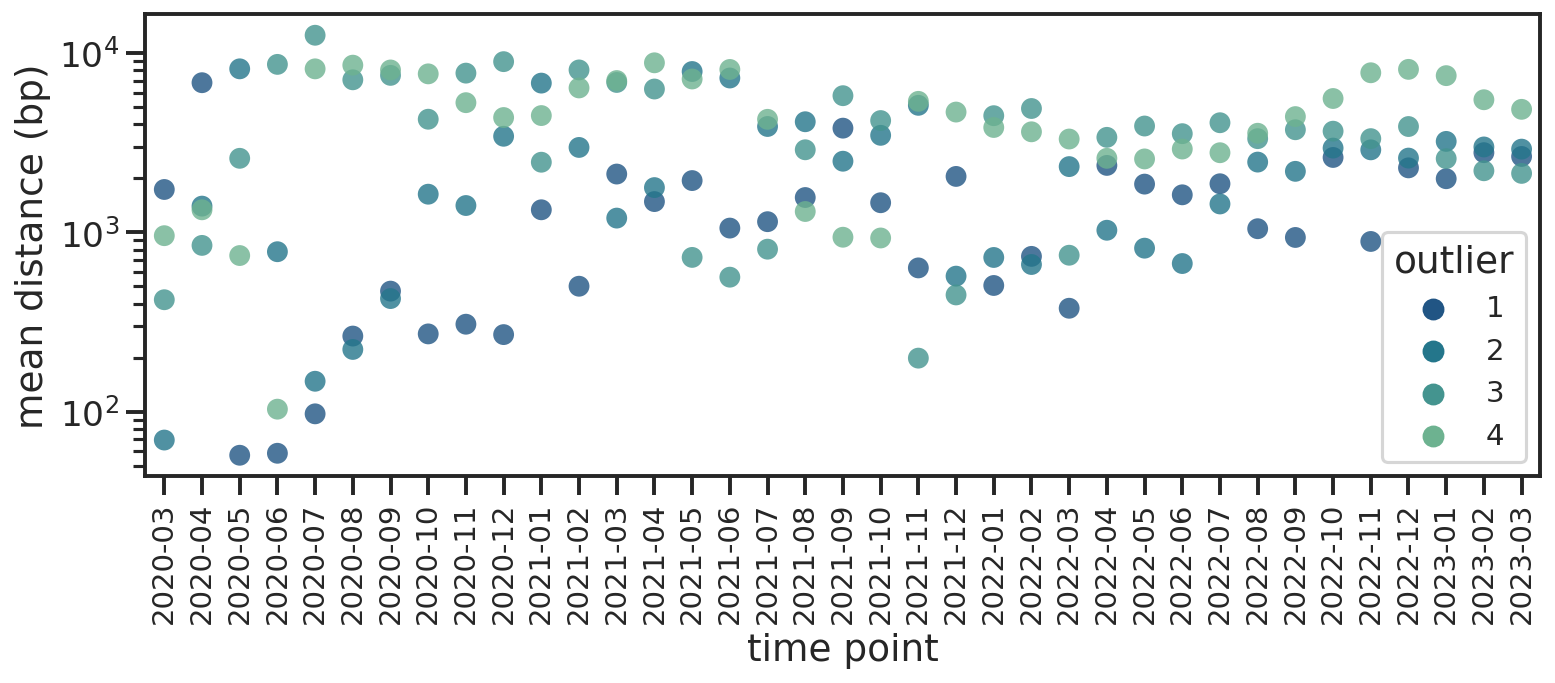

In [33]:
plt.figure(figsize=(12, 4))

sns.stripplot(data=dist,
              y='distance',
              x='name',
              hue='outlier',
              size=10,
              jitter=0,
              alpha=0.8,
              palette=sns.color_palette('crest_r', 4))

plt.xticks(rotation=90,
           size=14)

plt.legend(facecolor='w',
           title='outlier',
           fontsize=14)

plt.ylabel('mean distance (bp)')
plt.xlabel('time point')

plt.yscale('log')

plt.savefig('time_6.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_6.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [34]:
dist = df.groupby(['name', 'outlier'])['distance'].median().reset_index()

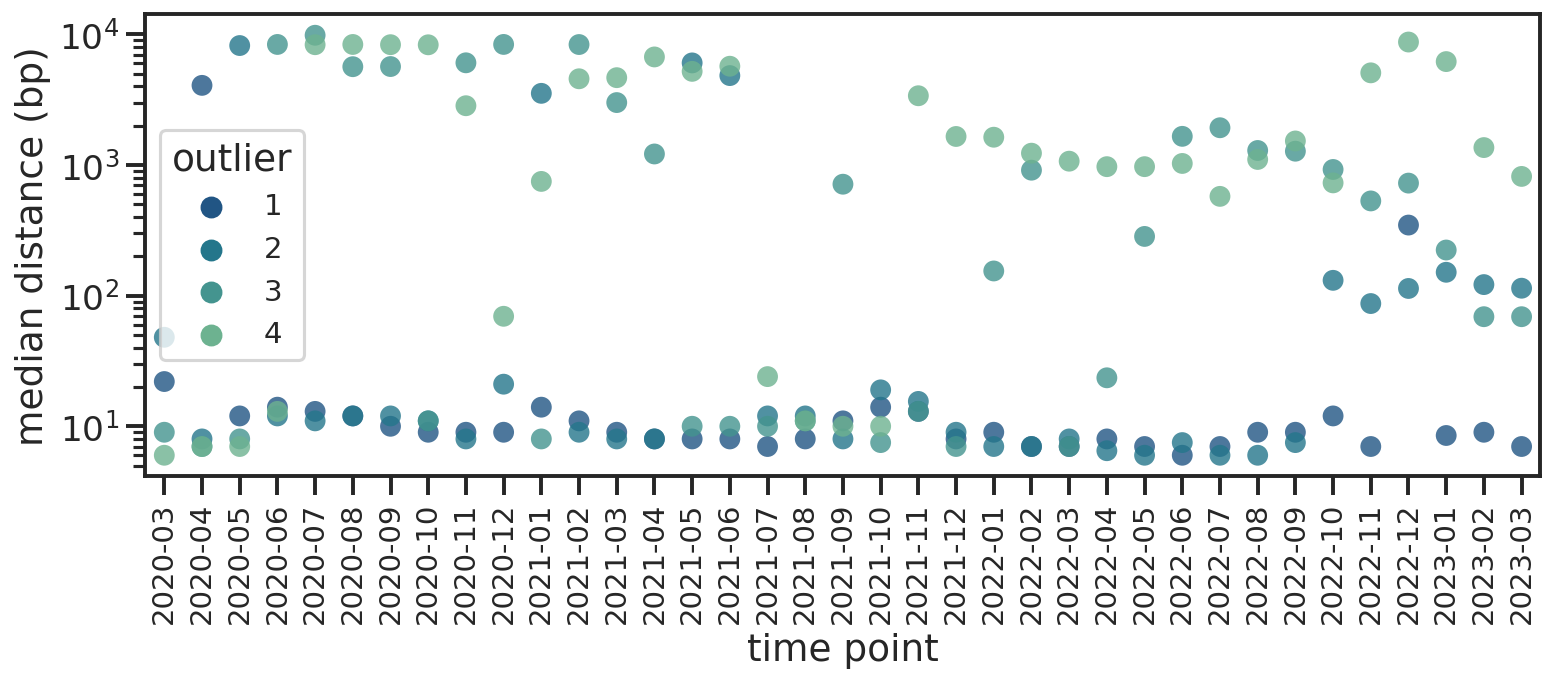

In [35]:
plt.figure(figsize=(12, 4))

sns.stripplot(data=dist,
              y='distance',
              x='name',
              hue='outlier',
              size=10,
              jitter=0,
              alpha=0.8,
              palette=sns.color_palette('crest_r', 4))

plt.xticks(rotation=90,
           size=14)

plt.legend(facecolor='w',
           title='outlier',
           fontsize=14)

plt.ylabel('median distance (bp)')
plt.xlabel('time point')

plt.yscale('log')

plt.savefig('time_7.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_7.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [36]:
s1 = df[(~df['name'].isin(['2020-02',
                           # '2020-03'
                          ])) &
        (df['gene_source'] == 'S') &
        (df['gene_target'] == 'S') &
        ((df['feature_codon_source'] == 501) &
         (df['feature_codon_target'] == 498))].copy()

s1 = s1.pivot_table(index=['feature_codon_source',
                          'feature_codon_target'],
                   columns='name',
                   values='outlier',
                   aggfunc=max).reindex(columns=sorted(df[~df['name'].isin(['2020-02',
                                                                            # '2020-03'
                                                                           ])]['name'].unique()))

In [37]:
s2 = df[(~df['name'].isin(['2020-02',
                           # '2020-03'
                          ])) &
        (df['gene_source'] == 'S') &
        (df['gene_target'] == 'S') &
        ((df['feature_codon_source'].isin(AFFINITY)) &
         (df['feature_codon_target'].isin(INTERESTING.difference(AFFINITY))))].copy()

s2 = s2.pivot_table(index=['feature_codon_source',
                          'feature_codon_target'],
                   columns='name',
                   values='outlier',
                   aggfunc=max).reindex(columns=sorted(df[~df['name'].isin(['2020-02',
                                                                            # '2020-03'
                                                                           ])]['name'].unique()))

In [38]:
s3 = df[(~df['name'].isin(['2020-02',
                           # '2020-03'
                          ])) &
        (df['gene_source'] == 'S') &
        (df['gene_target'] == 'S') &
        ((df['feature_codon_source'].isin(INTERESTING.difference(AFFINITY))) &
         (df['feature_codon_target'].isin(INTERESTING.difference(AFFINITY))))].copy()

s3 = s3.pivot_table(index=['feature_codon_source',
                          'feature_codon_target'],
                   columns='name',
                   values='outlier',
                   aggfunc=max).reindex(columns=sorted(df[~df['name'].isin(['2020-02',
                                                                            # '2020-03'
                                                                           ])]['name'].unique()))

In [39]:
s = pd.concat([s1, s2])

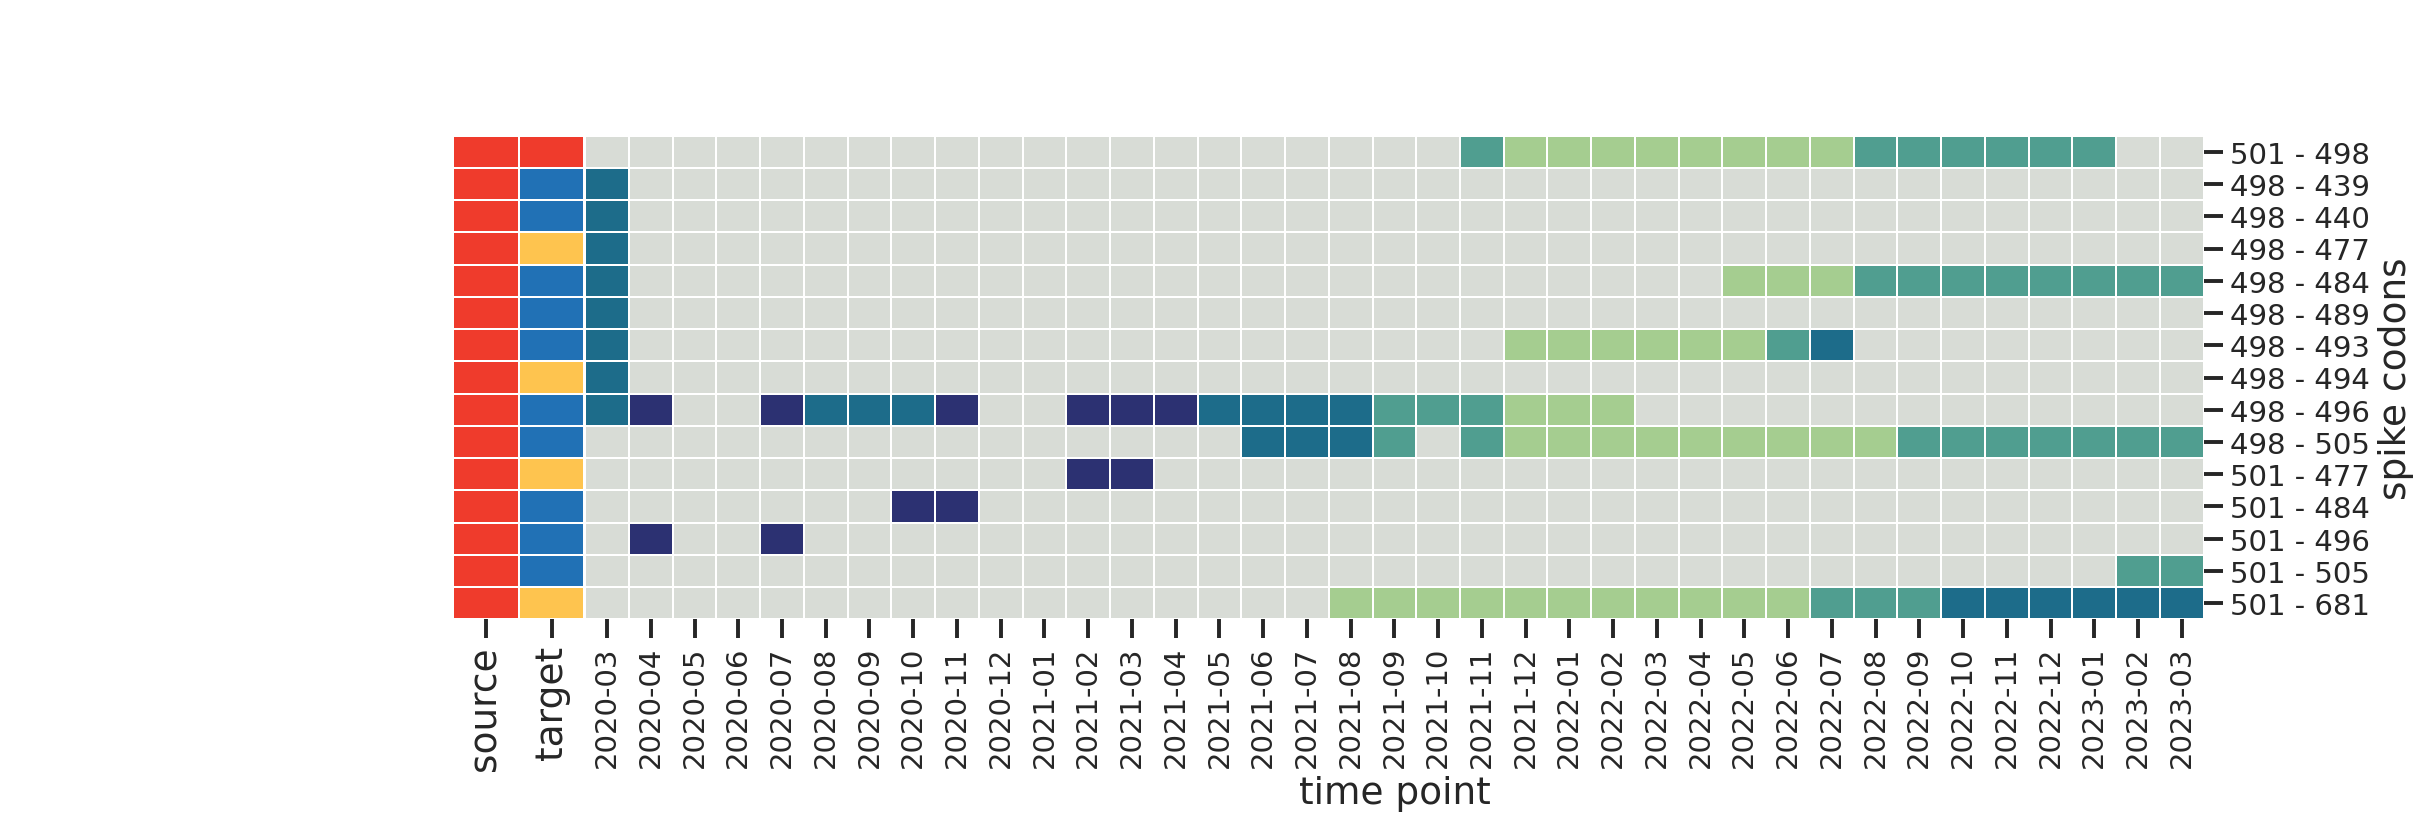

In [40]:
cmap = plt.get_cmap('crest_r').copy()
cmap.set_bad('xkcd:light grey')

colors1 = []
colors2 = []
for x, y in s.index:
    if x in AFFINITY:
        colors1.append('#ef3b2cff')
    elif x in ESCAPE:
        colors1.append('#2171b5ff')
    elif x in MOI:
        colors1.append('#fec44fff')
    else:
        colors1.append('xkcd:grey')

    if y in AFFINITY:
        colors2.append('#ef3b2cff')
    elif y in ESCAPE:
        colors2.append('#2171b5ff')
    elif y in MOI:
        colors2.append('#fec44fff')
    else:
        colors2.append('xkcd:grey')

cm = sns.clustermap(s, cmap=cmap,
                    row_cluster=False, col_cluster=False,
                    row_colors=pd.DataFrame([[a, b] for a, b in zip(colors1, colors2)],
                                            columns=['source', 'target'],
                                            index=s.index),
                    linewidths=0.005,
                    cbar_pos=None,
                    figsize=(17, 6),
                    vmin=1, vmax=4)

cm.ax_heatmap.set_xlabel('time point')
cm.ax_heatmap.set_ylabel('spike codons')

cm.ax_heatmap.set_xticks([x + 0.5 for x in range(s.shape[1])],
                         s.columns,
                         fontsize=14)
cm.ax_heatmap.set_yticks([x + 0.5 for x in range(s.shape[0])],
                         [f'{int(x)} - {int(y)}' for x, y in s.index],
                         fontsize=14)

cm.ax_row_colors.set_xticks([0.5, 1.5],
                            ['source', 'target'],
                            fontsize=18)

plt.savefig('time_8.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_8.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [41]:
s = df[(df['gene_source'] == 'S') &
       (df['gene_target'] == 'S') &
       ((df['feature_codon_source'].isin(INTERESTING)) |
        (df['feature_codon_target'].isin(INTERESTING)))].copy()

/home/marco/miniconda3/envs/epistasis/lib/python3.11/site-packages/seaborn/matrix.py:715: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self._figure = plt.figure(figsize=figsize)


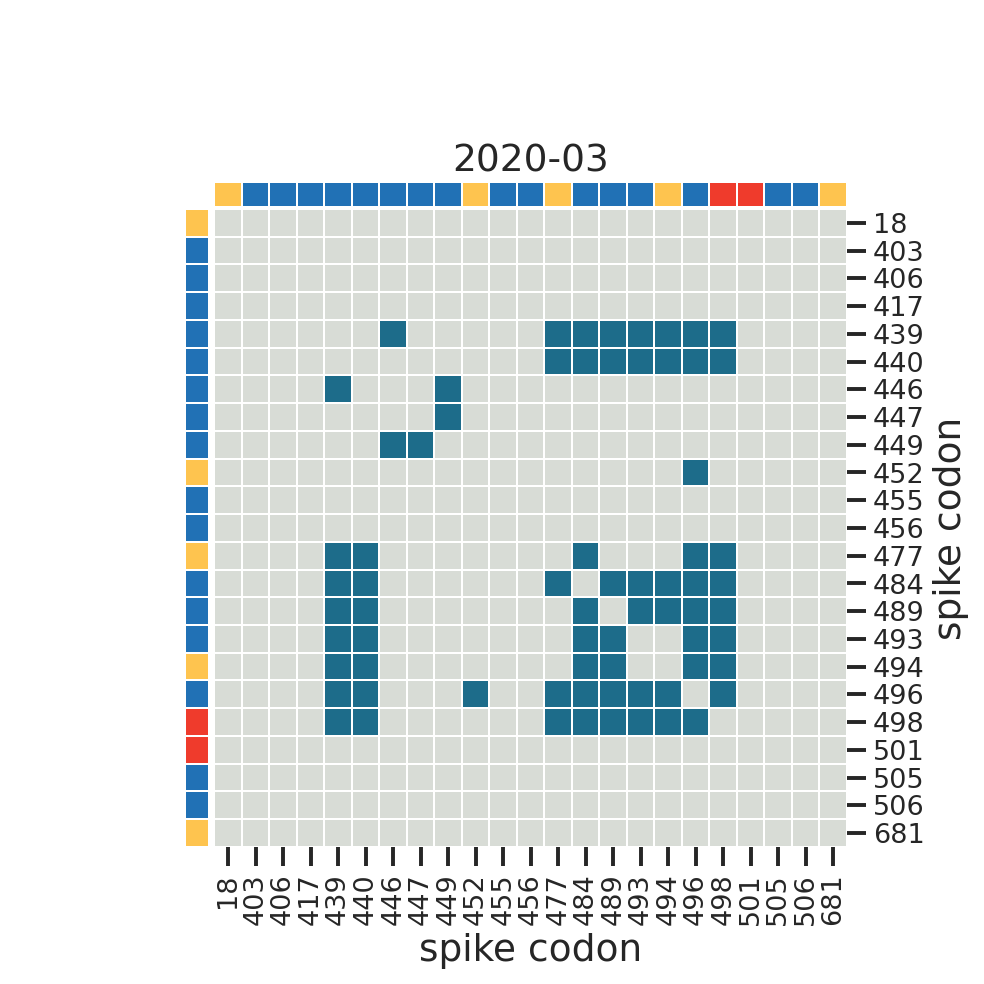

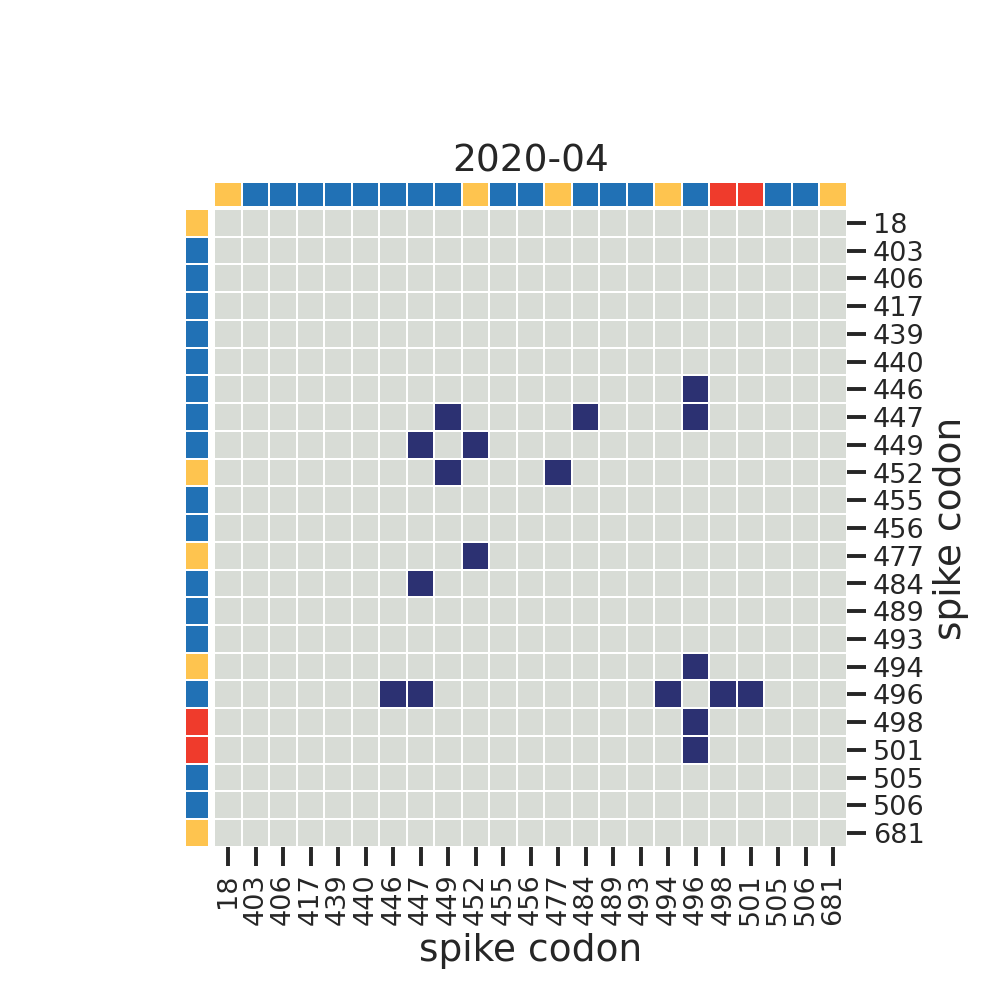

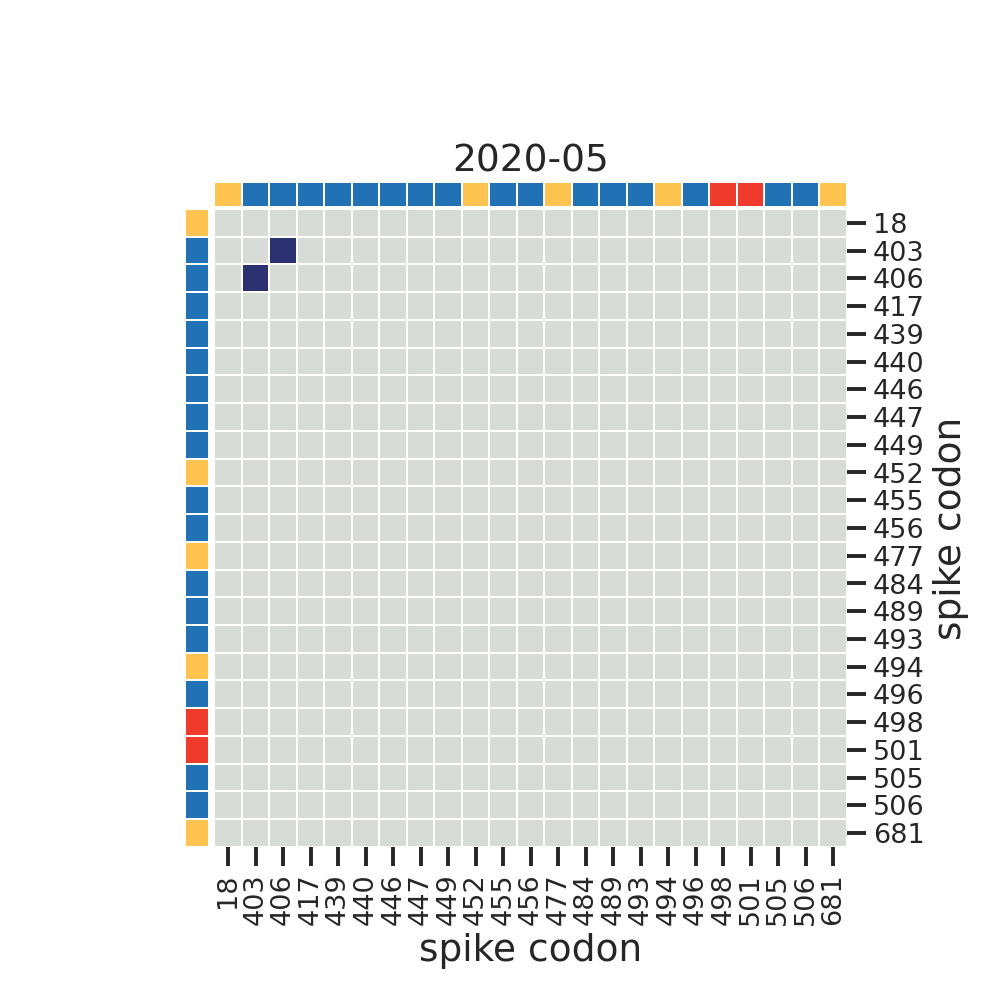

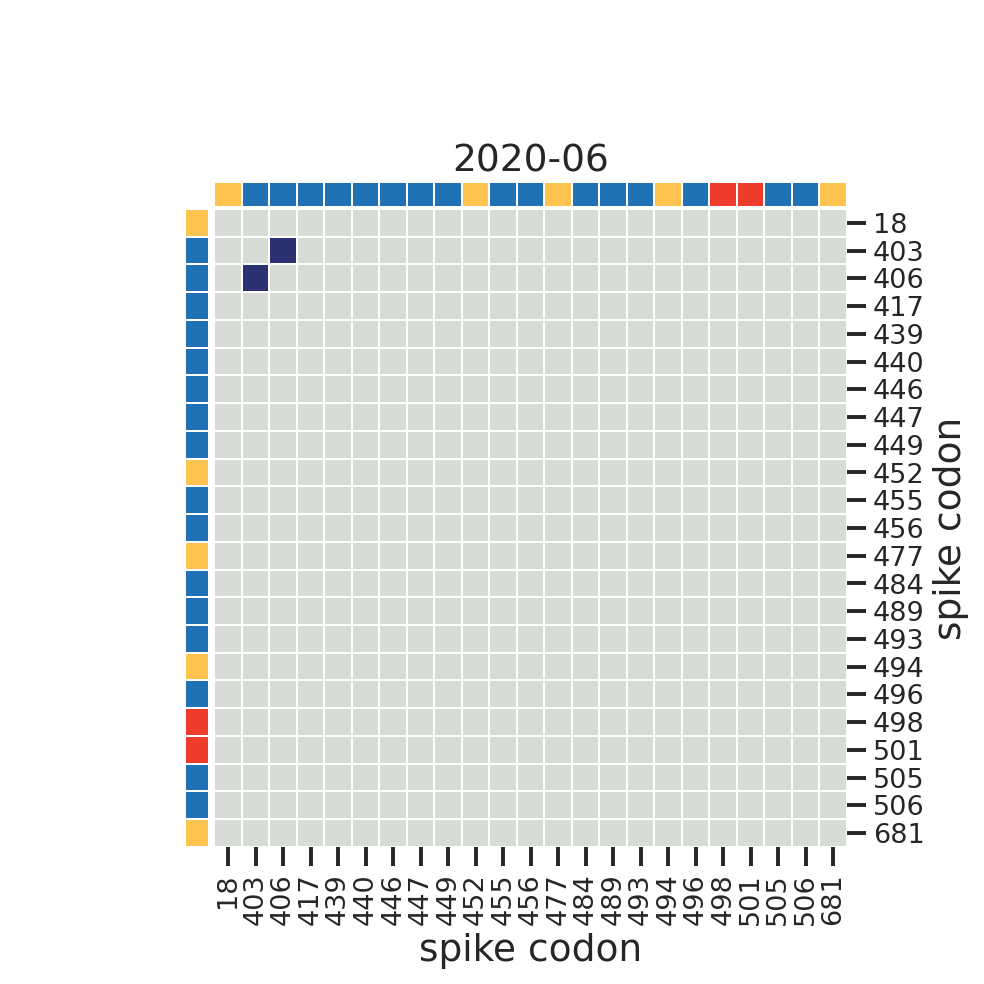

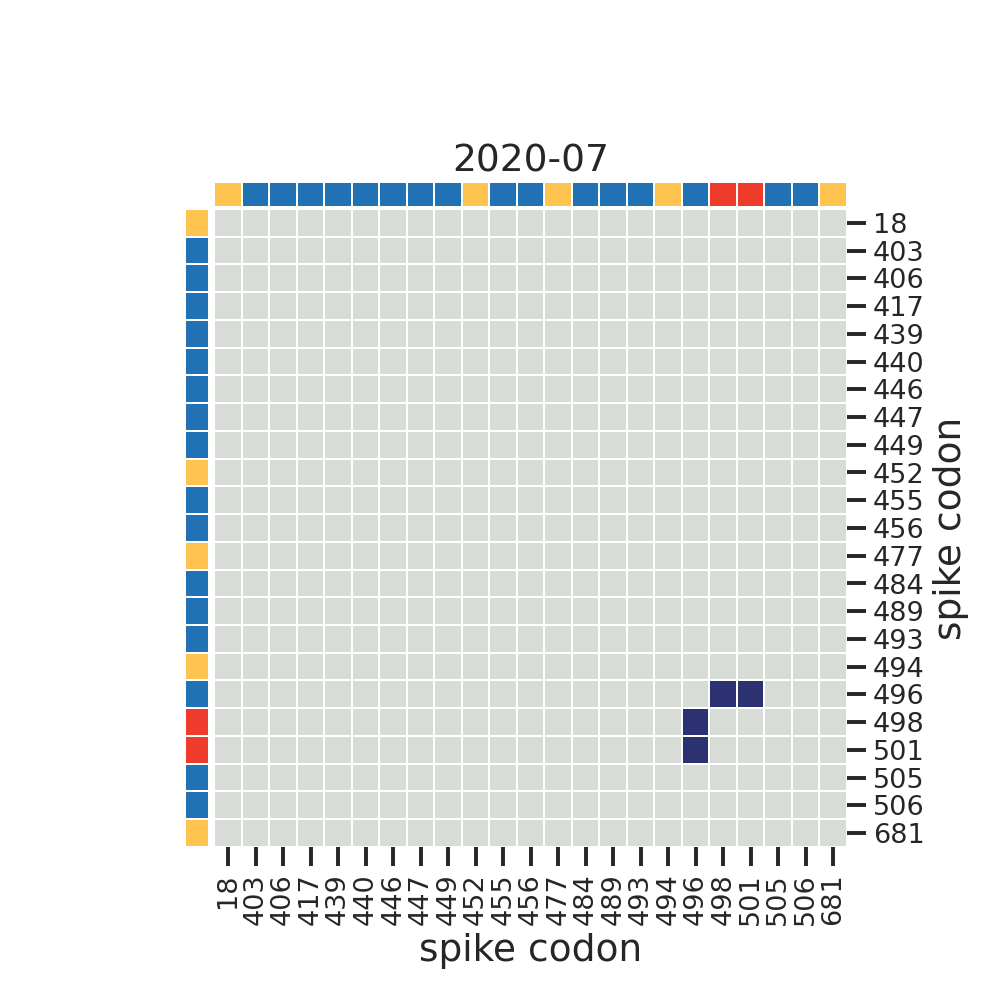

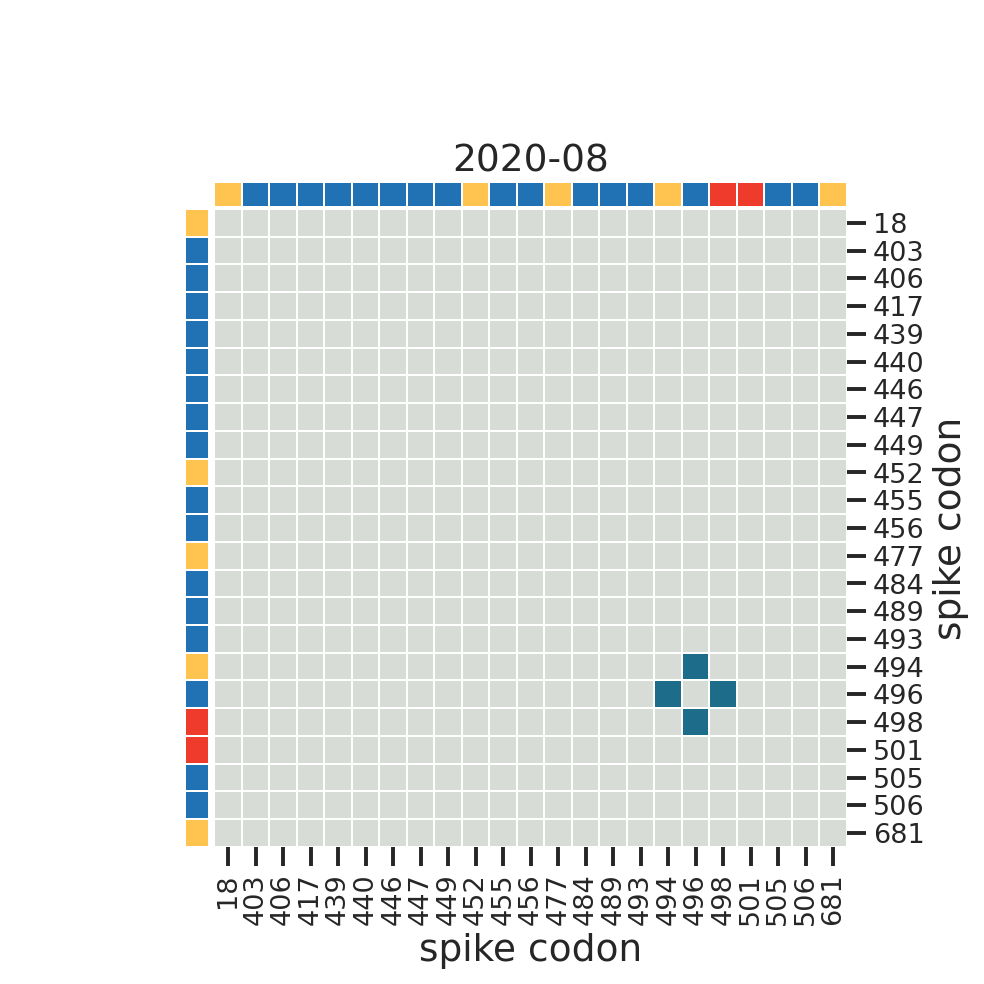

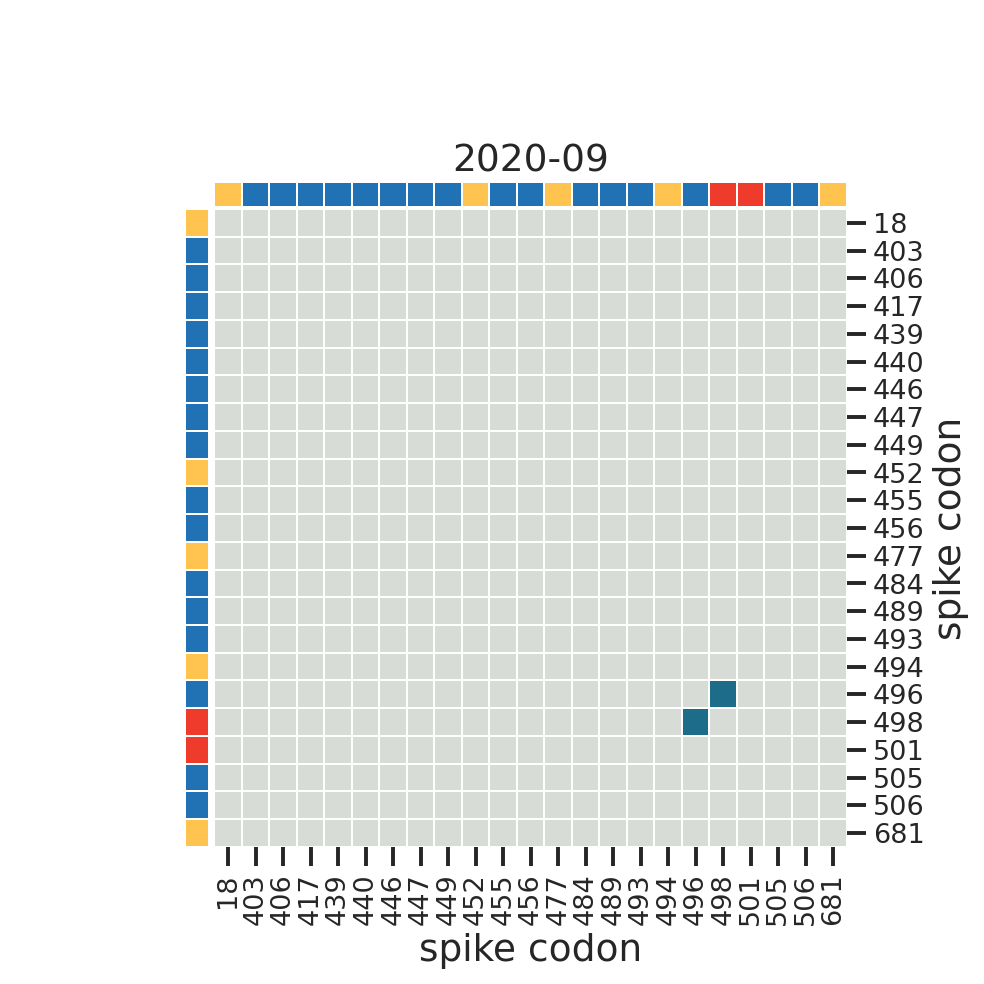

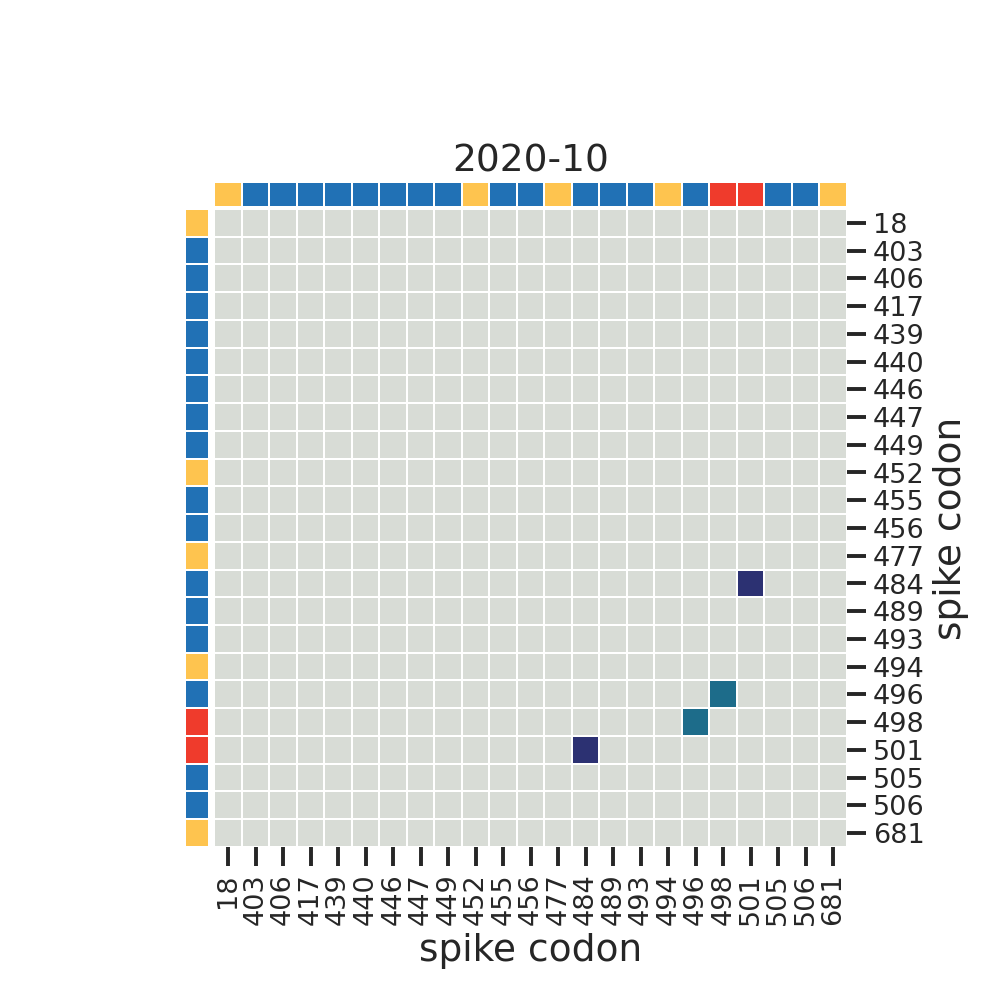

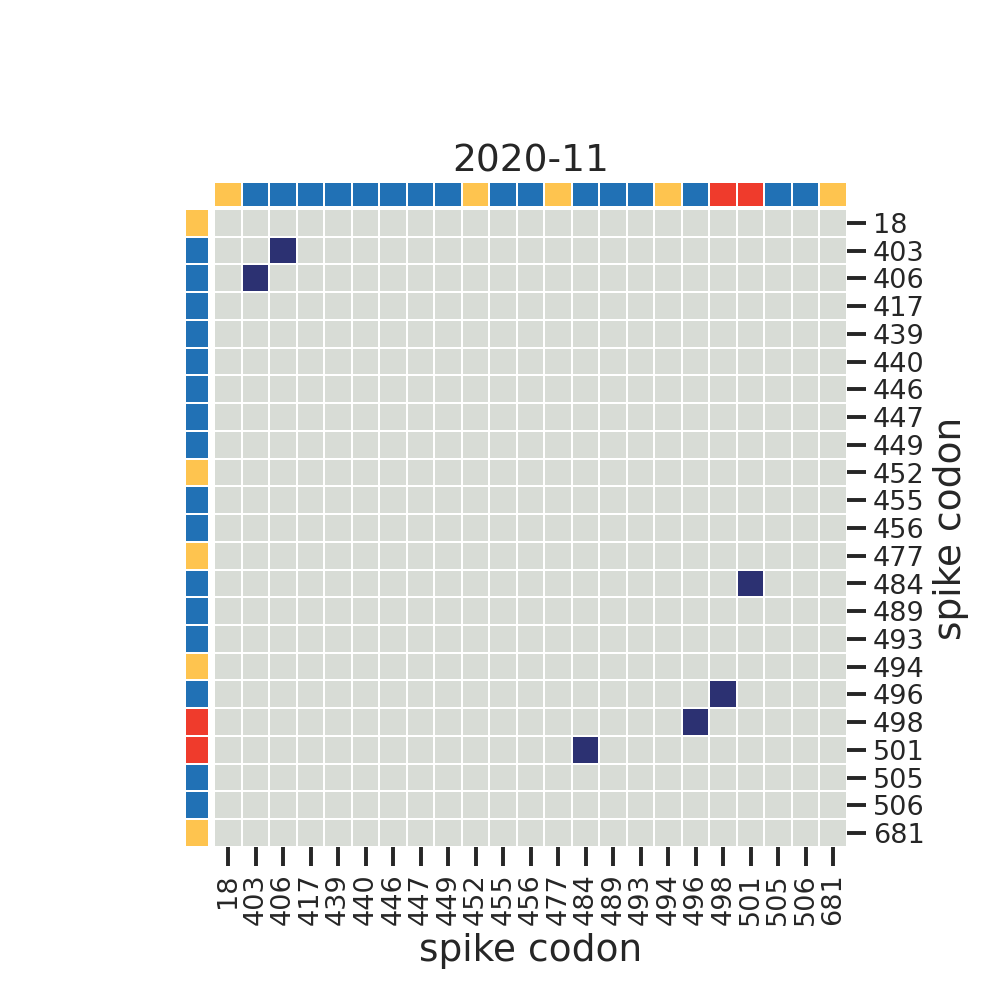

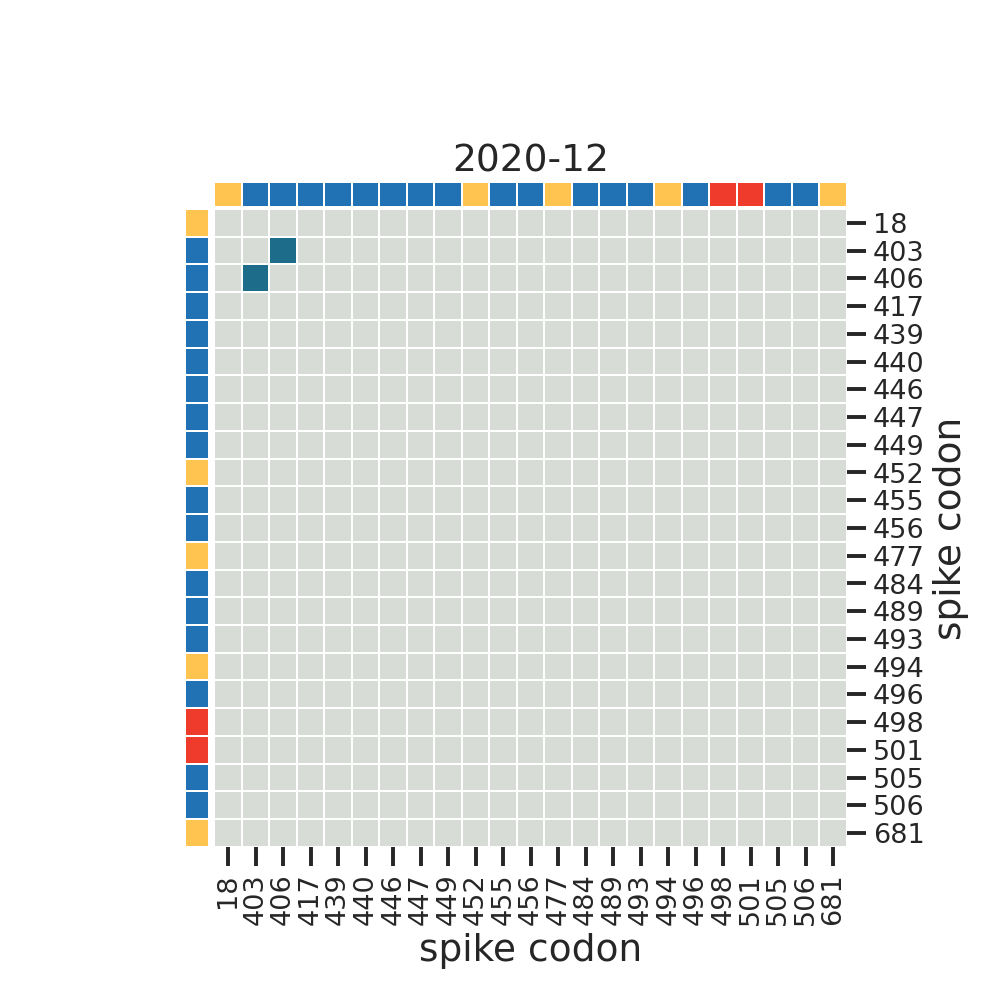

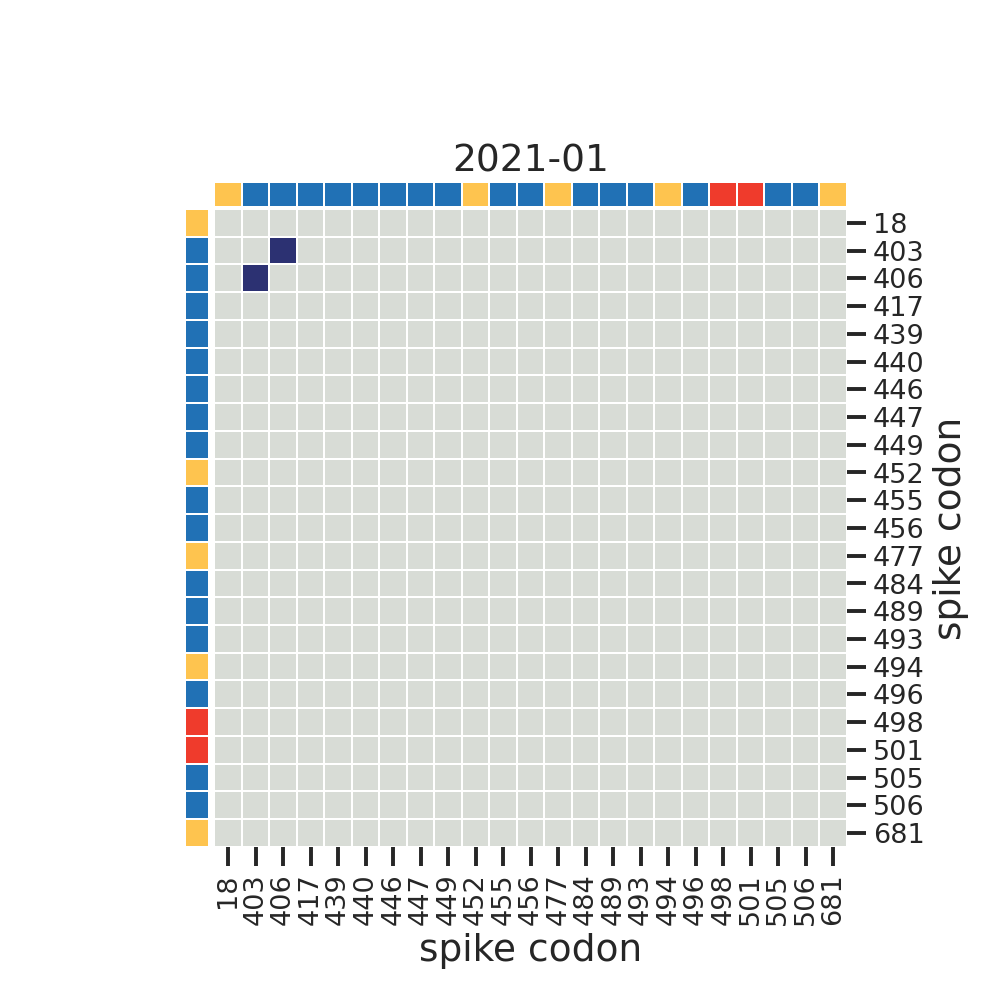

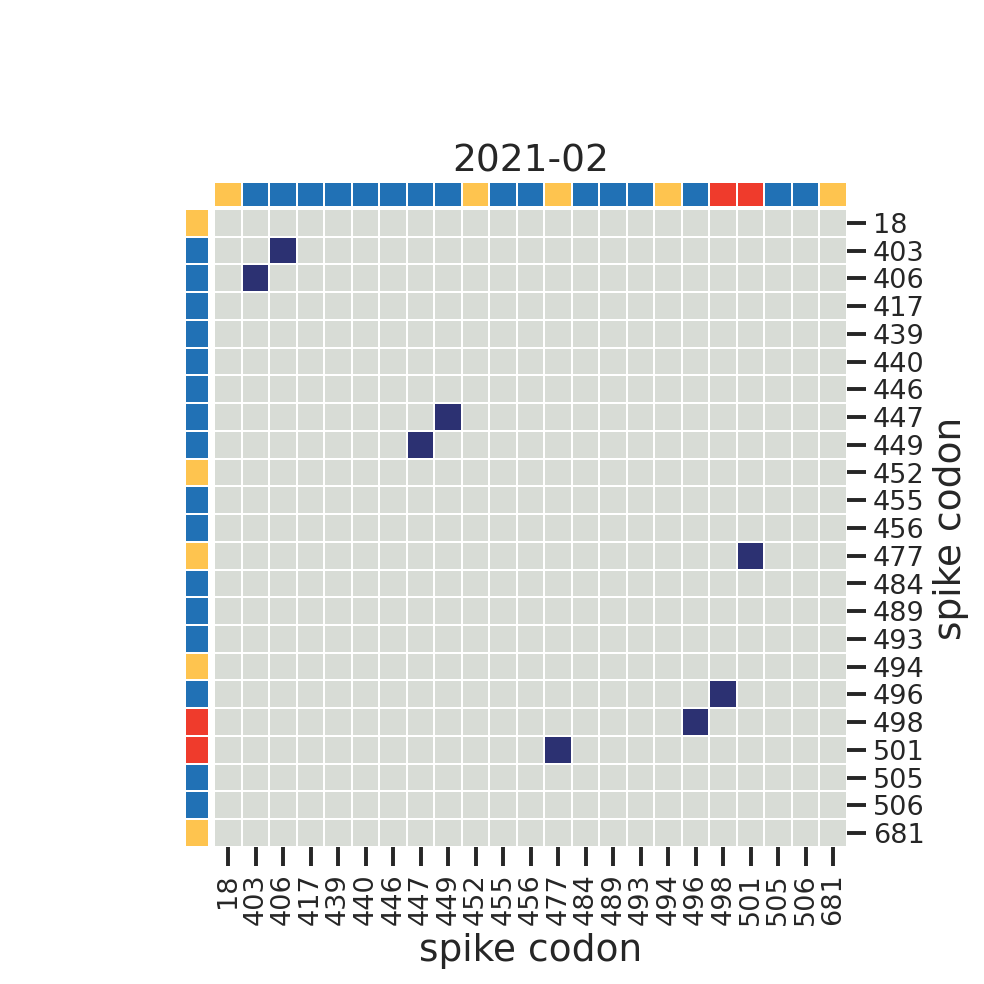

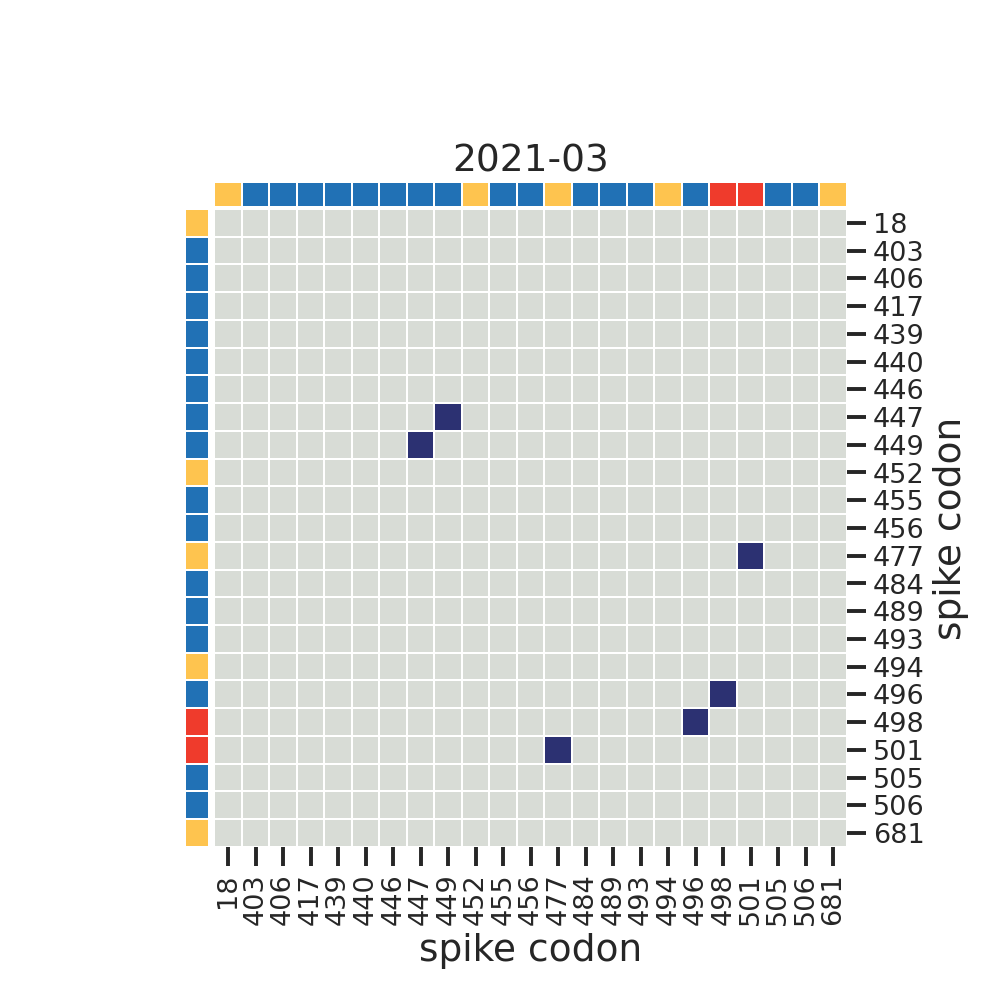

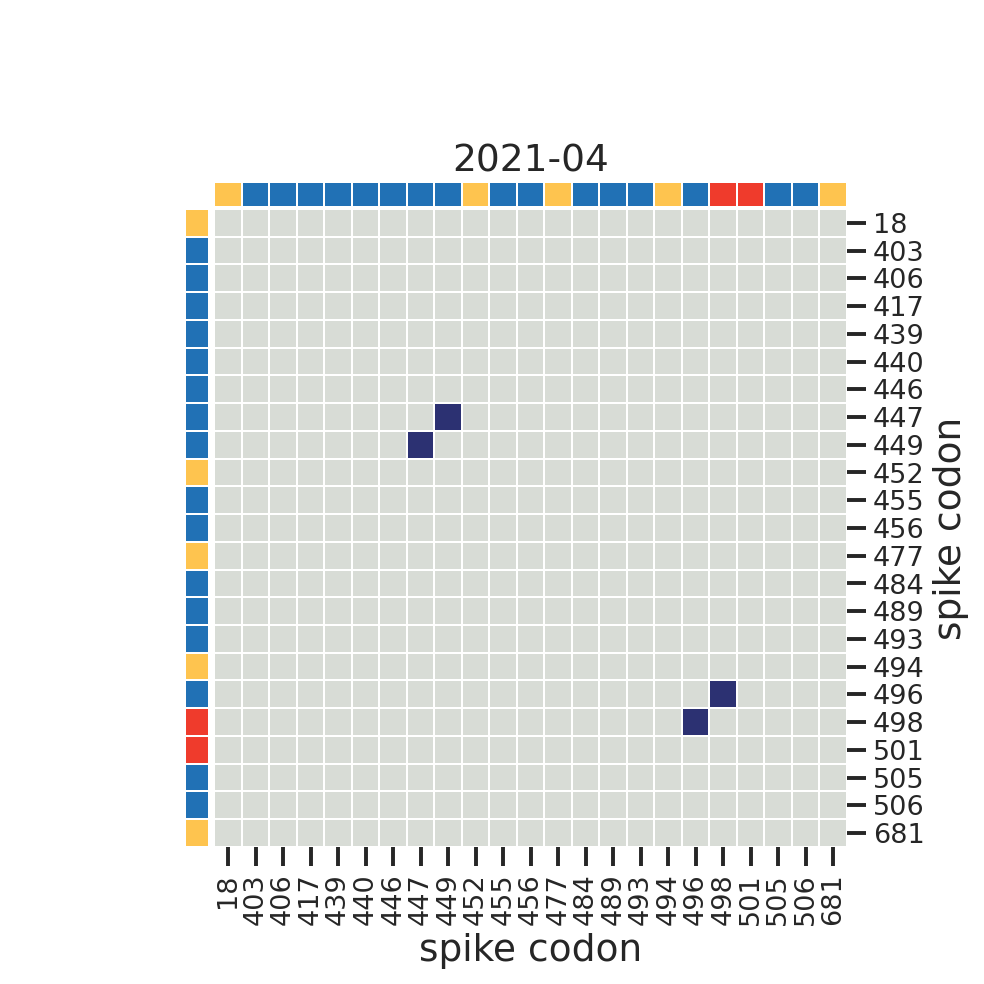

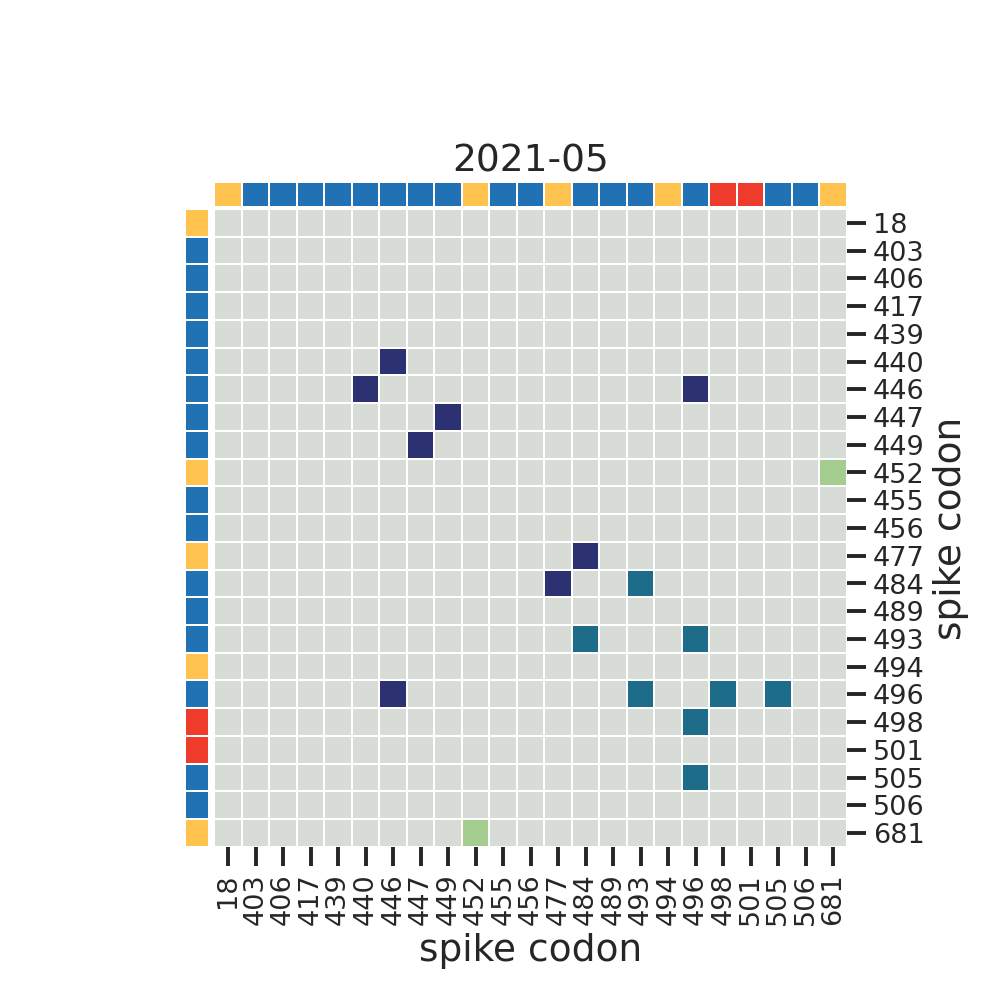

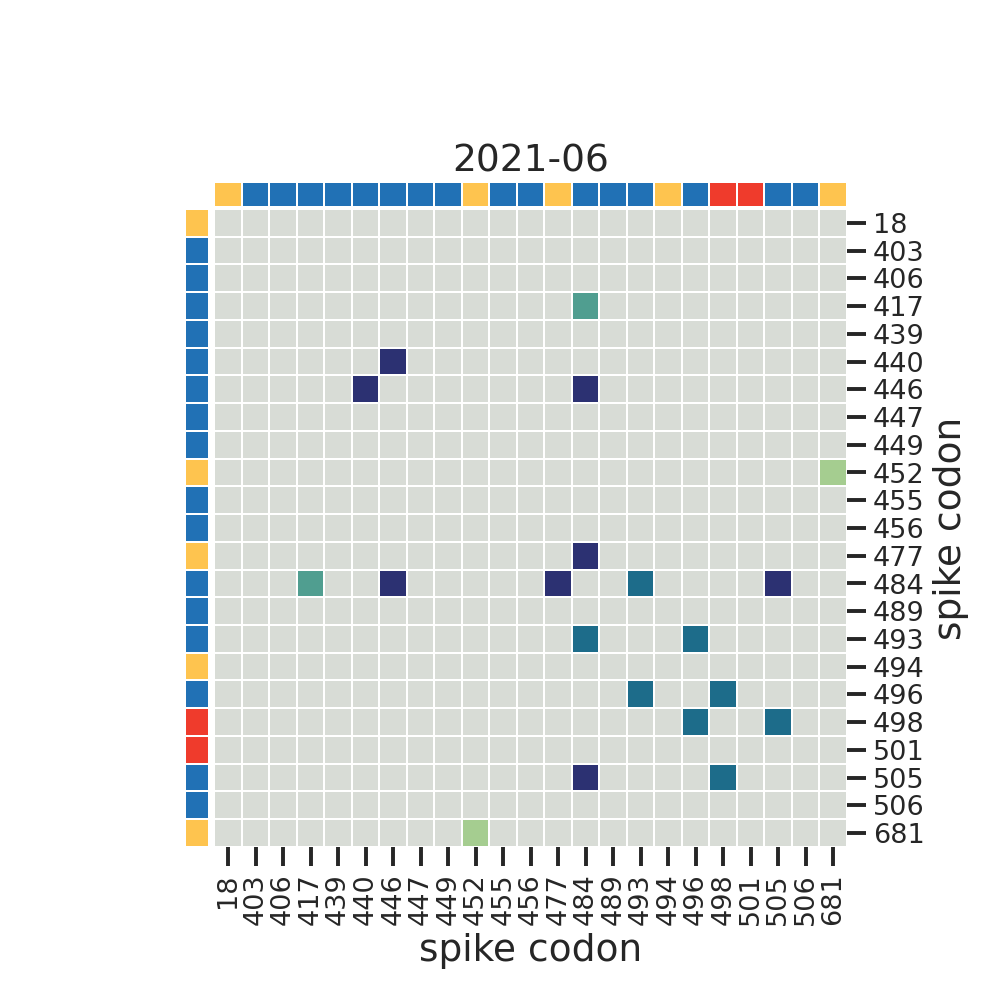

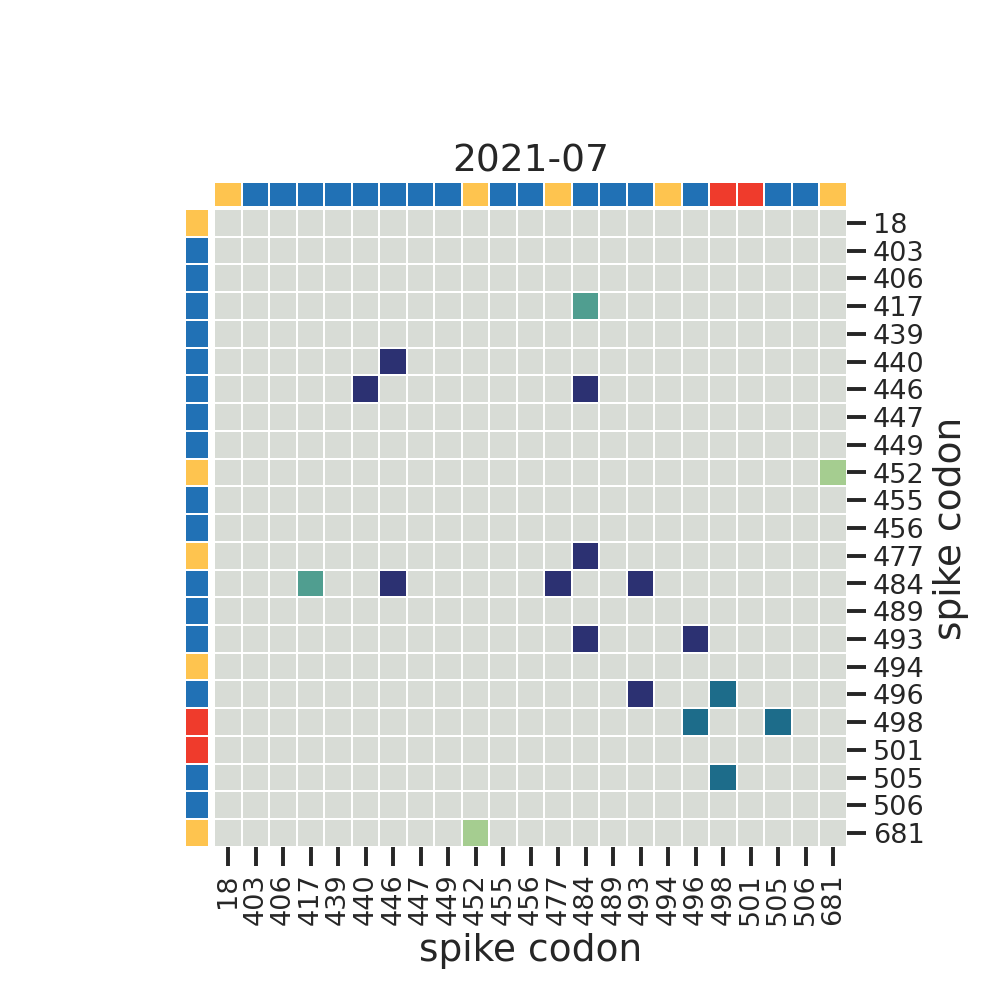

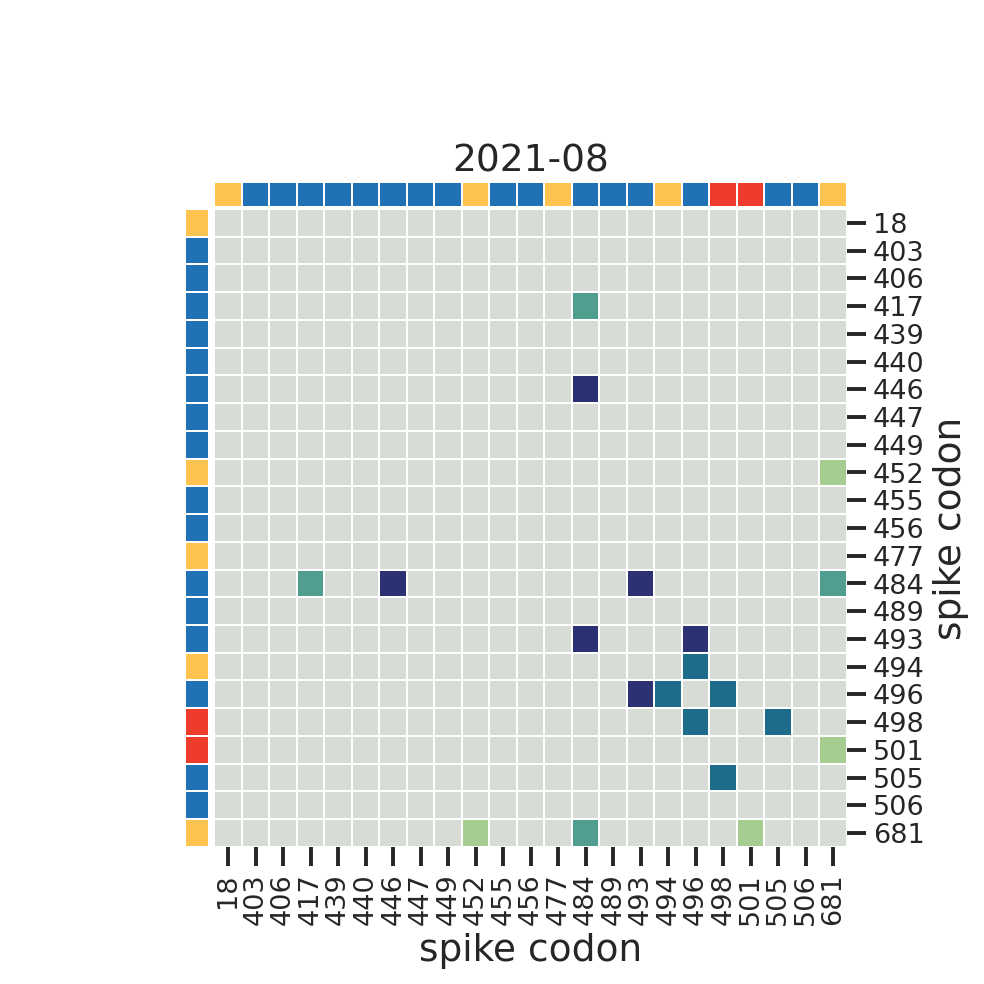

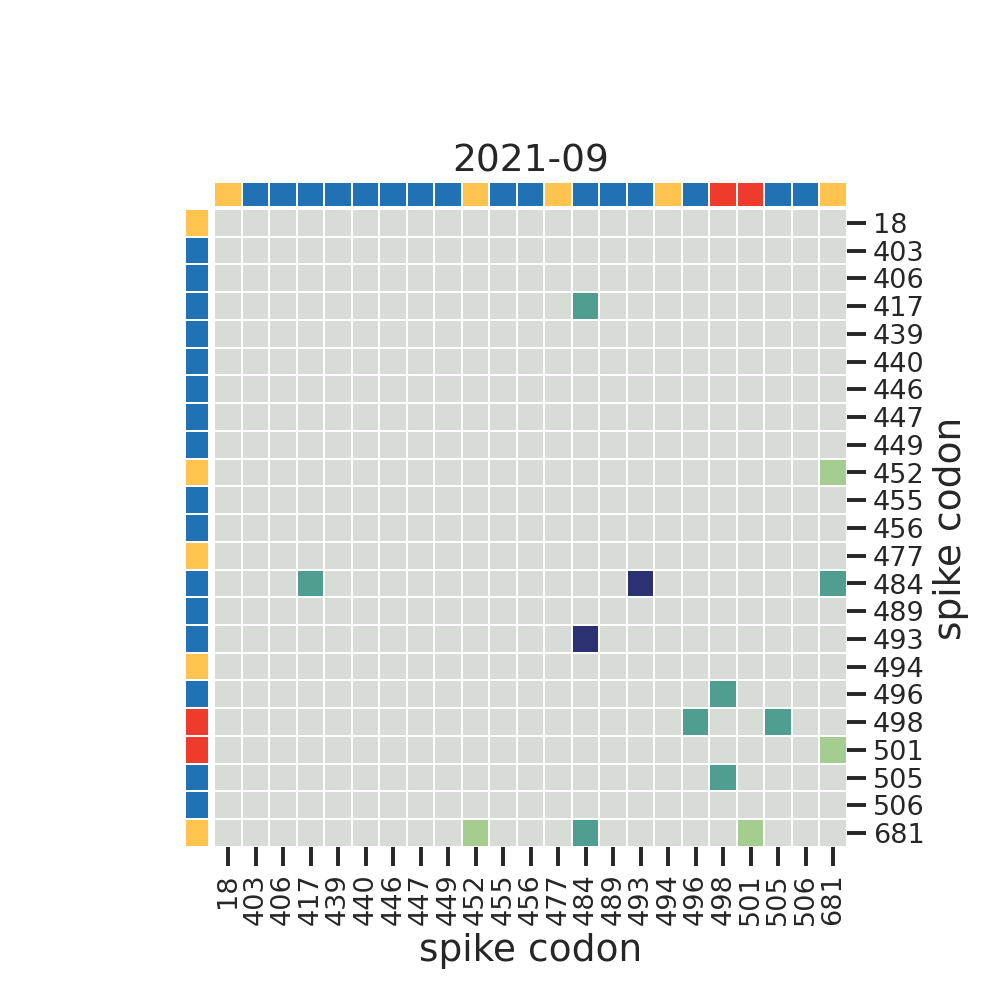

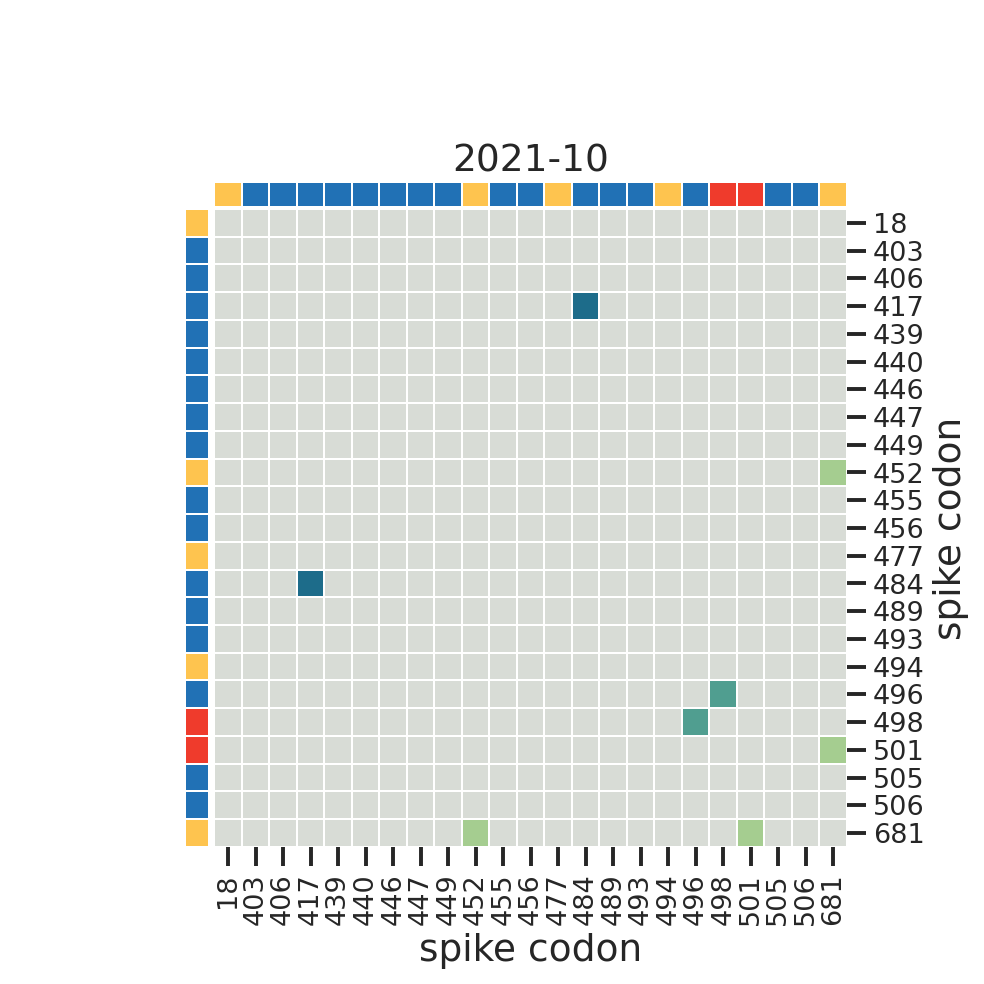

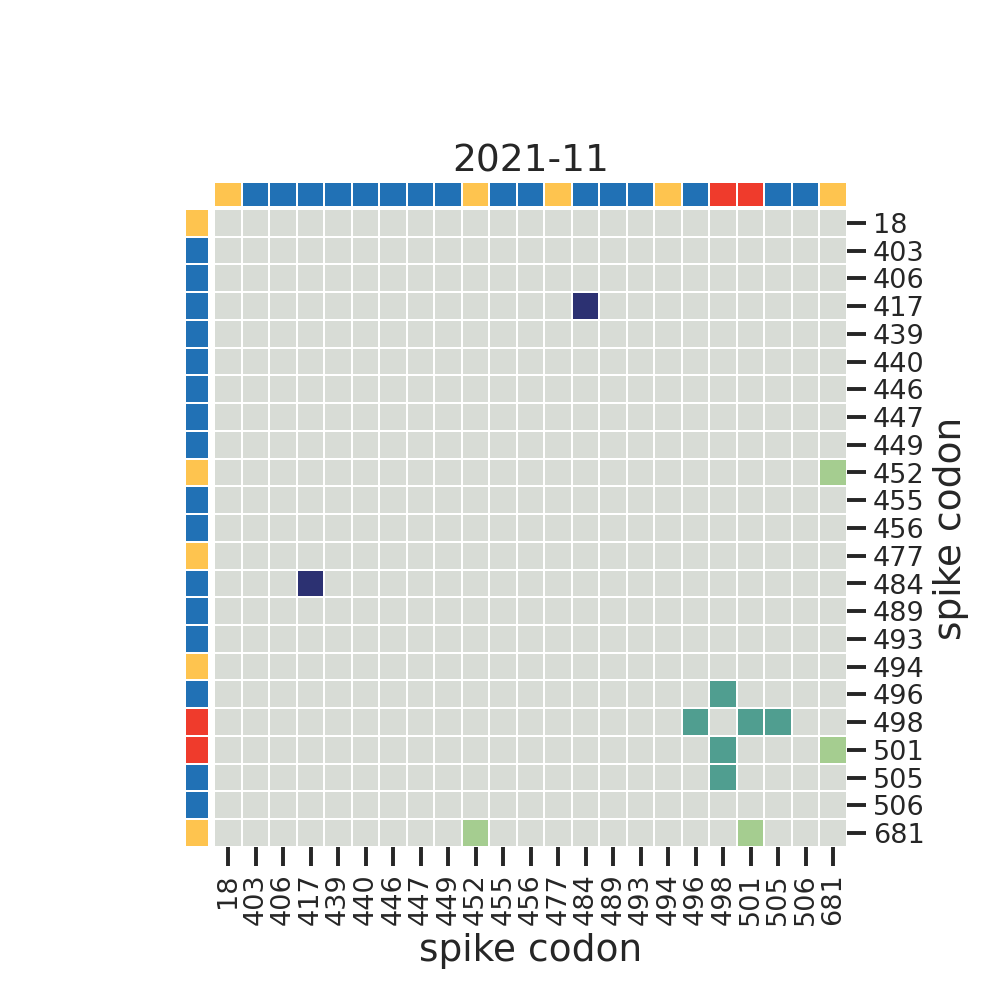

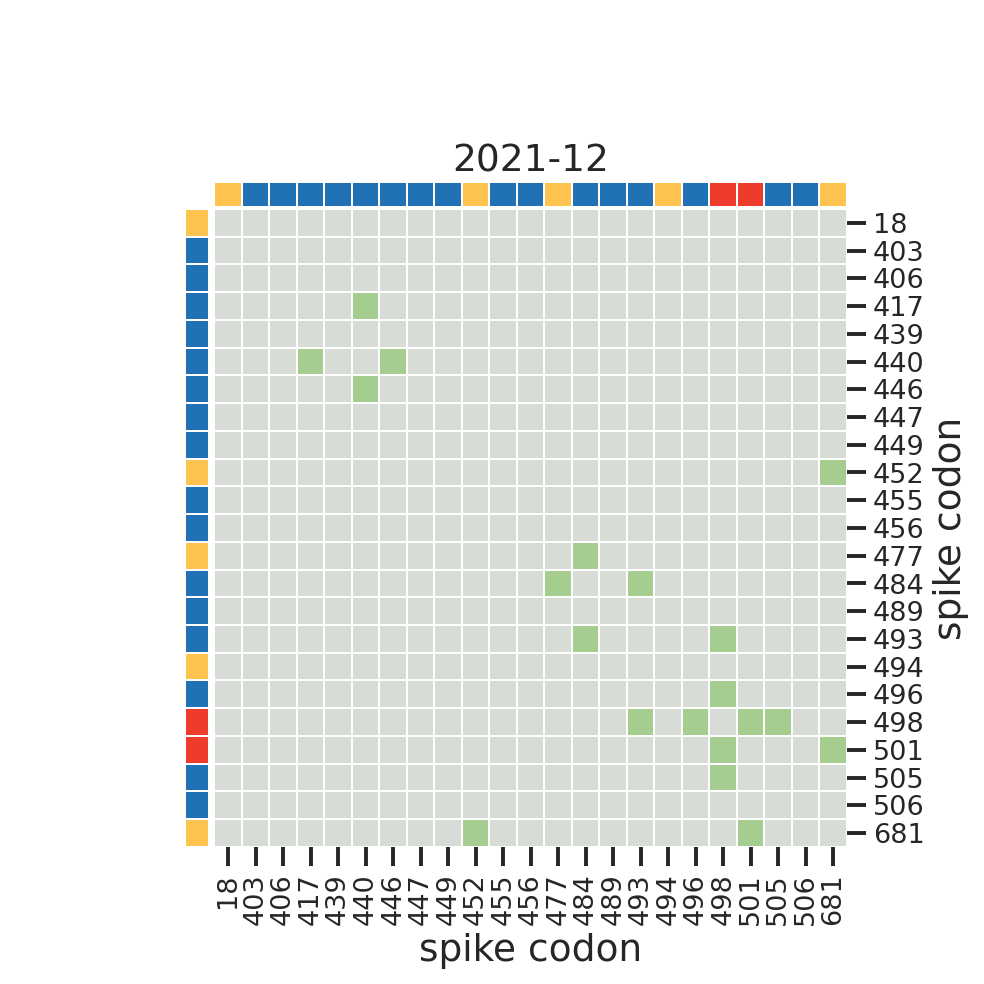

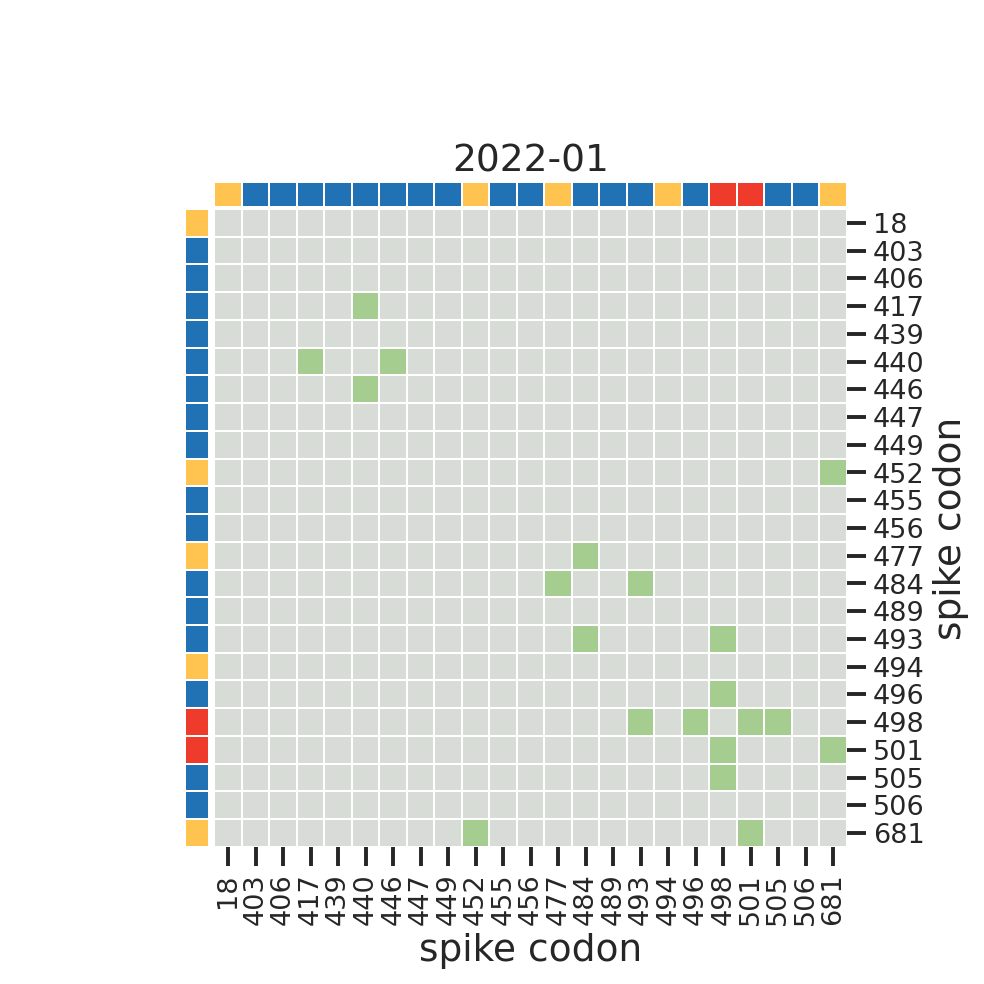

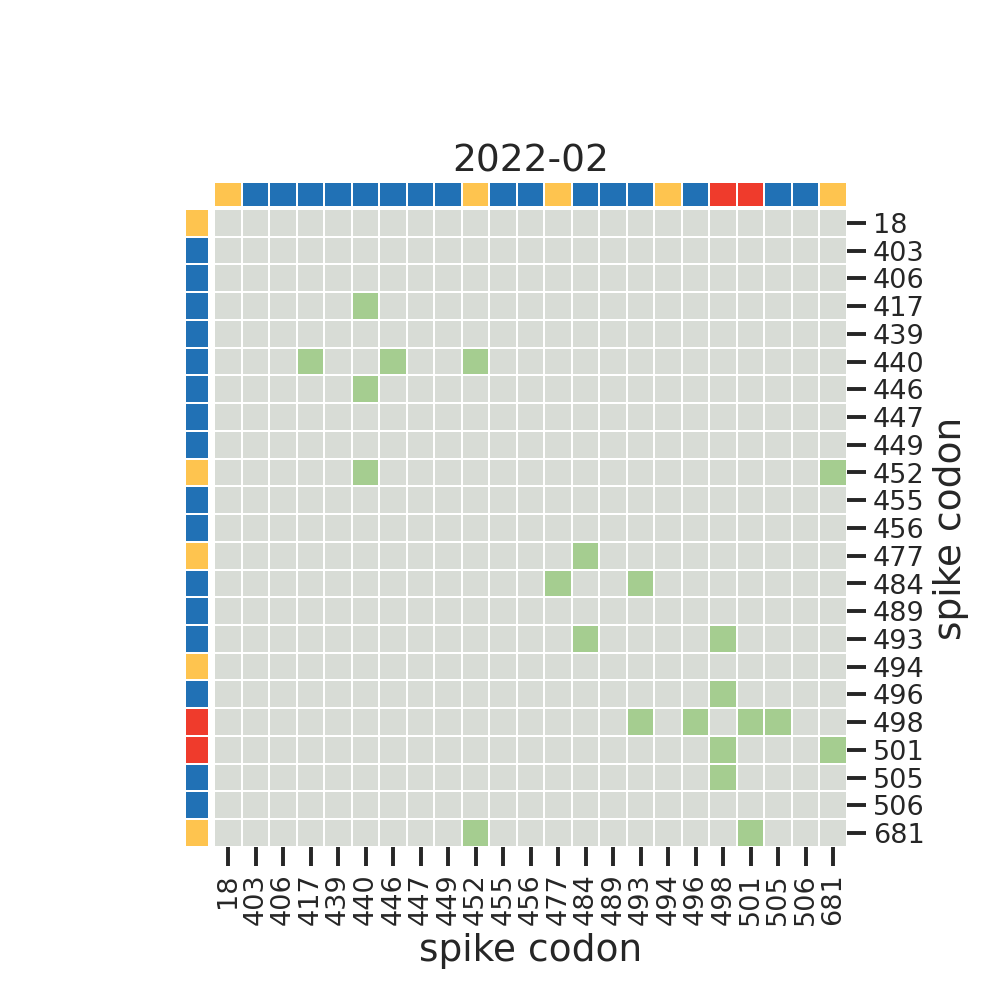

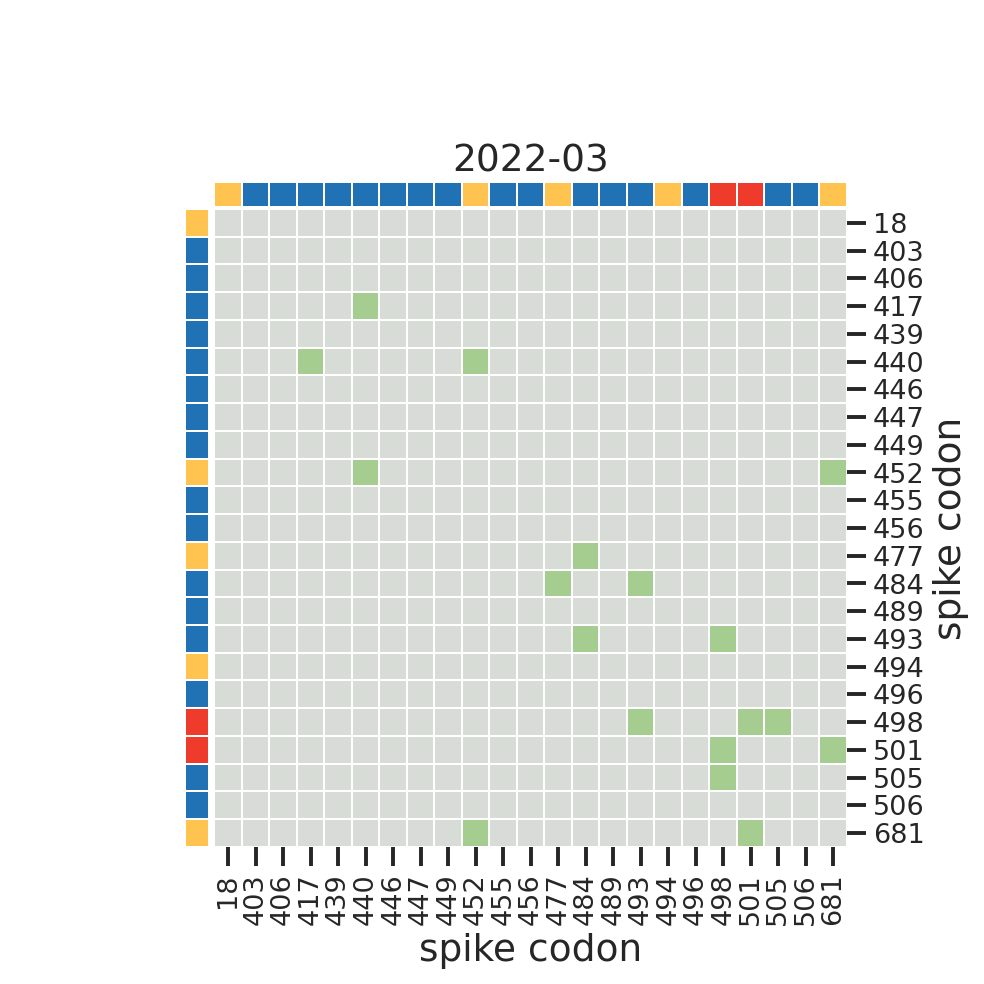

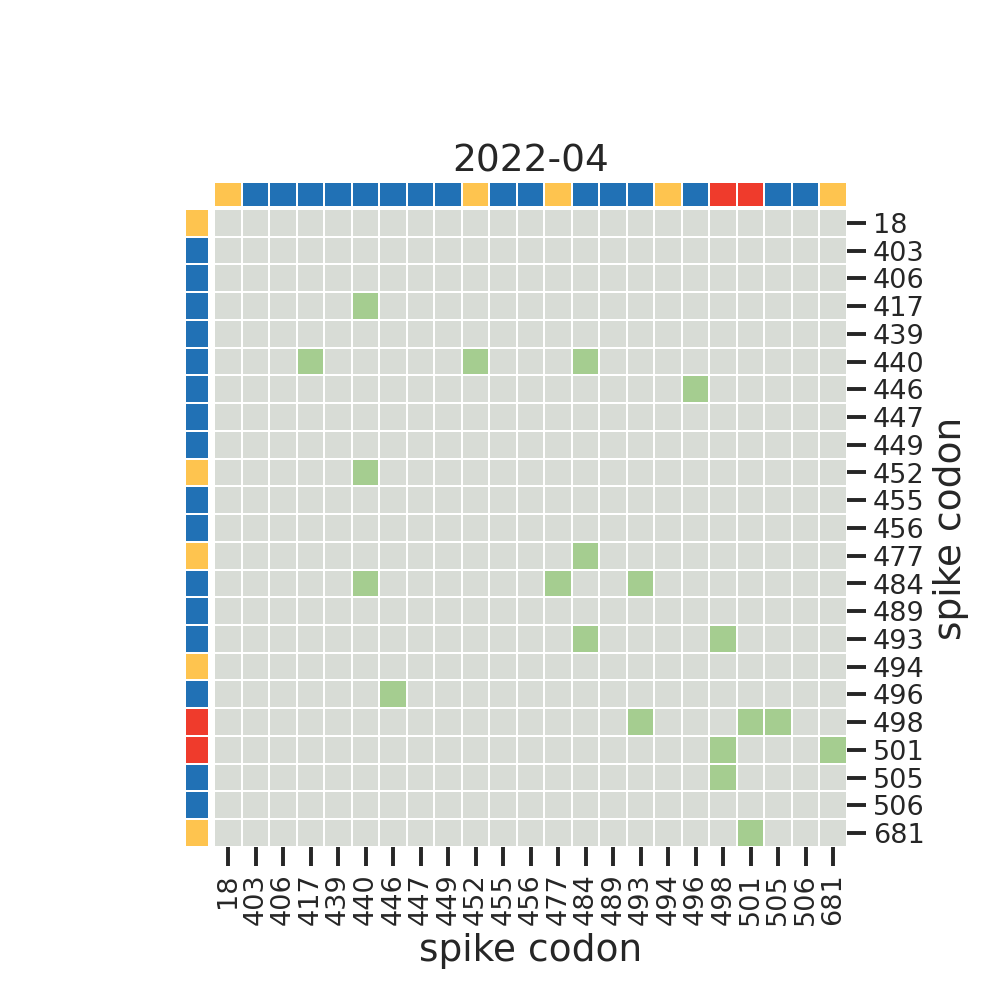

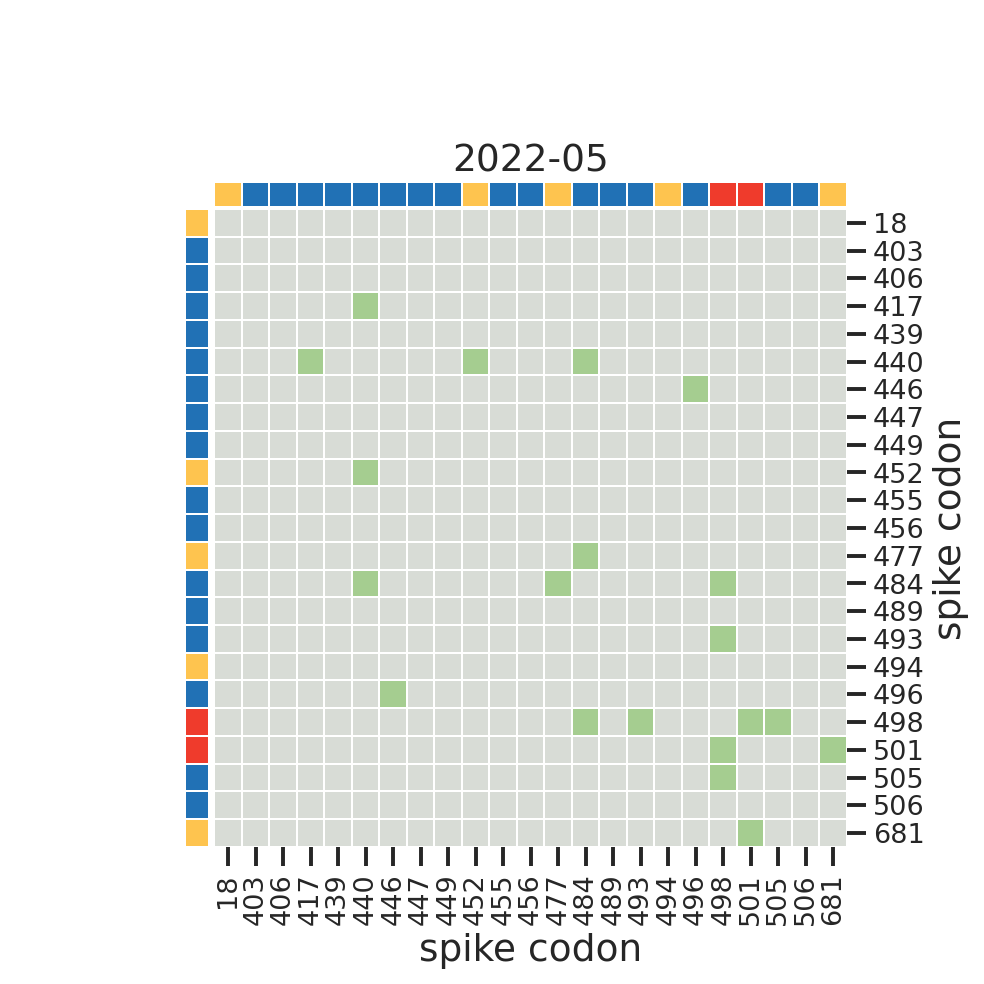

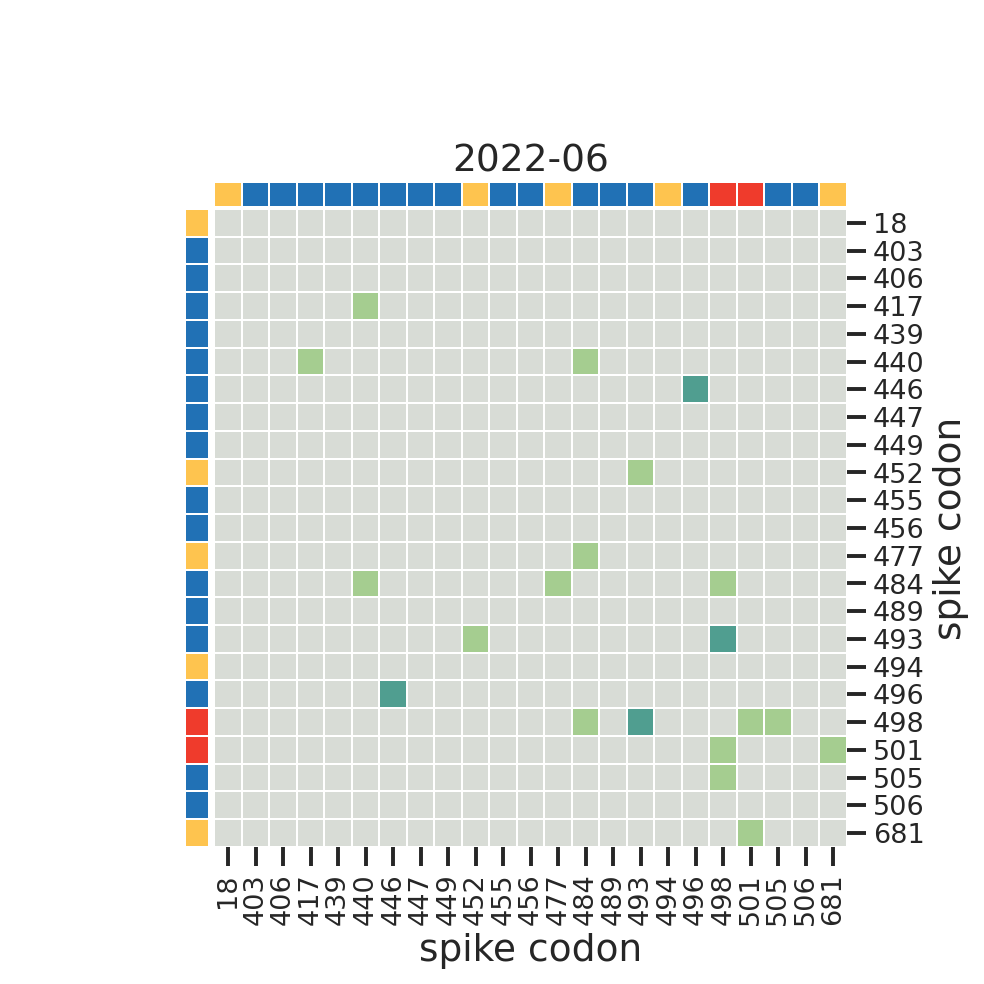

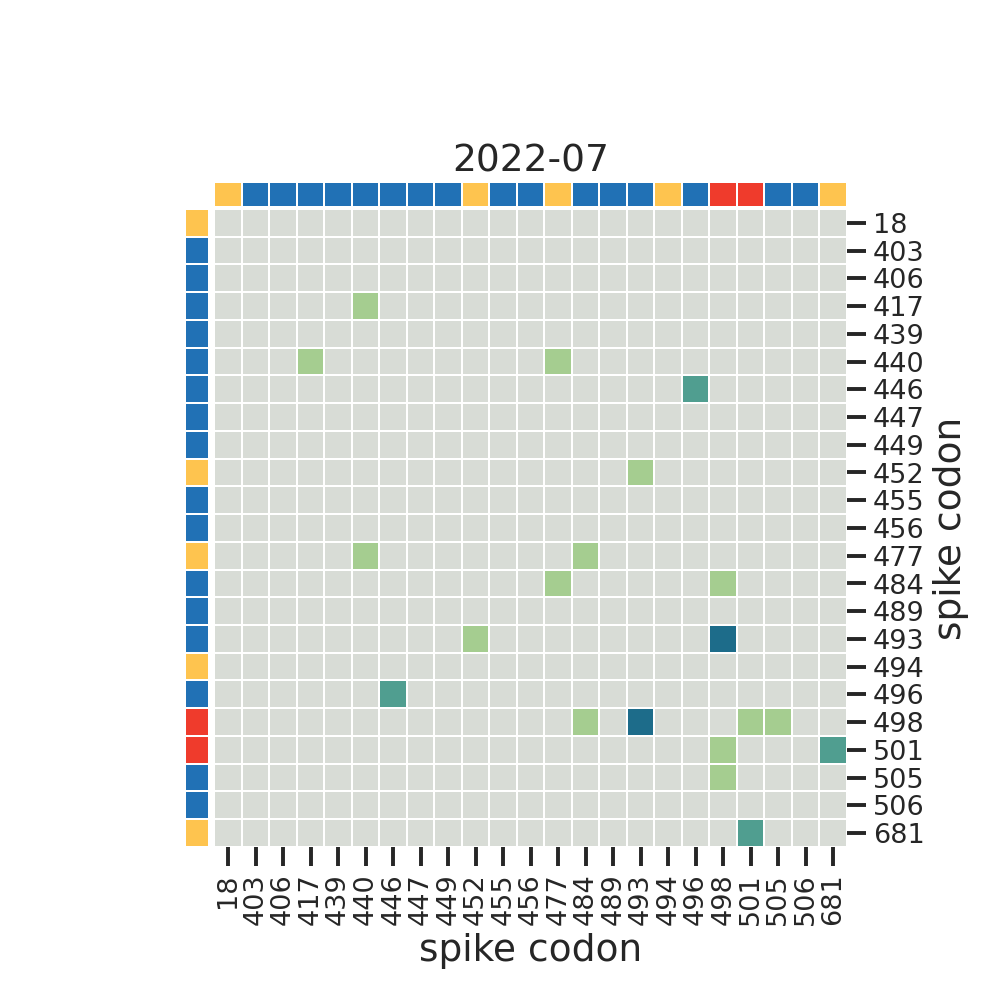

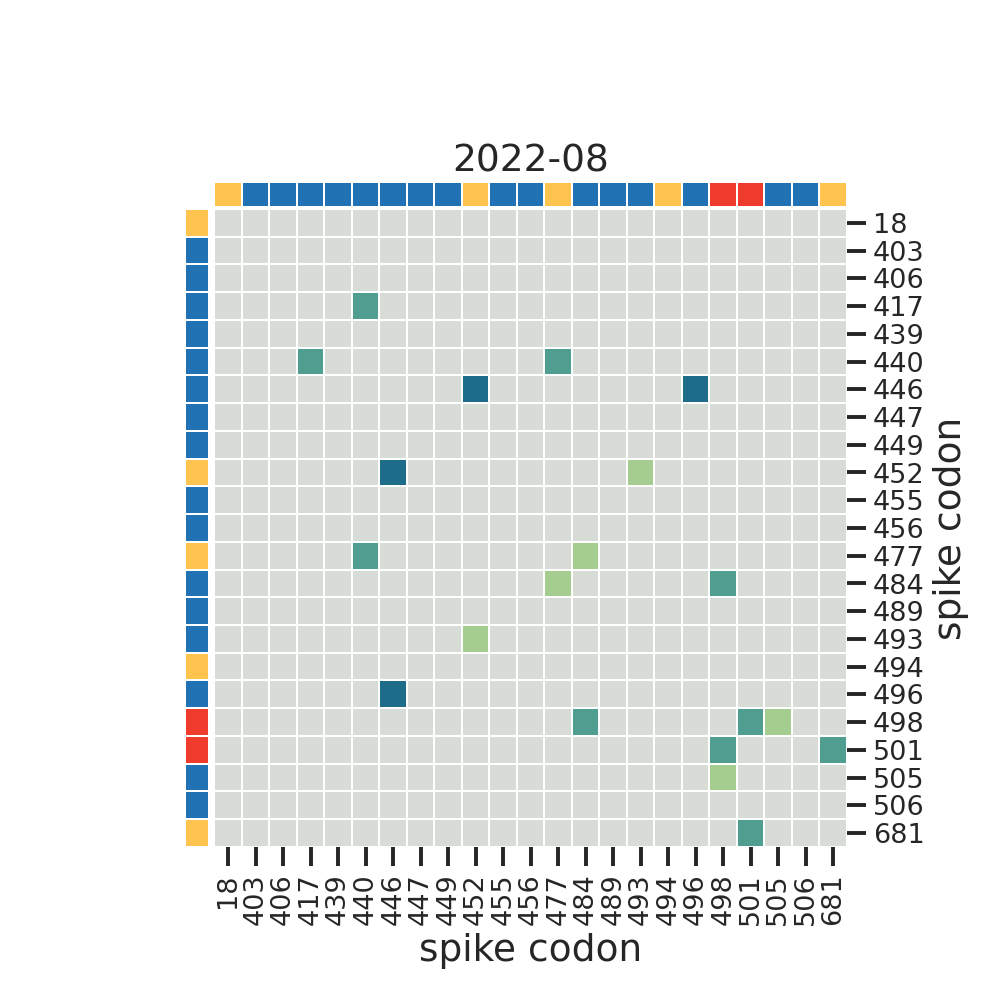

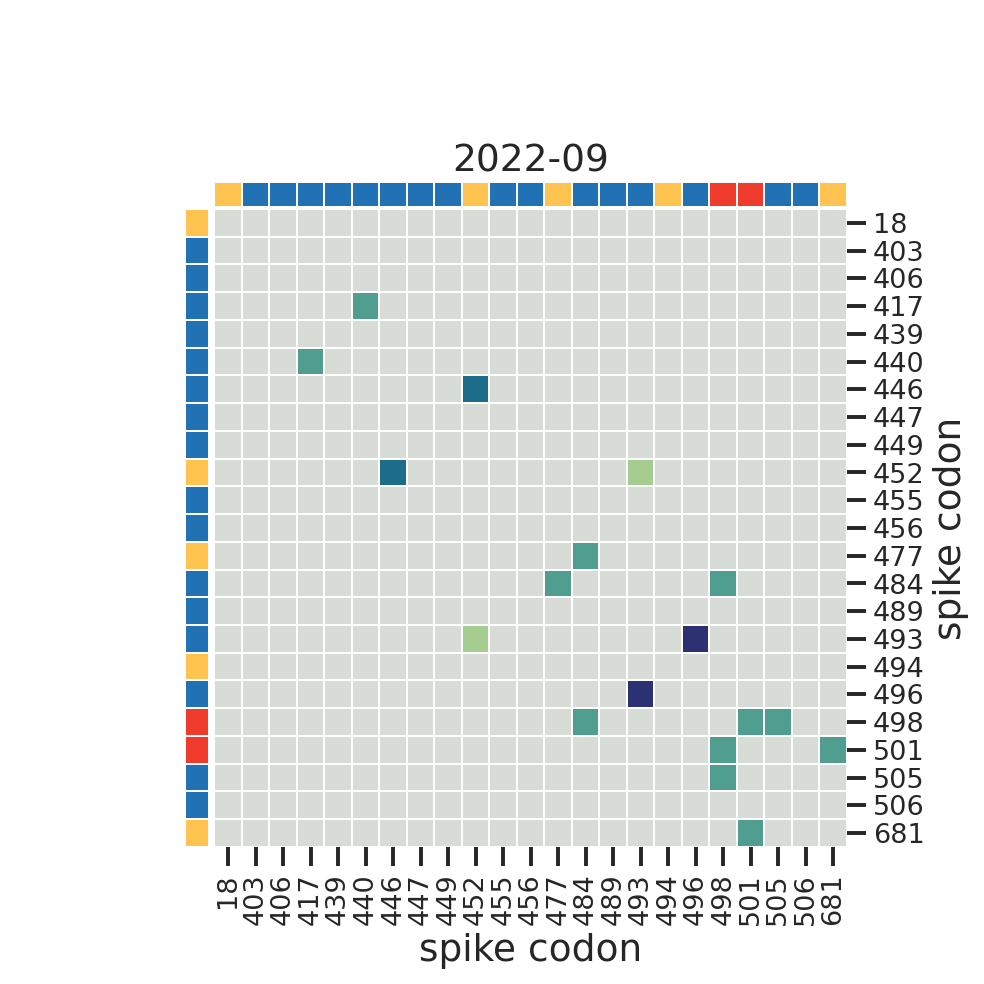

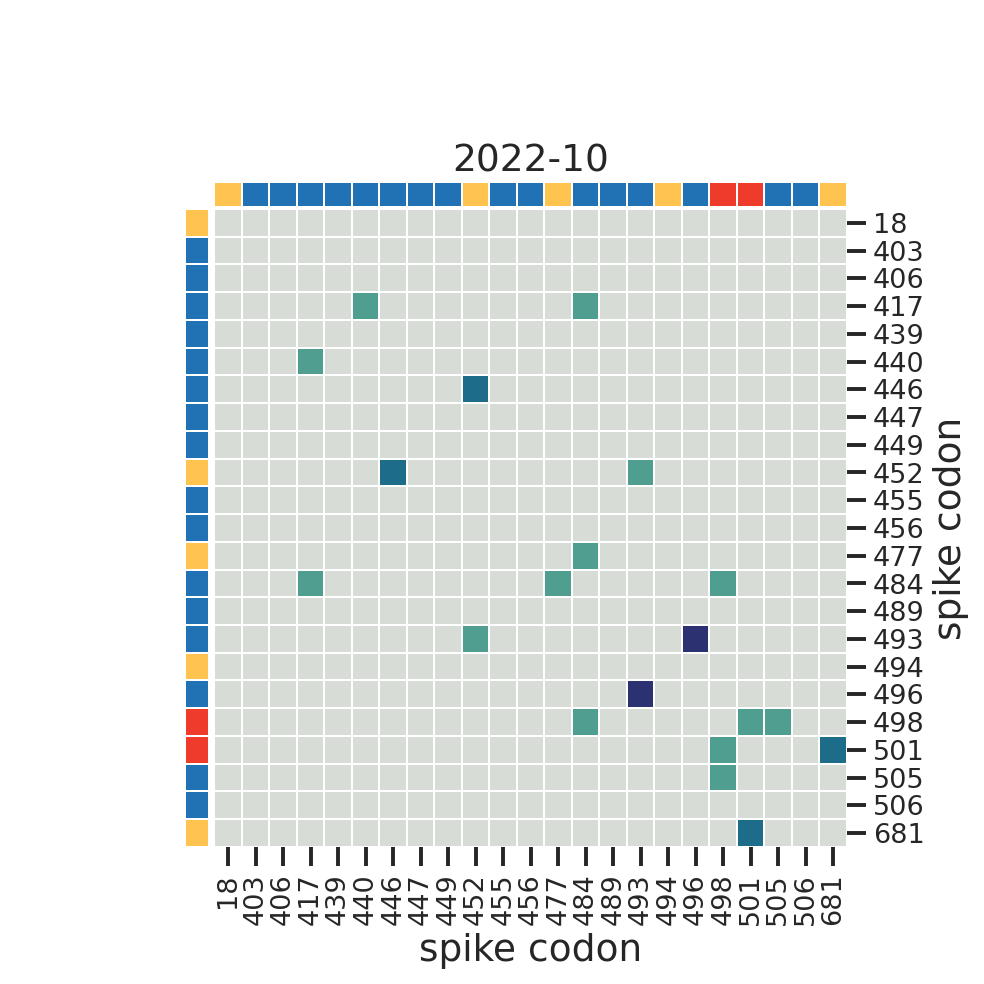

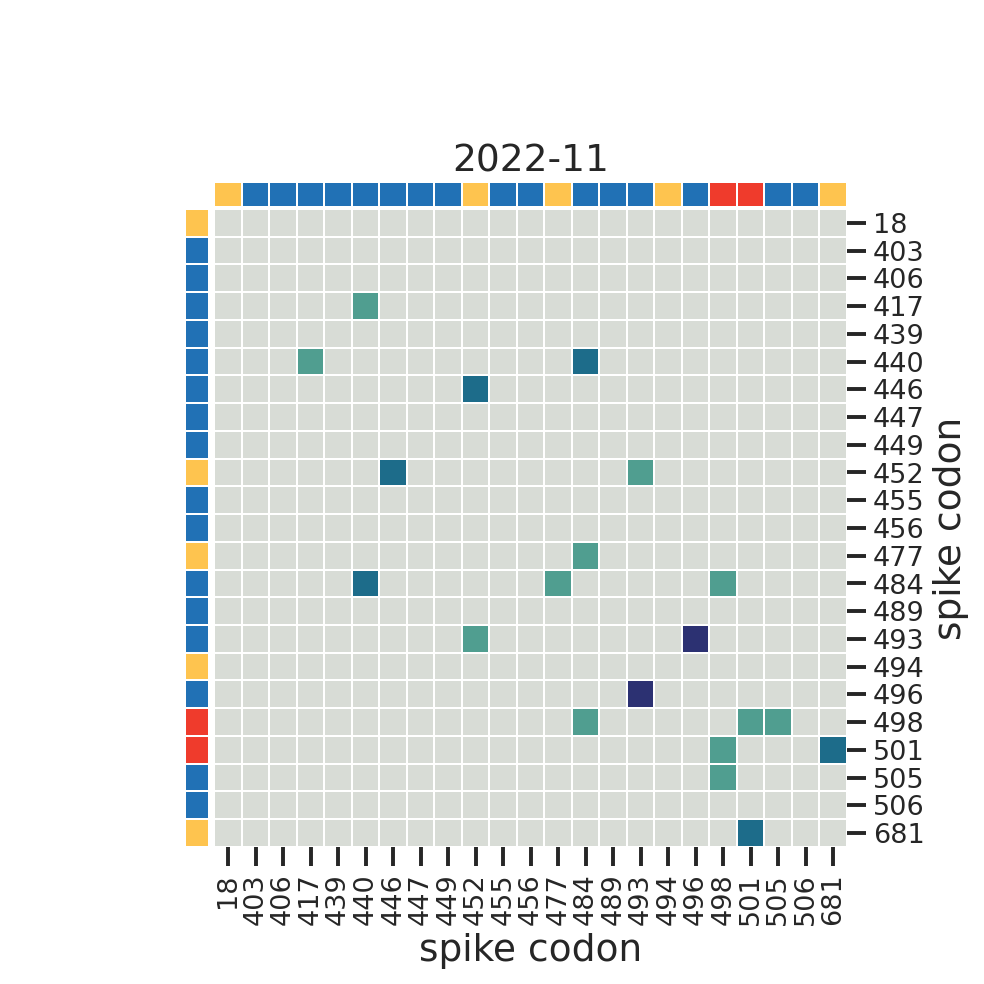

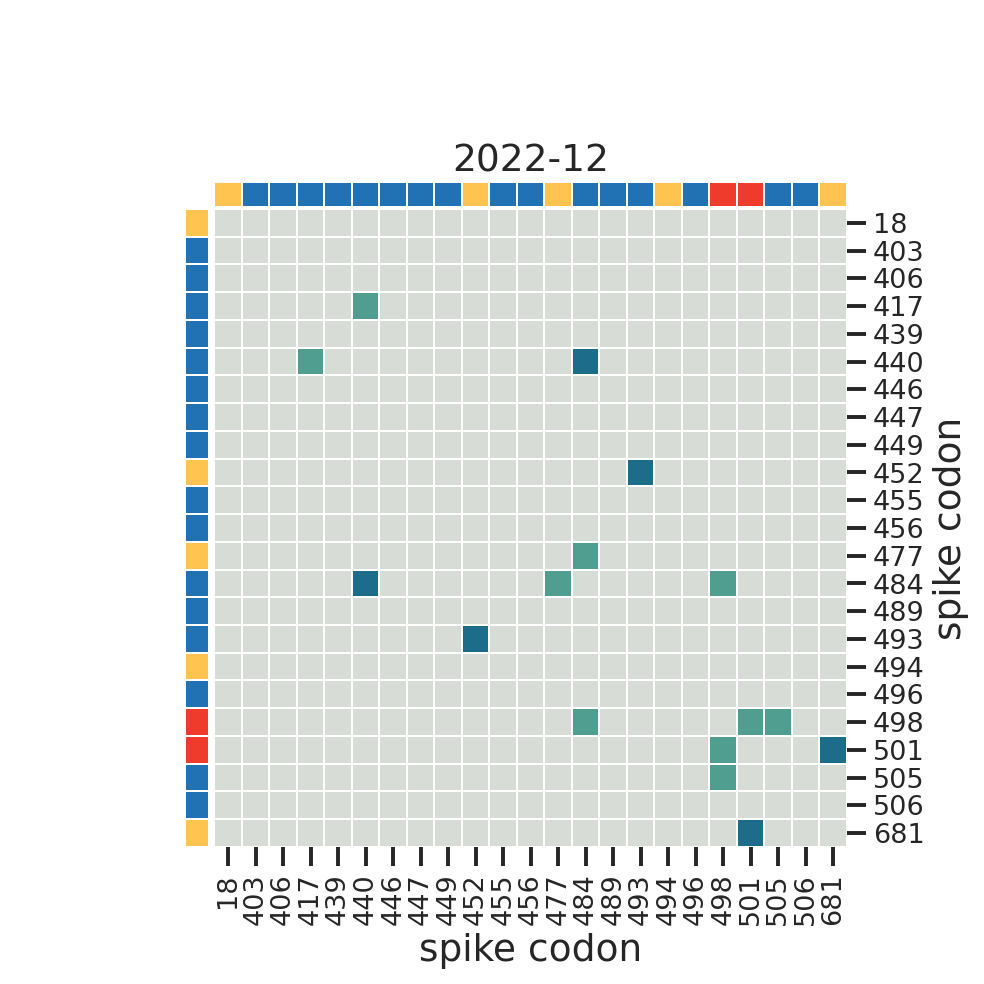

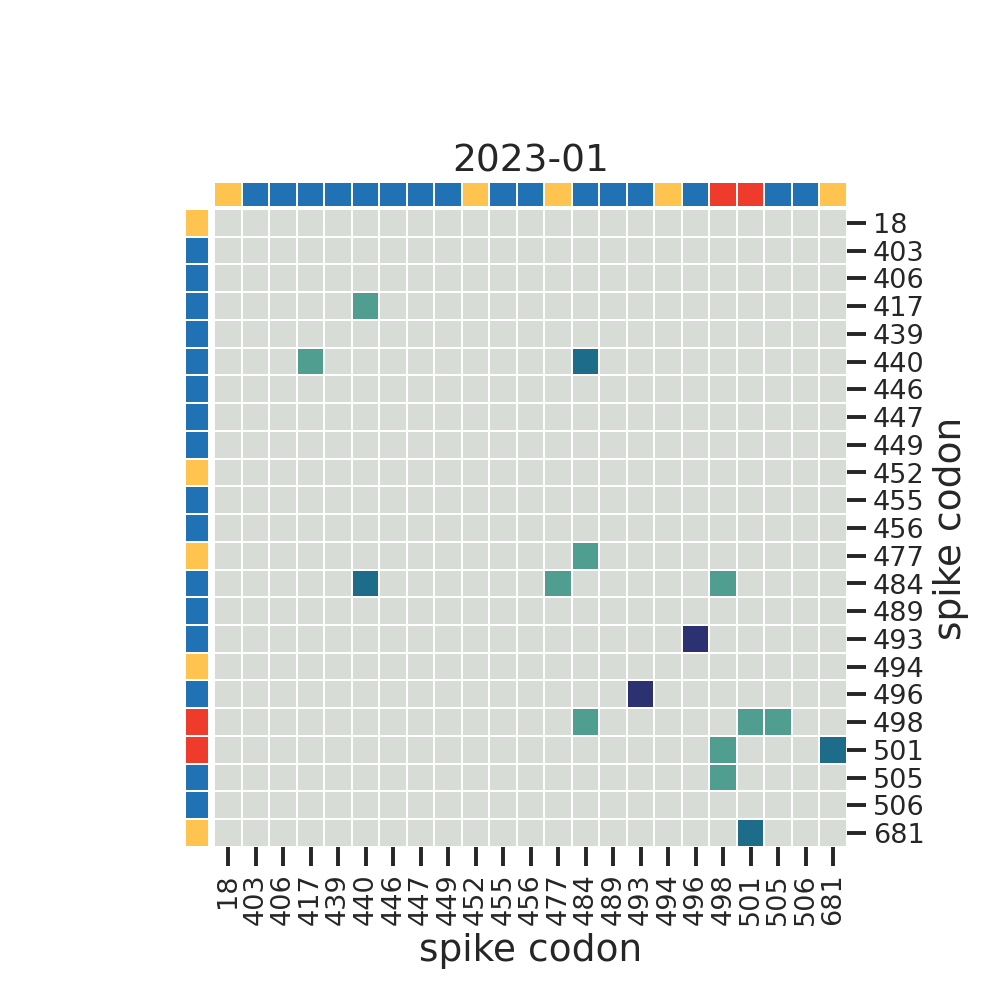

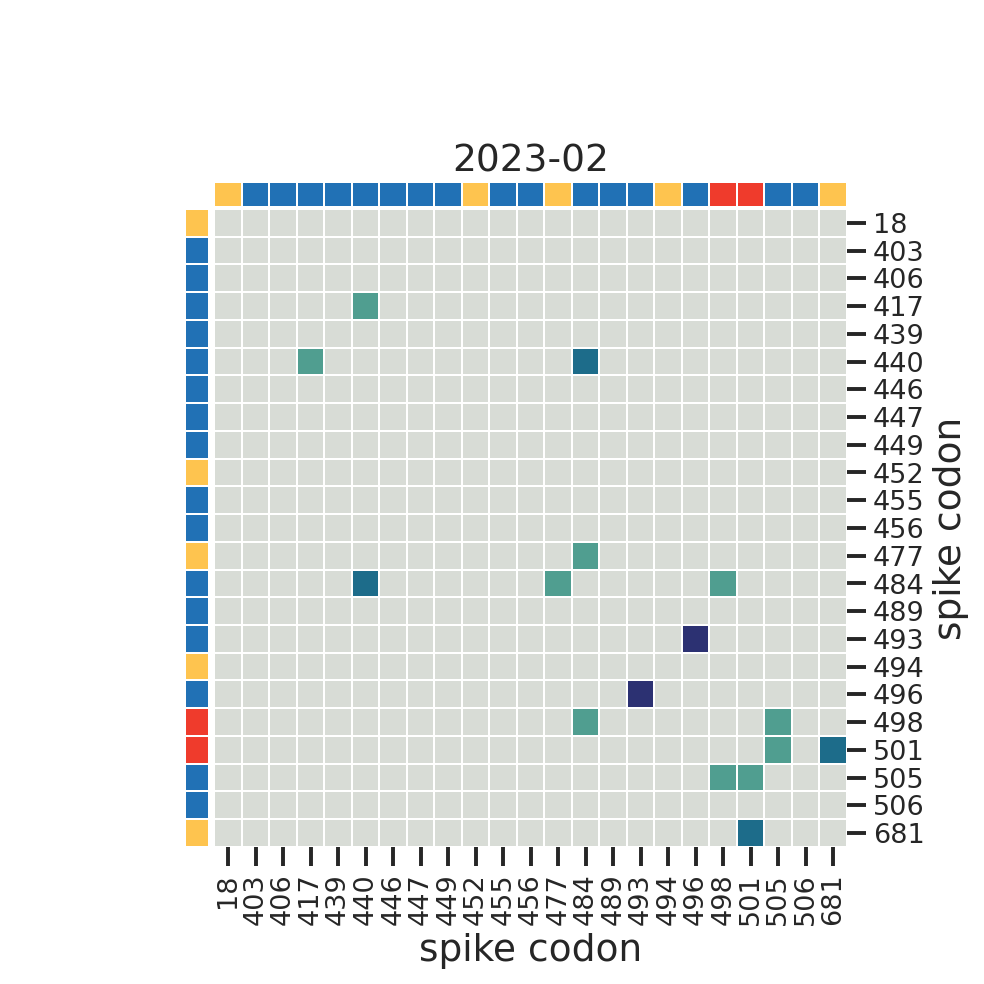

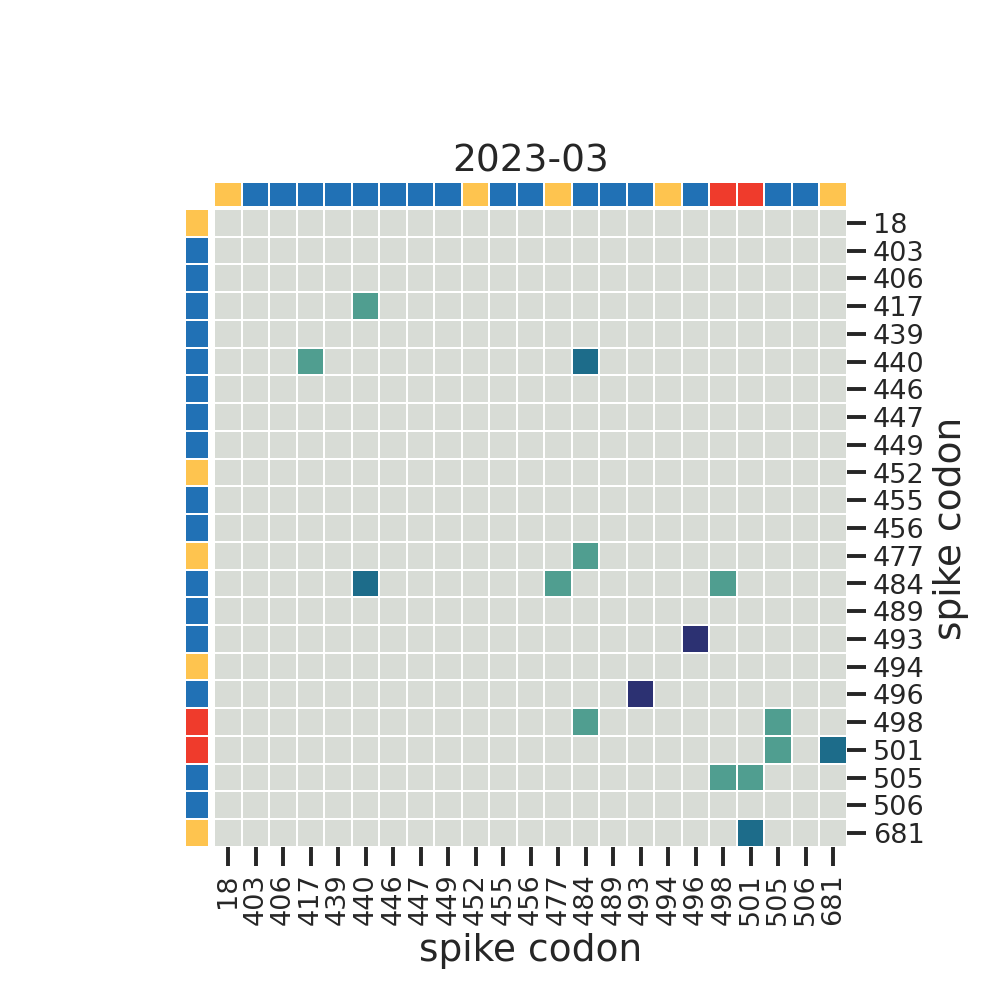

In [42]:
for date in sorted(s['name'].unique()):
    plot_mi(s, date)

In [43]:
!ffmpeg -framerate 2 -pattern_type glob -i 'time_20*.png' -filter_complex "[0:v] split [a][b];[a] palettegen [p];[b][p] paletteuse" spike.gif -y 2> /dev/null

In [44]:
res = []

d = {}
cw = {}
clades = {}

for f in os.listdir('../out/time-lineages/'):
    l = pd.read_csv(f'../out/time-lineages/{f}', sep='\t',
                    usecols=['seqName', 'clade', 'Nextclade_pango',
                             'partiallyAliased', 'clade_nextstrain',
                             'clade_who', 'clade_display'])
    date = f.split('.')[0]
    year = int(date.split('-')[0])
    month = int(date.split('-')[1])

    tmp = l.set_index('clade_display')['clade_who'].dropna().to_dict()
    for k, v in tmp.items():
        d[k] = v
        cw[v] = cw.get(v, set())
        cw[v].add(k)
        clades[v] = clades.get(v, [])
        if k not in clades[v]:
            clades[v].append(k)
    
    l = l.groupby('clade_display')['seqName'].count().reset_index()
    l = l.rename(columns={'seqName': 'count'})
    l['name'] = date
    l['year'] = year
    l['month'] = month

    res.append(l)
r = pd.concat(res)

In [45]:
rr = r.pivot_table(index='clade_display',
                   columns='name',
                   values='count')
rr = rr.fillna(0)
rr = rr / rr.sum()
rr.T.to_csv('clades.tsv', sep='\t')

In [46]:
r['clade_display'].unique()

array(['19B', '20A', '20B', '20C', '20D', '20E', '20G', '20H (Beta)',
       '20I (Alpha)', '20J (Gamma)', '21B (Kappa)', '21C (Epsilon)',
       '21D (Eta)', '21F (Iota)', '21J (Delta)', '21K (BA.1)',
       '21L (BA.2)', '21M (Omicron)', '22A (BA.4)', '22B (BA.5)',
       '22C (BA.2.12.1)', '22D (BA.2.75)', '22E (BQ.1)', 'recombinant',
       '21A (Delta)', '21I (Delta)', '21H (Mu)', '19A', '22F (XBB)',
       '23A (XBB.1.5)', '23B (XBB.1.16)', '20F', '21E (Theta)',
       '21G (Lambda)'], dtype=object)

In [47]:
clades

{'Alpha': ['20I (Alpha)'],
 'Iota': ['21F (Iota)'],
 'Gamma': ['20J (Gamma)'],
 'Epsilon': ['21C (Epsilon)'],
 'Delta': ['21J (Delta)', '21I (Delta)', '21A (Delta)'],
 'Beta': ['20H (Beta)'],
 'Kappa': ['21B (Kappa)'],
 'Eta': ['21D (Eta)'],
 'Omicron': ['21K (BA.1)',
  '21L (BA.2)',
  '21M (Omicron)',
  '22B (BA.5)',
  '22A (BA.4)',
  '22C (BA.2.12.1)',
  '22E (BQ.1)',
  '22D (BA.2.75)',
  '23A (XBB.1.5)',
  '22F (XBB)',
  '23B (XBB.1.16)'],
 'recombinant': ['recombinant'],
 'Mu': ['21H (Mu)'],
 'Lambda': ['21G (Lambda)'],
 'Theta': ['21E (Theta)']}

In [48]:
dl = {x: i+1 for i, x in enumerate(r['clade_display'].unique())}

In [49]:
dt = {x: i for i, x in enumerate(sorted(r['name'].unique()))}

In [50]:
dw = {x: i+1 for i, x in enumerate(d)}

In [51]:
res = []
for clade in r['clade_display'].unique():
    t = r[r['clade_display'] == clade].sort_values('name')
    for name, count in t[['name', 'count']].values:
        res.append([dl[clade], dt[name], count, d.get(clade, np.nan), clade])
df1 = pd.DataFrame(res,
                   columns=['Id', 'Step', 'Pop', 'VOC', 'clade'])

In [52]:
cw = {k: len(v) for k, v in cw.items()}

In [53]:
cw

{'Alpha': 1,
 'Iota': 1,
 'Gamma': 1,
 'Epsilon': 1,
 'Delta': 3,
 'Beta': 1,
 'Kappa': 1,
 'Eta': 1,
 'Omicron': 11,
 'recombinant': 1,
 'Mu': 1,
 'Lambda': 1,
 'Theta': 1}

In [54]:
voc = {'Alpha': 'xkcd:pale red',
       'Beta': 'xkcd:sea blue',
       'Delta': {x: c for c, x in zip(
           sns.color_palette('Purples', len(clades['Delta'])+2)[2:],
           clades['Delta'])},
       'Epsilon': 'xkcd:grey',
       'Eta': 'xkcd:grey',
       'Gamma': 'xkcd:grey',
       'Iota': 'xkcd:grey',
       'Kappa': 'xkcd:grey',
       'Lambda': 'xkcd:grey',
       'Mu': 'xkcd:grey',
       'Omicron': {x: c for c, x in zip(
           sns.color_palette('Oranges', len(clades['Omicron'])+2)[2:],
           clades['Omicron'])},
       'Theta': 'xkcd:grey',
       'recombinant': 'xkcd:grey'}

In [55]:
cmap = plt.get_cmap('tab20').copy()
cmap.set_bad('grey')
data = process_data(df1, pd.DataFrame([(0, i) for i in df1['Id'].unique()],
                                      columns=['ParentId',
                                               'ChildId']),
                    cmap_name='tab20b')

for i in df1['Id'].unique():
    if i not in df1.dropna()['Id'].unique():
        data[-2][i-1] = colors.to_rgba('xkcd:grey')
    else:
        if type(voc[df1[df1['Id'] == i]['VOC'].values[0]]) == str:
            data[-2][i-1] = colors.to_rgba(voc[df1[df1['Id'] == i]['VOC'].values[0]])
        else:
            array = voc[df1[df1['Id'] == i]['VOC'].values[0]][
                df1[df1['Id'] == i]['clade'].values[0]]
            data[-2][i-1] = [x for x in array] + [1.]

In [56]:
r.sort_values('name').groupby('name').apply(lambda x: x.sort_values('count')['clade_display'].values[-1])

name
2020-02              19A
2020-03              20A
2020-04              20A
2020-05              20A
2020-06              20B
2020-07              20F
2020-08              20B
2020-09              20E
2020-10              20E
2020-11              20E
2020-12      20I (Alpha)
2021-01      20I (Alpha)
2021-02      20I (Alpha)
2021-03      20I (Alpha)
2021-04      20I (Alpha)
2021-05      20I (Alpha)
2021-06      21J (Delta)
2021-07      21J (Delta)
2021-08      21J (Delta)
2021-09      21J (Delta)
2021-10      21J (Delta)
2021-11      21J (Delta)
2021-12       21K (BA.1)
2022-01       21K (BA.1)
2022-02       21K (BA.1)
2022-03       21L (BA.2)
2022-04       21L (BA.2)
2022-05       21L (BA.2)
2022-06       22B (BA.5)
2022-07       22B (BA.5)
2022-08       22B (BA.5)
2022-09       22B (BA.5)
2022-10       22B (BA.5)
2022-11       22E (BQ.1)
2022-12       22E (BQ.1)
2023-01       22E (BQ.1)
2023-02    23A (XBB.1.5)
2023-03    23A (XBB.1.5)
dtype: object

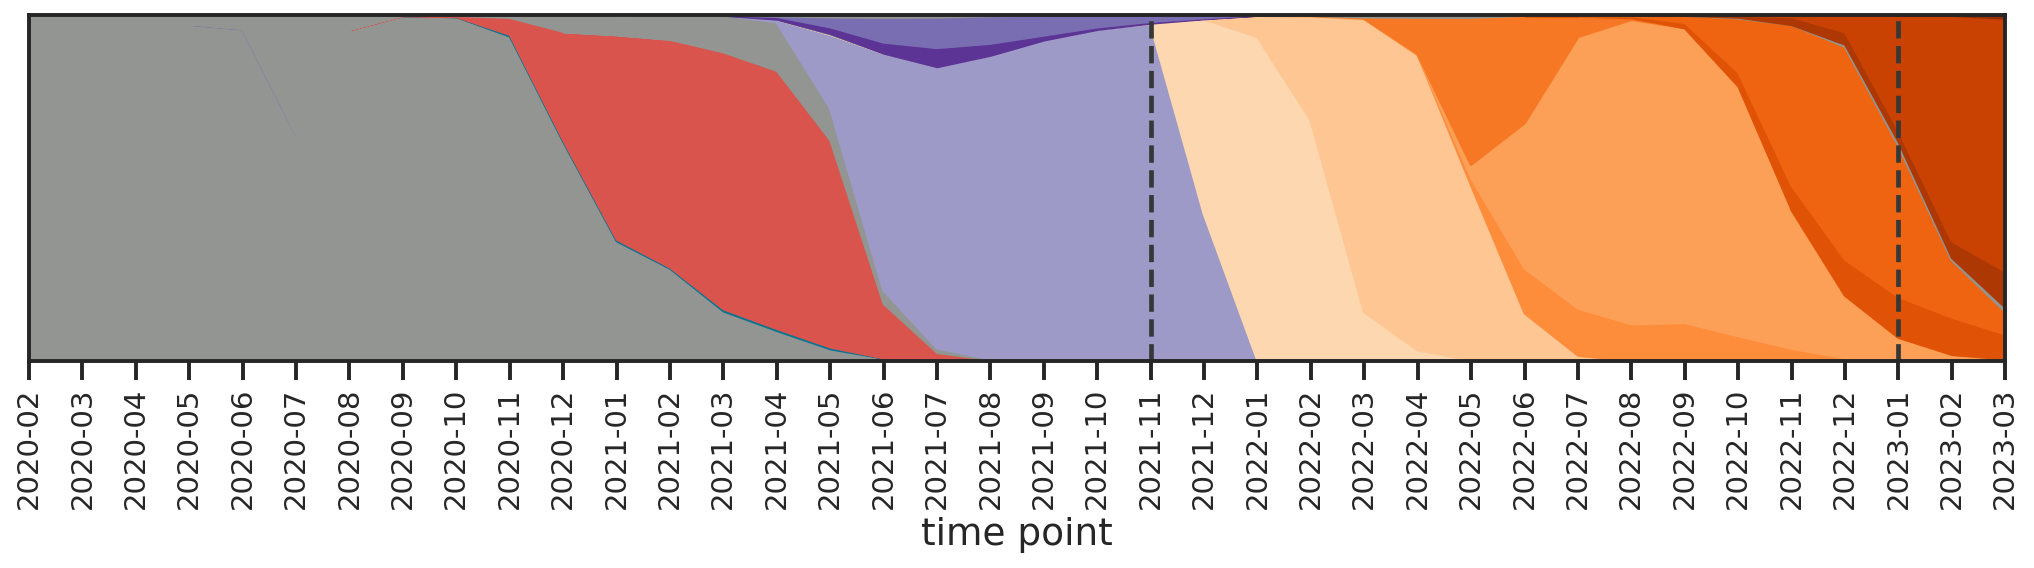

In [57]:
fig, ax = plt.subplots(figsize=(17, 3))

fish_plot(*data, ax=ax)

plt.yticks([])

names = sorted(r['name'].unique())

# plt.axvline(10,
#             color='xkcd:dark grey',
#             ls='dashed')
# plt.axvline(13,
#             color='xkcd:dark grey',
#             ls='dashed')
plt.axvline(21,
            color='xkcd:dark grey',
            ls='dashed')
plt.axvline(35,
            color='xkcd:dark grey',
            ls='dashed')

plt.xlabel('time point')

plt.xticks(range(len(names)),
           names,
           rotation=90,
           fontsize=14)

plt.savefig('time_9.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_9.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

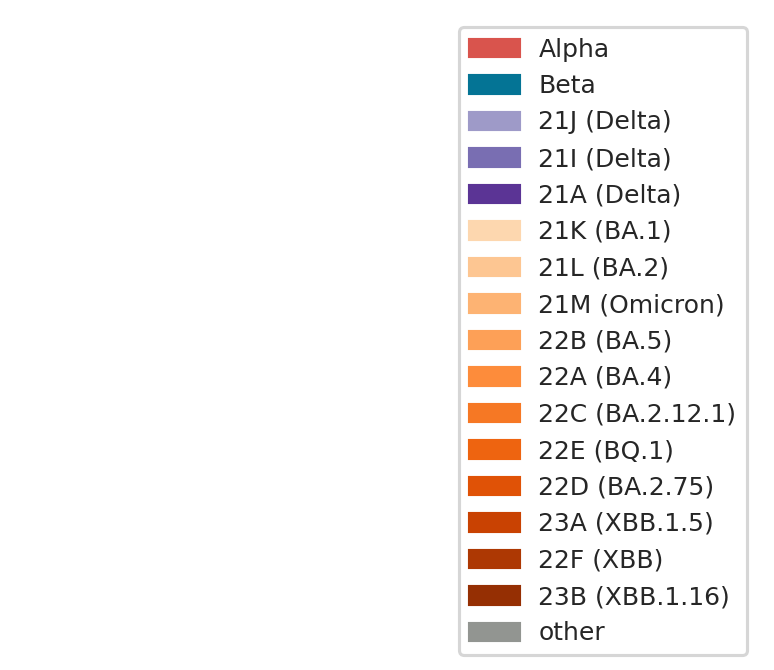

In [58]:
patches = []
for k, v in voc.items():
    if type(v) == str:
        if v != 'xkcd:grey':
            patch = mpatches.Patch(color=v, label=k)
            patches.append(patch)
    else:
        for k1, v1 in voc[k].items():
            patch = mpatches.Patch(color=v1, label=k1)
            patches.append(patch)

patch = mpatches.Patch(color='xkcd:grey', label='other')
patches.append(patch)

plt.legend(handles=patches, facecolor='w', fontsize=12, ncols=1)

plt.xticks([])
plt.yticks([])

sns.despine(left=True, bottom=True)

plt.savefig('time_9_legend.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_9_legend.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);

In [59]:
res = []
for f in os.listdir('../out/time-lineages/'):
    l = pd.read_csv(f'../out/time-lineages/{f}', sep='\t',
                    usecols=['seqName', 'clade', 'Nextclade_pango',
                             'partiallyAliased', 'clade_nextstrain',
                             'clade_who', 'clade_display',
                             'aaSubstitutions', 'aaDeletions', 'aaInsertions'])
    date = f.split('.')[0]
    year = int(date.split('-')[0])
    month = int(date.split('-')[1])

    d = {}
    for clade, line in l[['clade_display', 'aaSubstitutions']].values:
        for x in line.split(','):
            k, v = x.split(':')
            if k != 'S':
                continue
            while True:
                v = v[1:]
                try:
                    v = int(v)
                except ValueError:
                    v = v[:-1]
                    try:
                        v = int(v)
                    except ValueError:
                        continue
                break
            d[k] = d.get(k, set())
            d[k].add(v)

        for k, vv in d.items():
            for v in vv:
                if v in INTERESTING:
                    res.append((date, clade, k, v))

In [60]:
r = pd.DataFrame(res,
                 columns=['name', 'clade', 'gene', 'position'])

In [61]:
aa = r.groupby(['gene', 'position', 'name']).count().reset_index().pivot_table(index='position', columns='name', values='clade')
aa = aa.fillna(0)

In [62]:
aa.loc[sorted(AFFINITY)].T

position     498     501
name                    
2020-03      0.0     0.0
2020-04      0.0  1102.0
2020-05      0.0   471.0
2020-06      0.0  1060.0
2020-07      0.0   719.0
2020-08      0.0  1218.0
2020-09      0.0  1706.0
2020-10      0.0  2002.0
2020-11      0.0  2482.0
2020-12   2406.0  2469.0
2021-01      0.0  2491.0
2021-02      0.0  2500.0
2021-03   1530.0  2499.0
2021-04      0.0  2499.0
2021-05    132.0  2500.0
2021-06      0.0  2500.0
2021-07      0.0  2482.0
2021-08      0.0  2478.0
2021-09      0.0     0.0
2021-10      0.0     0.0
2021-11      0.0   746.0
2021-12   2476.0  2476.0
2022-01   2478.0  2478.0
2022-02   2499.0  2499.0
2022-03   2500.0  2500.0
2022-04   2500.0  2500.0
2022-05   2500.0  2500.0
2022-06   2500.0  2500.0
2022-07   2500.0  2500.0
2022-08   2500.0  2500.0
2022-09   2500.0  2500.0
2022-10   2500.0  2500.0
2022-11   2500.0  2500.0
2022-12   2500.0  2500.0
2023-01   2500.0  2500.0
2023-02   2500.0  2500.0
2023-03   2500.0  2500.0

In [63]:
aa.loc[sorted(AFFINITY) + sorted(INTERESTING.difference(AFFINITY).intersection(aa.index))].T

position     498     501     417     439     440     446     447     449  \
name                                                                       
2020-03      0.0     0.0     0.0  2027.0     0.0     0.0     0.0     0.0   
2020-04      0.0  1102.0     0.0  2427.0     0.0  1923.0     0.0     0.0   
2020-05      0.0   471.0     0.0  2266.0     0.0  1647.0     0.0     0.0   
2020-06      0.0  1060.0     0.0  2311.0     0.0     0.0     0.0     0.0   
2020-07      0.0   719.0     0.0  1894.0     0.0   270.0     0.0     0.0   
2020-08      0.0  1218.0     0.0  2493.0  1853.0  1836.0     0.0     0.0   
2020-09      0.0  1706.0     0.0  2446.0   894.0     0.0     0.0     0.0   
2020-10      0.0  2002.0  1378.0  2458.0     0.0     0.0     0.0     0.0   
2020-11      0.0  2482.0  2392.0  2315.0     0.0  1436.0     0.0     0.0   
2020-12   2406.0  2469.0  2465.0  2432.0  2406.0  1645.0     0.0     0.0   
2021-01      0.0  2491.0  2387.0  2193.0   587.0  1733.0     0.0     0.0   
2021-02      0.0  2500.0  2346.0  1901.0  1599.0  1579.0     0.0     0.0   
2021-03   1530.0  2499.0  2486.0  1704.0  1878.0  1339.0  1485.0  1844.0   
2021-04      0.0  2499.0  2494.0     0.0  1094.0     0.0     0.0   792.0   
2021-05    132.0  2500.0  2498.0     0.0  2452.0   132.0     0.0  2171.0   
2021-06      0.0  2500.0  2455.0     0.0  1497.0  1883.0     0.0    91.0   
2021-07      0.0  2482.0  2488.0   246.0  2291.0  2352.0     0.0     0.0   
2021-08      0.0  2478.0  2478.0     0.0     0.0  2484.0   146.0     0.0   
2021-09      0.0     0.0  2402.0     0.0    60.0  2143.0     0.0     0.0   
2021-10      0.0     0.0     0.0     0.0  2326.0  1972.0     0.0     0.0   
2021-11      0.0   746.0  1965.0     0.0   945.0  1634.0     0.0     0.0   
2021-12   2476.0  2476.0  2487.0     0.0  2487.0  2487.0     0.0     0.0   
2022-01   2478.0  2478.0  2494.0     0.0  2494.0  2494.0     0.0     0.0   
2022-02   2499.0  2499.0  2499.0     0.0  2493.0  2493.0     0.0     0.0   
2022-03   2500.0  2500.0  2500.0     0.0  2500.0  2092.0     0.0     0.0   
2022-04   2500.0  2500.0  2499.0     0.0  2499.0  1954.0     0.0  2462.0   
2022-05   2500.0  2500.0  2500.0     0.0  2500.0     0.0     0.0  1509.0   
2022-06   2500.0  2500.0  2500.0     0.0  2500.0  1799.0     0.0  1879.0   
2022-07   2500.0  2500.0  2500.0     0.0  2500.0  2308.0     0.0  2400.0   
2022-08   2500.0  2500.0  2500.0     0.0  2500.0  2159.0     0.0     0.0   
2022-09   2500.0  2500.0  2500.0     0.0  2500.0  2495.0     0.0     0.0   
2022-10   2500.0  2500.0  2500.0     0.0  2500.0  2330.0     0.0     0.0   
2022-11   2500.0  2500.0  2500.0     0.0  2500.0  2483.0     0.0     0.0   
2022-12   2500.0  2500.0  2500.0     0.0  2498.0  2498.0     0.0     0.0   
2023-01   2500.0  2500.0  2499.0     0.0  2500.0  2493.0     0.0     0.0   
2023-02   2500.0  2500.0  2500.0     0.0  2500.0  2500.0     0.0     0.0   
2023-03   2500.0  2500.0  2500.0     0.0  2500.0  2500.0     0.0     0.0   

position     452     455     456     477     484    489     493     494  \
name                                                                      
2020-03   1153.0     0.0     0.0     0.0  1153.0    0.0     0.0     0.0   
2020-04    107.0     0.0     0.0  2052.0     0.0    0.0     0.0  1181.0   
2020-05      0.0     0.0     0.0  2493.0  2361.0    0.0  1169.0   105.0   
2020-06      0.0     0.0     0.0  2465.0     0.0    0.0     0.0   115.0   
2020-07   1490.0     0.0     0.0  2478.0   681.0    0.0     0.0     0.0   
2020-08      0.0     0.0     0.0  2492.0  1090.0    0.0     0.0  2300.0   
2020-09   1028.0     0.0     0.0  2498.0   610.0    0.0     0.0     0.0   
2020-10   2490.0     0.0     0.0  2413.0  1378.0    0.0     0.0  2475.0   
2020-11   2383.0     0.0     0.0  2435.0  2392.0    0.0     0.0  1370.0   
2020-12   2498.0     0.0     0.0  2448.0  2465.0    0.0  2406.0  2012.0   
2021-01   2497.0     0.0     0.0  2458.0  2487.0    0.0     0.0  2224.0   
2021-02   2499.0     0.0  1658.0  2386.0  2370.0    0.0  162

In [64]:
df = []
for name in os.listdir('../out/time-filtered-subsets/'):
    try:
        a = read_mi(f'../out/time-filtered-subsets/{name}/mi_annotated_prefilter.tsv.gz',
                    name,
                    date=True)
        a1 = a[(a['gene_source'] == 'S') &
               (a['gene_target'] == 'S') &
               ((a['feature_codon_source'] == 501) &
                (a['feature_codon_target'] == 498))]
        a2 = a[(a['gene_source'] == 'S') &
               (a['gene_target'] == 'S') &
               ((a['feature_codon_source'].isin(AFFINITY)) &
                (a['feature_codon_target'].isin(INTERESTING.difference(AFFINITY))))]
        df.append(pd.concat([a1, a2]))
    except FileNotFoundError:
        pass
df = pd.concat(df)

/home/marco/workspace/2022_sarscov2_epistasis/notebooks/utils.py:46: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv(fname, sep='\t')
/home/marco/workspace/2022_sarscov2_epistasis/notebooks/utils.py:46: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv(fname, sep='\t')
/home/marco/workspace/2022_sarscov2_epistasis/notebooks/utils.py:46: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv(fname, sep='\t')
/home/marco/workspace/2022_sarscov2_epistasis/notebooks/utils.py:46: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv(fname, sep='\t')


In [65]:
df.groupby(['year', 'month'])['pos_source'].count()

year  month
2020  3        297
      4        143
      7         35
      8        113
      9        137
      10       183
      11       114
      12        23
2021  1          1
      2         33
      3         33
      4         33
      5         68
      6         69
      7         76
      8         79
      9         79
      10        79
      11        78
      12       139
2022  1        180
      2        168
      3        106
      4         91
      5         91
      6         89
      7         85
      8         28
      9         13
      10        13
      11        13
      12        13
2023  1         13
      2         13
      3         13
Name: pos_source, dtype: int64

In [66]:
s1 = df[(~df['name'].isin(['2020-02',
                           # '2020-03'
                          ])) &
        (df['gene_source'] == 'S') &
        (df['gene_target'] == 'S') &
        ((df['feature_codon_source'] == 501) &
         (df['feature_codon_target'] == 498))].copy()

s1 = s1.pivot_table(index=['feature_codon_source',
                          'feature_codon_target'],
                   columns='name',
                   values='outlier',
                   aggfunc=max).reindex(columns=sorted(df[~df['name'].isin(['2020-02',
                                                                            # '2020-03'
                                                                           ])]['name'].unique()))

In [67]:
s2 = df[(~df['name'].isin(['2020-02',
                           # '2020-03'
                          ])) &
        (df['gene_source'] == 'S') &
        (df['gene_target'] == 'S') &
        ((df['feature_codon_source'].isin(AFFINITY)) &
         (df['feature_codon_target'].isin(INTERESTING.difference(AFFINITY))))].copy()

s2 = s2.pivot_table(index=['feature_codon_source',
                          'feature_codon_target'],
                   columns='name',
                   values='outlier',
                   aggfunc=max).reindex(columns=sorted(df[~df['name'].isin(['2020-02',
                                                                            # '2020-03'
                                                                           ])]['name'].unique()))

In [68]:
s = pd.concat([s1, s2])

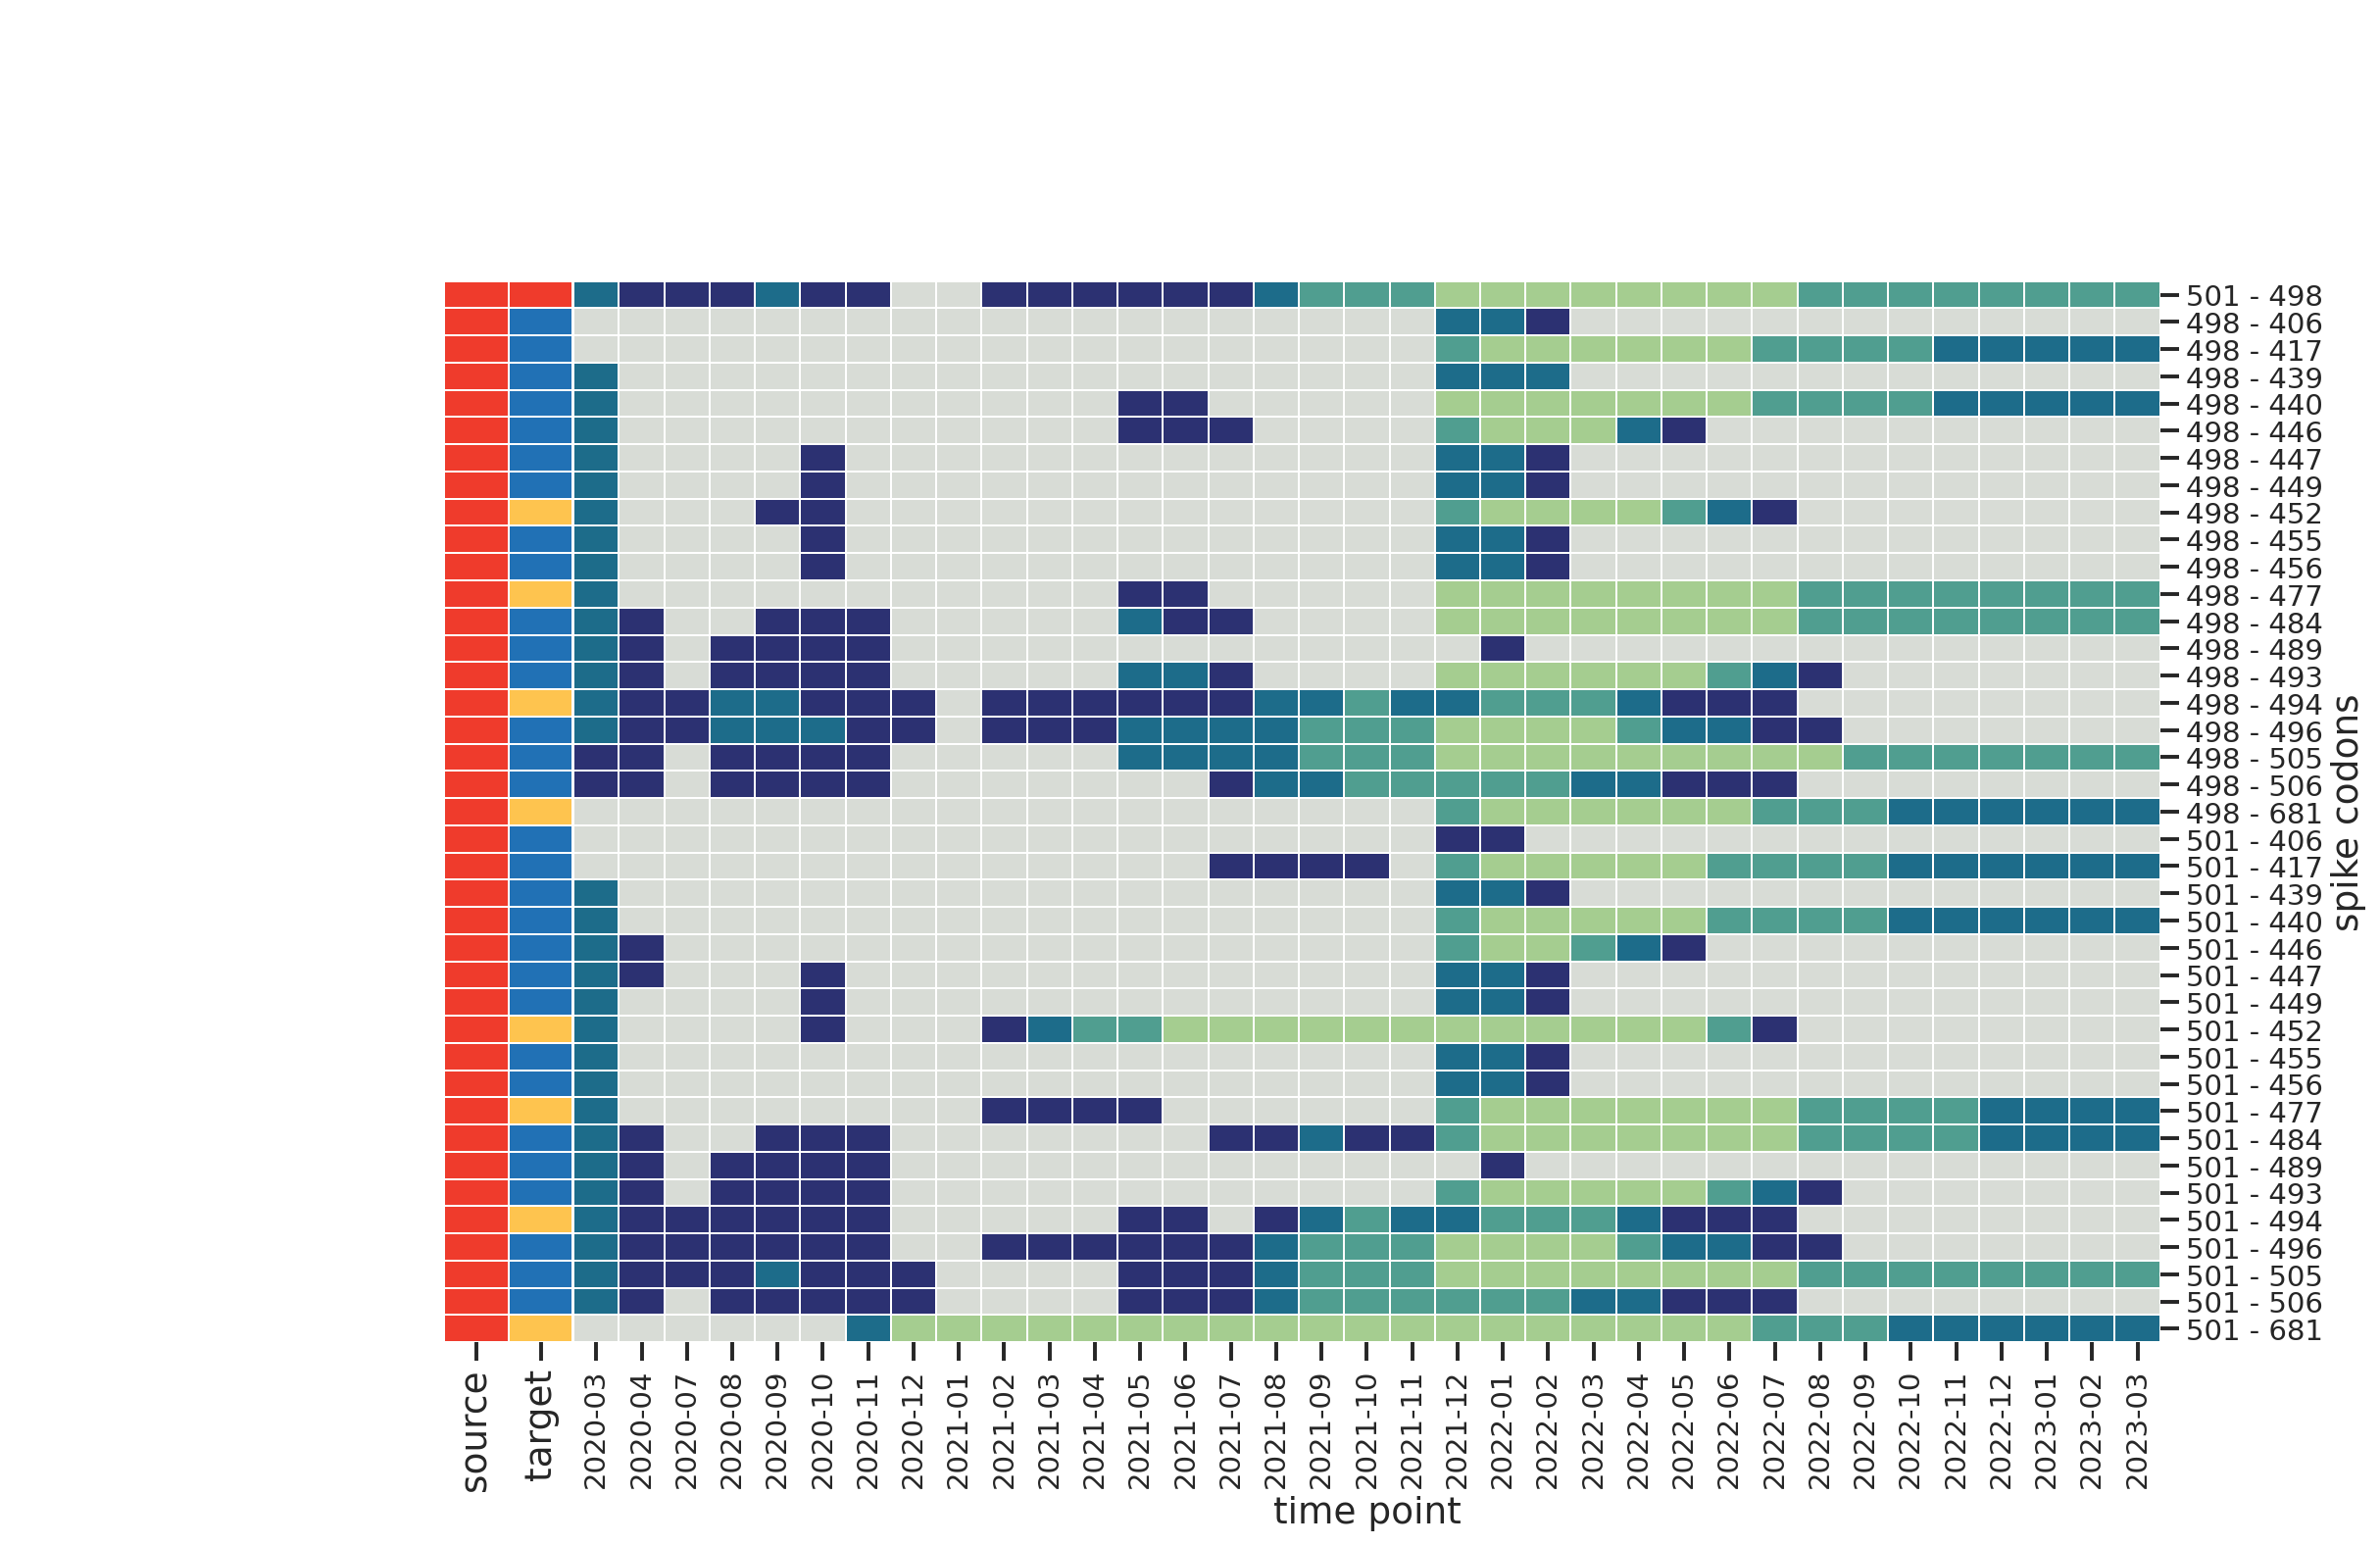

In [69]:
cmap = plt.get_cmap('crest_r').copy()
cmap.set_bad('xkcd:light grey')

colors1 = []
colors2 = []
for x, y in s.index:
    if x in AFFINITY:
        colors1.append('#ef3b2cff')
    elif x in ESCAPE:
        colors1.append('#2171b5ff')
    elif x in MOI:
        colors1.append('#fec44fff')
    else:
        colors1.append('xkcd:grey')

    if y in AFFINITY:
        colors2.append('#ef3b2cff')
    elif y in ESCAPE:
        colors2.append('#2171b5ff')
    elif y in MOI:
        colors2.append('#fec44fff')
    else:
        colors2.append('xkcd:grey')

cm = sns.clustermap(s, cmap=cmap,
                    row_cluster=False, col_cluster=False,
                    row_colors=pd.DataFrame([[a, b] for a, b in zip(colors1, colors2)],
                                            columns=['source', 'target'],
                                            index=s.index),
                    linewidths=0.005,
                    cbar_pos=None,
                    figsize=(17, 11),
                    vmin=1, vmax=4)

cm.ax_heatmap.set_xlabel('time point')
cm.ax_heatmap.set_ylabel('spike codons')

cm.ax_heatmap.set_xticks([x + 0.5 for x in range(s.shape[1])],
                         s.columns,
                         fontsize=14)
cm.ax_heatmap.set_yticks([x + 0.5 for x in range(s.shape[0])],
                         [f'{int(x)} - {int(y)}' for x, y in s.index],
                         fontsize=14)

cm.ax_row_colors.set_xticks([0.5, 1.5],
                            ['source', 'target'],
                            fontsize=18)

plt.savefig('time_10.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('time_10.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);